In [2]:
import numpy as np
import pandas as pd
import os
import random
import sys
import gc
import warnings
import polars as pl
from tqdm import tqdm
import pickle
import joblib
import matplotlib.pyplot as plt

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import mean_squared_error, log_loss, f1_score, roc_curve, accuracy_score, roc_auc_score, precision_recall_curve
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.utils import class_weight

import optuna
from optuna.samplers import TPESampler

pd.options.display.max_columns = 999
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
dtypes = {"session_id": pl.Int64,
          "elapsed_time": pl.Int64,
          "event_name": pl.Categorical,
          "name": pl.Categorical,
          "level": pl.Int8,
          "page": pl.Float32,
          "room_coor_x": pl.Float32,
          "room_coor_y": pl.Float32,
          "screen_coor_x": pl.Float32,
          "screen_coor_y": pl.Float32,
          "hover_duration": pl.Float32,
          "fqid": pl.Categorical,
          "room_fqid": pl.Categorical,
          "fullscreen": pl.Int8,
          "hq": pl.Int8,
          "music": pl.Int8,
          "level_group": pl.Categorical
          }

In [4]:
pl.toggle_string_cache(True)

In [5]:
#train = pd.read_parquet('/kaggle/input/jo-convert/train.parquet')
#train_labels = pd.read_parquet('/kaggle/input/jo-convert/train_labels.parquet')
train = pl.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv', dtypes = dtypes)
train_labels = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
#test = pl.read_parquet('/kaggle/input/jo-convert/test.parquet')
#submission = pl.read_csv('/kaggle/input/predict-student-performance-from-game-play/sample_submission.csv')
#game_type_text_translation = pd.read_csv('/kaggle/input/jo-type/game_type_text_translation.csv')

In [5]:
#game_type_text_translation.tail()

In [6]:
# normal_set = set(game_type_text_translation['normal'])
# dry_set = set(game_type_text_translation['dry'])
# nohumor_set = set(game_type_text_translation['nohumor'])
# nosnark_set = set(game_type_text_translation['nosnark'])

# def get_type(text):
#     type_counts = {'normal_cnt': 0, 'dry_cnt': 0, 'nohumor_cnt': 0, 'nosnark_cnt': 0}
#     for char in text:
#         if char in normal_set:
#             type_counts['normal_cnt'] += 1
#         elif char in dry_set:
#             type_counts['dry_cnt'] += 1
#         elif char in nohumor_set:
#             type_counts['nohumor_cnt'] += 1
#         elif char in nosnark_set:
#             type_counts['nosnark_cnt'] += 1
#     max_vals = sorted(type_counts.values(), reverse=True)
    
#     type_is = [k for k, v in type_counts.items() if v == max_vals[0]]
    
#     if len(type_is) > 1:
#         type_is = np.nan
#     else:
#         type_is = type_is[0]
    
#     return type_is

# temp = train.groupby(['session_id', 'level_group'])['text'].unique()
# temp = temp.reset_index()
# temp['type_is'] = temp['text'].apply(get_type)
# temp = temp.drop(['text'], axis = 1)
#train = pd.merge(train, temp, on = ['session_id', 'level_group'])
#train.head()

In [7]:
# train['elapsed_time_diff'] = (train['elapsed_time'] - train['elapsed_time'].shift(1)).fillna(0).clip(0, 1e9)
# train['elapsed_time_cumsum'] = train['elapsed_time'].cumsum()
# train['elapsed_time_cumsum_seconds'] = train['elapsed_time_cumsum'] // 1000
# #train.loc[train['elapsed_time_diff'] < 0, 'elapsed_time_diff'] = 0

# train['screen_coor_x'] = np.abs(train['screen_coor_x'] - train['screen_coor_x'].shift(1))
# train['screen_coor_y'] = np.abs(train['screen_coor_y'] - train['screen_coor_y'].shift(1))
# train['room_coor_x'] = np.abs(train['room_coor_x'] - train['room_coor_x'].shift(1))
# train['room_coor_y'] = np.abs(train['room_coor_y'] - train['room_coor_y'].shift(1))

In [8]:
# train['text'] = train['text'].astype(str).apply(lambda x: '' if x == 'nan' else x)
# train['text_fqid'] = train['text_fqid'].astype(str).apply(lambda x: 'text_fqid_None' if x == 'nan' else x)
# train['fqid'] = train['fqid'].astype(str).apply(lambda x: 'fqid_None' if x == 'nan' else x)

# train['text'] = train['text'].astype(str).where(train['text'] != 'nan', '')
# train['text_fqid'] = train['text_fqid'].astype(str).where(train['text_fqid'] != 'nan', 'text_fqid_None')
# train['fqid'] = train['fqid'].astype(str).where(train['fqid'] != 'nan', 'fqid_None')

text_fqid는 fqid와 room_fqid가 결합되어 있는 구조

room_fqid는 spot과 perform으로 분리시킬 수 있습니다.

일부 text_fqid의 마지막 부분에 새로운 정보가 추가로 등장합니다.

따라서 마지막 부분만 뽑아 새로운 변수 창출

In [9]:
# train['room_fqid_spot'] = train['room_fqid'].apply(lambda x: (x.split('.'))[1])
# train['room_fqid_perform'] = train['room_fqid'].apply(lambda x: (x.split('.'))[-1])
# train['room_fqid_spot'] = train['room_fqid'].str.rsplit('.').str[1]
# train['room_fqid_perform'] = train['room_fqid'].str.rsplit('.').str[-1]

# train['text_fqid_newinfo'] = train['text_fqid'].apply(lambda x: x.split('.')[-1] if len(x.split('.')) > 4 else 'newinfo_None')
# train['text_fqid_front'] = train['text_fqid'].apply(lambda x: '.'.join(x.split('.')[:-1]) if len(x.split('.')) > 4 else x)
# train['text_fqid_parts'] = train['text_fqid'].str.split('.', expand=True)
# train['text_fqid_newinfo'] = train['text_fqid_parts'].apply(lambda x: x[-1] if len(x) > 4 else 'newinfo_None')
# train['text_fqid_front'] = train['text_fqid_parts'].apply(lambda x: '.'.join(x[:-1]) if len(x) > 4 else train['text_fqid'])

이모지 처리

In [10]:
# emoji_dict = {
#     '\\u00f0\\u0178\\u02dc\\u00b4': "😴",
#     '\\u00f0\\u0178\\u00a6\\u2014': "🦗",
#     '\\u00f0\\u0178\\u02dc\\u0160': "😊",
#     '\\u00f0\\u0178\\u02dc\\u00ad': "😭",
#     '\\u00e2\\u009d\\u00a4\\u00ef\\u00b8\\u008f': "❤️",
#     '\\u00f0\\u0178\\u02dc\\u0090': "😐",
#     '\\u00f0\\u0178\\u02dc\\u009d': "😝",
#     '\\u00f0\\u0178\\u00a7\\u02dc': "🧘",
#     '\\u00f0\\u0178\\u008d\\u00a9': "🍩",
#     '\\u00f0\\u0178\\u2122\\u201e': "🙄",
#     'I used to have a magnifying glass around here\\u00e2\\u20ac\\u00a6': "I used to have a magnifying glass around here…",
# }

# for symbol, emoji in emoji_dict.items():
#     filter_symbol = train['text'] == symbol
#     train.loc[filter_symbol, 'text'] = emoji

불용어(Stop word)는 분석에 큰 의미가 없는 단어입니다.

text에 불용어가 포함되어 있는 경우 불용어 수를 카운트합니다.

In [6]:
STOPWORDS = ['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no',
 'nor',
 'not',
 'only',
 'own',
 'same',
 'so',
 'than',
 'too',
 'very',
 's',
 't',
 'can',
 'will',
 'just',
 'don',
 "don't",
 'should',
 "should've",
 'now',
 'd',
 'll',
 'm',
 'o',
 're',
 've',
 'y',
 'ain',
 'aren',
 "aren't",
 'couldn',
 "couldn't",
 'didn',
 "didn't",
 'doesn',
 "doesn't",
 'hadn',
 "hadn't",
 'hasn',
 "hasn't",
 'haven',
 "haven't",
 'isn',
 "isn't",
 'ma',
 'mightn',
 "mightn't",
 'mustn',
 "mustn't",
 'needn',
 "needn't",
 'shan',
 "shan't",
 'shouldn',
 "shouldn't",
 'wasn',
 "wasn't",
 'weren',
 "weren't",
 'won',
 "won't",
 'wouldn',
 "wouldn't"]

# use
#DIALOGS = ['that', 'this', 'it', 'you','find','found','notebook','wells','help','need', 'oh','ooh','jo', 'flag', 'can','and','is','the','to']

#DIALOGS = ['that', 'this', 'it', 'you', 'find', 'notebook', 'help', 'need', 'jo', 'flag']

#RELATIVE_MARK = ['who', 'what', 'where', 'when', 'why', 'how']
QUESTION_MARK = ['\?']

#STOPWORDS = set(STOPWORDS)
#train['stop_words_count'] = train['text'].str.lower().apply(lambda x: sum(1 for word in x.split(' ') if word in STOPWORDS)

# def count_stopwords(text):
#     words = text.split(' ')
#     stopwords_count = sum(word.lower() in STOPWORDS for word in words)
#     return stopwords_count
# train['stop_words_count'] = train['text'].apply(count_stopwords)

In [7]:
columns = [
    pl.col('page').cast(pl.Float32),
    pl.col('text').cast(pl.Utf8),
    (
        (pl.col('elapsed_time') - pl.col('elapsed_time').shift(1)).fill_null(0).clip(0, 1e9).alias('elapsed_time_diff')
    ),
    (
       (pl.col('screen_coor_x') - pl.col('screen_coor_x').shift(1)).abs().over(['session_id', 'level_group'])
    ),
    (
       (pl.col('screen_coor_y') - pl.col('screen_coor_y').shift(1)).abs().over(['session_id', 'level_group'])
    ),
    (
     (pl.col('room_coor_x') - pl.col('room_coor_x').shift(1)).abs().over(['session_id', 'level_group'])
    ),
    (
     (pl.col('room_coor_y') - pl.col('room_coor_y').shift(1)).abs().over(['session_id', 'level_group'])
    ),
    pl.col('fqid').fill_null('fqid_None'),
    pl.col('text_fqid').fill_null('text_fqid_None')
]

train = train.drop(['fullscreen', 'hq', 'music']).with_columns(columns)

gc.collect()

60

In [7]:
# def preprocessing(df):
#     df.sort_values(by = ['session_id', 'elapsed_time'], inplace = True)
#     columns = [
#         pl.col('page').cast(pl.Float32),
#         pl.col('text').cast(pl.Utf8),
#         (
#             (pl.col('elapsed_time') - pl.col('elapsed_time').shift(1)).fill_null(0).clip(0, 1e9).alias('elapsed_time_diff')
#         ),
#         pl.col('fqid').fill_null('fqid_None'),
#         pl.col('text_fqid').fill_null('text_fqid_None')
#     ]
#     return pl.DataFrame(df).with_columns(columns).groupby(['session_id', 'level_group'], maintain_order = True).agg(feature_generation).to_pandas().set_index('session_id').sort_index()

In [8]:
# train = train.with_columns(
#     pl.col('text').apply(lambda x: x.lower()).alias('text_lower')
# ).drop(['text'])

# gc.collect()

In [8]:
train = train.with_columns(((pl.col('elapsed_time').cumsum().over(pl.col('session_id'))).alias('elapsed_time_cumsum')))
train = train.with_columns(((pl.col('elapsed_time_cumsum') // 1000).alias('elapsed_time_cumsum_seconds'))).drop(['elapsed_time_cumsum'])

gc.collect()

0

In [9]:
ROOM_FQID = ['tunic.historicalsociety.closet',
 'tunic.historicalsociety.basement',
 'tunic.historicalsociety.entry',
 'tunic.historicalsociety.collection',
 'tunic.historicalsociety.stacks',
 'tunic.kohlcenter.halloffame',
 'tunic.capitol_0.hall',
 'tunic.historicalsociety.closet_dirty',
 'tunic.historicalsociety.frontdesk',
 'tunic.humanecology.frontdesk',
 'tunic.drycleaner.frontdesk',
 'tunic.library.frontdesk',
 'tunic.library.microfiche',
 'tunic.capitol_1.hall',
 'tunic.historicalsociety.cage',
 'tunic.historicalsociety.collection_flag',
 'tunic.wildlife.center',
 'tunic.flaghouse.entry',
 'tunic.capitol_2.hall']
ROOM_FQID_SPOT = ['historicalsociety',
 'kohlcenter',
 'capitol_0',
 'humanecology',
 'drycleaner',
 'library',
 'capitol_1',
 'wildlife',
 'flaghouse',
 'capitol_2']
ROOM_FQID_PERFORM = ['closet',
 'basement',
 'entry',
 'collection',
 'stacks',
 'halloffame',
 'hall',
 'closet_dirty',
 'frontdesk',
 'microfiche',
 'cage',
 'collection_flag',
 'center']
FQID = ['intro',
 'gramps',
 'teddy',
 'photo',
 'fqid_None',
 'notebook',
 'retirement_letter',
 'tobasement',
 'janitor',
 'toentry',
 'groupconvo',
 'report',
 'boss',
 'wells',
 'directory',
 'tocollection',
 'cs',
 'tunic',
 'tunic.hub.slip',
 'tostacks',
 'outtolunch',
 'tocloset',
 'tomap',
 'tunic.historicalsociety',
 'tunic.kohlcenter',
 'plaque',
 'plaque.face.date',
 'togrampa',
 'tunic.capitol_0',
 'chap1_finale',
 'chap1_finale_c',
 'tocloset_dirty',
 'what_happened',
 'trigger_scarf',
 'trigger_coffee',
 'tunic.capitol_1',
 'tofrontdesk',
 'archivist',
 'magnify',
 'tunic.humanecology',
 'worker',
 'businesscards',
 'businesscards.card_0.next',
 'businesscards.card_1.next',
 'businesscards.card_bingo.next',
 'businesscards.card_bingo.bingo',
 'tohallway',
 'tunic.drycleaner',
 'logbook',
 'logbook.page.bingo',
 'tunic.library',
 'tomicrofiche',
 'reader',
 'reader.paper0.next',
 'reader.paper1.next',
 'reader.paper2.bingo',
 'wellsbadge',
 'journals',
 'journals.hub.topics',
 'journals.pic_0.next',
 'journals.pic_1.next',
 'journals.pic_2.bingo',
 'chap2_finale_c',
 'ch3start',
 'seescratches',
 'tocage',
 'glasses',
 'directory.closeup.archivist',
 'key',
 'unlockdoor',
 'confrontation',
 'savedteddy',
 'tocollectionflag',
 'groupconvo_flag',
 'tunic.capitol_2',
 'tunic.wildlife',
 'coffee',
 'crane_ranger',
 'remove_cup',
 'expert',
 'tracks',
 'tracks.hub.deer',
 'tunic.flaghouse',
 'flag_girl',
 'colorbook',
 'reader_flag',
 'reader_flag.paper0.next',
 'reader_flag.paper1.next',
 'reader_flag.paper2.bingo',
 'archivist_glasses',
 'journals_flag',
 'journals_flag.hub.topics_old',
 'journals_flag.hub.topics',
 'journals_flag.pic_0.bingo',
 'journals_flag.pic_0.next',
 'chap4_finale_c',
 'block_tocollection',
 'reader.paper2.next',
 'journals.pic_2.next',
 'lockeddoor',
 'reader.paper2.prev',
 'reader.paper0.prev',
 'reader_flag.paper1.prev',
 'journals_flag.pic_0_old.next',
 'journals_flag.pic_1_old.next',
 'reader.paper1.prev',
 'block_0',
 'journals_flag.pic_1.bingo',
 'block_magnify',
 'journals_flag.pic_1.next',
 'doorblock',
 'journals_flag.pic_2.bingo',
 'journals_flag.pic_2.next',
 'door_block_clean',
 'door_block_talk',
 'block',
 'reader_flag.paper2.next',
 'block_tomap2',
 'reader_flag.paper0.prev',
 'journals_flag.pic_2_old.next',
 'need_glasses',
 'block_nelson',
 'block_tomap1',
 'reader_flag.paper2.prev',
 'block_badge',
 'fox',
 'block_badge_2',
 'block_1',
 'chap2_finale']
TEXT_FQID = ['tunic.historicalsociety.closet.intro',
 'tunic.historicalsociety.closet.gramps.intro_0_cs_0',
 'tunic.historicalsociety.closet.teddy.intro_0_cs_0',
 'text_fqid_None',
 'tunic.historicalsociety.closet.teddy.intro_0_cs_5',
 'tunic.historicalsociety.closet.photo',
 'tunic.historicalsociety.closet.notebook',
 'tunic.historicalsociety.closet.retirement_letter.hub',
 'tunic.historicalsociety.basement.janitor',
 'tunic.historicalsociety.entry.groupconvo',
 'tunic.historicalsociety.entry.boss.talktogramps',
 'tunic.historicalsociety.entry.wells.talktogramps',
 'tunic.historicalsociety.collection.cs',
 'tunic.historicalsociety.collection.tunic.slip',
 'tunic.historicalsociety.collection.gramps.found',
 'tunic.historicalsociety.stacks.outtolunch',
 'tunic.kohlcenter.halloffame.plaque.face.date',
 'tunic.kohlcenter.halloffame.togrampa',
 'tunic.capitol_0.hall.boss.talktogramps',
 'tunic.historicalsociety.closet_dirty.what_happened',
 'tunic.historicalsociety.closet_dirty.gramps.helpclean',
 'tunic.historicalsociety.closet_dirty.trigger_scarf',
 'tunic.historicalsociety.closet_dirty.trigger_coffee',
 'tunic.historicalsociety.closet_dirty.gramps.news',
 'tunic.historicalsociety.frontdesk.archivist.hello',
 'tunic.historicalsociety.frontdesk.archivist.need_glass_0',
 'tunic.historicalsociety.frontdesk.magnify',
 'tunic.historicalsociety.frontdesk.archivist.have_glass',
 'tunic.historicalsociety.frontdesk.archivist.have_glass_recap',
 'tunic.humanecology.frontdesk.worker.intro',
 'tunic.humanecology.frontdesk.businesscards.card_bingo.bingo',
 'tunic.humanecology.frontdesk.worker.badger',
 'tunic.drycleaner.frontdesk.worker.hub',
 'tunic.drycleaner.frontdesk.logbook.page.bingo',
 'tunic.drycleaner.frontdesk.worker.done',
 'tunic.library.frontdesk.worker.hello',
 'tunic.library.microfiche.reader.paper2.bingo',
 'tunic.library.frontdesk.wellsbadge.hub',
 'tunic.library.frontdesk.worker.wells',
 'tunic.capitol_1.hall.boss.haveyougotit',
 'tunic.historicalsociety.frontdesk.archivist.newspaper',
 'tunic.historicalsociety.stacks.journals.pic_2.bingo',
 'tunic.historicalsociety.basement.ch3start',
 'tunic.historicalsociety.basement.gramps.whatdo',
 'tunic.historicalsociety.basement.seescratches',
 'tunic.historicalsociety.cage.glasses.beforeteddy',
 'tunic.historicalsociety.cage.teddy.trapped',
 'tunic.historicalsociety.cage.glasses.afterteddy',
 'tunic.historicalsociety.entry.directory.closeup.archivist',
 'tunic.historicalsociety.frontdesk.key',
 'tunic.historicalsociety.cage.unlockdoor',
 'tunic.historicalsociety.cage.confrontation',
 'tunic.historicalsociety.basement.savedteddy',
 'tunic.historicalsociety.collection_flag.gramps.flag',
 'tunic.historicalsociety.entry.groupconvo_flag',
 'tunic.historicalsociety.entry.wells.flag',
 'tunic.historicalsociety.entry.boss.flag',
 'tunic.historicalsociety.entry.wells.flag_recap',
 'tunic.historicalsociety.entry.boss.flag_recap',
 'tunic.wildlife.center.coffee',
 'tunic.wildlife.center.wells.animals',
 'tunic.wildlife.center.wells.animals2',
 'tunic.wildlife.center.crane_ranger.crane',
 'tunic.wildlife.center.remove_cup',
 'tunic.wildlife.center.expert.removed_cup',
 'tunic.wildlife.center.tracks.hub.deer',
 'tunic.wildlife.center.expert.recap',
 'tunic.wildlife.center.wells.nodeer',
 'tunic.flaghouse.entry.flag_girl.hello',
 'tunic.flaghouse.entry.colorbook',
 'tunic.flaghouse.entry.flag_girl.symbol',
 'tunic.flaghouse.entry.flag_girl.symbol_recap',
 'tunic.library.frontdesk.worker.flag',
 'tunic.library.microfiche.reader_flag.paper2.bingo',
 'tunic.library.frontdesk.worker.nelson',
 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation',
 'tunic.historicalsociety.stacks.journals_flag.pic_0.bingo',
 'tunic.historicalsociety.entry.block_tocollection',
 'tunic.historicalsociety.closet_dirty.gramps.archivist',
 'tunic.historicalsociety.cage.lockeddoor',
 'tunic.capitol_2.hall.boss.haveyougotit',
 'tunic.drycleaner.frontdesk.worker.done2',
 'tunic.library.frontdesk.worker.preflag',
 'tunic.historicalsociety.closet_dirty.photo',
 'tunic.historicalsociety.collection_flag.gramps.recap',
 'tunic.wildlife.center.wells.nodeer_recap',
 'tunic.library.frontdesk.worker.flag_recap',
 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap',
 'tunic.historicalsociety.collection.tunic',
 'tunic.historicalsociety.collection.gramps.lost',
 'tunic.humanecology.frontdesk.block_0',
 'tunic.library.frontdesk.worker.wells_recap',
 'tunic.capitol_1.hall.chap2_finale_c',
 'tunic.capitol_1.hall.boss.writeitup',
 'tunic.historicalsociety.stacks.journals_flag.pic_1.bingo',
 'tunic.historicalsociety.frontdesk.block_magnify',
 'tunic.historicalsociety.closet.doorblock',
 'tunic.historicalsociety.stacks.journals_flag.pic_2.bingo',
 'tunic.capitol_2.hall.chap4_finale_c',
 'tunic.historicalsociety.closet_dirty.door_block_clean',
 'tunic.historicalsociety.closet_dirty.door_block_talk',
 'tunic.historicalsociety.stacks.block',
 'tunic.flaghouse.entry.flag_girl.hello_recap',
 'tunic.historicalsociety.entry.block_tomap2',
 'tunic.historicalsociety.frontdesk.archivist.newspaper_recap',
 'tunic.historicalsociety.basement.gramps.seeyalater',
 'tunic.library.frontdesk.worker.hello_short',
 'tunic.historicalsociety.closet_dirty.gramps.nothing',
 'tunic.historicalsociety.cage.need_glasses',
 'tunic.library.frontdesk.block_nelson',
 'tunic.library.frontdesk.worker.nelson_recap',
 'tunic.historicalsociety.frontdesk.archivist.need_glass_1',
 'tunic.library.frontdesk.worker.droppedbadge',
 'tunic.drycleaner.frontdesk.worker.takealook',
 'tunic.historicalsociety.entry.block_tomap1',
 'tunic.capitol_0.hall.chap1_finale_c',
 'tunic.historicalsociety.frontdesk.archivist.foundtheodora',
 'tunic.library.frontdesk.block_badge',
 'tunic.kohlcenter.halloffame.block_0',
 'tunic.drycleaner.frontdesk.block_0',
 'tunic.library.microfiche.block_0',
 'tunic.historicalsociety.collection.gramps.look_0',
 'tunic.wildlife.center.fox.concern',
 'tunic.library.frontdesk.block_badge_2',
 'tunic.historicalsociety.entry.gramps.hub',
 'tunic.humanecology.frontdesk.block_1',
 'tunic.drycleaner.frontdesk.block_1']
TEXT_FQID_NEWINFO = ['newinfo_None',
 'intro_0_cs_0',
 'intro_0_cs_5',
 'hub',
 'talktogramps',
 'slip',
 'found',
 'date',
 'helpclean',
 'news',
 'hello',
 'need_glass_0',
 'have_glass',
 'have_glass_recap',
 'intro',
 'bingo',
 'badger',
 'done',
 'wells',
 'haveyougotit',
 'newspaper',
 'whatdo',
 'beforeteddy',
 'trapped',
 'afterteddy',
 'archivist',
 'flag',
 'flag_recap',
 'animals',
 'animals2',
 'crane',
 'removed_cup',
 'deer',
 'recap',
 'nodeer',
 'symbol',
 'symbol_recap',
 'nelson',
 'confrontation',
 'done2',
 'preflag',
 'nodeer_recap',
 'confrontation_recap',
 'lost',
 'wells_recap',
 'writeitup',
 'hello_recap',
 'newspaper_recap',
 'seeyalater',
 'hello_short',
 'nothing',
 'nelson_recap',
 'need_glass_1',
 'droppedbadge',
 'takealook',
 'foundtheodora',
 'look_0',
 'concern']
TEXT_FQID_FRONT = ['tunic.historicalsociety.closet.intro',
 'tunic.historicalsociety.closet.gramps',
 'tunic.historicalsociety.closet.teddy',
 'text_fqid_None',
 'tunic.historicalsociety.closet.photo',
 'tunic.historicalsociety.closet.notebook',
 'tunic.historicalsociety.closet.retirement_letter',
 'tunic.historicalsociety.basement.janitor',
 'tunic.historicalsociety.entry.groupconvo',
 'tunic.historicalsociety.entry.boss',
 'tunic.historicalsociety.entry.wells',
 'tunic.historicalsociety.collection.cs',
 'tunic.historicalsociety.collection.tunic',
 'tunic.historicalsociety.collection.gramps',
 'tunic.historicalsociety.stacks.outtolunch',
 'tunic.kohlcenter.halloffame.plaque.face',
 'tunic.kohlcenter.halloffame.togrampa',
 'tunic.capitol_0.hall.boss',
 'tunic.historicalsociety.closet_dirty.what_happened',
 'tunic.historicalsociety.closet_dirty.gramps',
 'tunic.historicalsociety.closet_dirty.trigger_scarf',
 'tunic.historicalsociety.closet_dirty.trigger_coffee',
 'tunic.historicalsociety.frontdesk.archivist',
 'tunic.historicalsociety.frontdesk.magnify',
 'tunic.humanecology.frontdesk.worker',
 'tunic.humanecology.frontdesk.businesscards.card_bingo',
 'tunic.drycleaner.frontdesk.worker',
 'tunic.drycleaner.frontdesk.logbook.page',
 'tunic.library.frontdesk.worker',
 'tunic.library.microfiche.reader.paper2',
 'tunic.library.frontdesk.wellsbadge',
 'tunic.capitol_1.hall.boss',
 'tunic.historicalsociety.stacks.journals.pic_2',
 'tunic.historicalsociety.basement.ch3start',
 'tunic.historicalsociety.basement.gramps',
 'tunic.historicalsociety.basement.seescratches',
 'tunic.historicalsociety.cage.glasses',
 'tunic.historicalsociety.cage.teddy',
 'tunic.historicalsociety.entry.directory.closeup',
 'tunic.historicalsociety.frontdesk.key',
 'tunic.historicalsociety.cage.unlockdoor',
 'tunic.historicalsociety.cage.confrontation',
 'tunic.historicalsociety.basement.savedteddy',
 'tunic.historicalsociety.collection_flag.gramps',
 'tunic.historicalsociety.entry.groupconvo_flag',
 'tunic.wildlife.center.coffee',
 'tunic.wildlife.center.wells',
 'tunic.wildlife.center.crane_ranger',
 'tunic.wildlife.center.remove_cup',
 'tunic.wildlife.center.expert',
 'tunic.wildlife.center.tracks.hub',
 'tunic.flaghouse.entry.flag_girl',
 'tunic.flaghouse.entry.colorbook',
 'tunic.library.microfiche.reader_flag.paper2',
 'tunic.historicalsociety.frontdesk.archivist_glasses',
 'tunic.historicalsociety.stacks.journals_flag.pic_0',
 'tunic.historicalsociety.entry.block_tocollection',
 'tunic.historicalsociety.cage.lockeddoor',
 'tunic.capitol_2.hall.boss',
 'tunic.historicalsociety.closet_dirty.photo',
 'tunic.humanecology.frontdesk.block_0',
 'tunic.capitol_1.hall.chap2_finale_c',
 'tunic.historicalsociety.stacks.journals_flag.pic_1',
 'tunic.historicalsociety.frontdesk.block_magnify',
 'tunic.historicalsociety.closet.doorblock',
 'tunic.historicalsociety.stacks.journals_flag.pic_2',
 'tunic.capitol_2.hall.chap4_finale_c',
 'tunic.historicalsociety.closet_dirty.door_block_clean',
 'tunic.historicalsociety.closet_dirty.door_block_talk',
 'tunic.historicalsociety.stacks.block',
 'tunic.historicalsociety.entry.block_tomap2',
 'tunic.historicalsociety.cage.need_glasses',
 'tunic.library.frontdesk.block_nelson',
 'tunic.historicalsociety.entry.block_tomap1',
 'tunic.capitol_0.hall.chap1_finale_c',
 'tunic.library.frontdesk.block_badge',
 'tunic.kohlcenter.halloffame.block_0',
 'tunic.drycleaner.frontdesk.block_0',
 'tunic.library.microfiche.block_0',
 'tunic.wildlife.center.fox',
 'tunic.library.frontdesk.block_badge_2',
 'tunic.historicalsociety.entry.gramps',
 'tunic.humanecology.frontdesk.block_1',
 'tunic.drycleaner.frontdesk.block_1']
EVENT_NAME = ['cutscene_click',
 'person_click',
 'navigate_click',
 'observation_click',
 'notification_click',
 'object_click',
 'object_hover',
 'map_hover',
 'map_click',
 'checkpoint',
 'notebook_click']
NAME = ['basic', 'undefined', 'close', 'open', 'prev', 'next']
LEVEL = [
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22]
LEVEL_GROUP = ['0-4', '5-12', '13-22']
TYPE_IS = ['dry_cnt', 'normal_cnt']

CATS = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMS = ['page', 'hover_duration', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'elapsed_time_diff']

In [10]:
sub_fqid_lists = {'0-4': ['gramps',
 'wells',
 'toentry',
 'groupconvo',
 'tomap',
 'tostacks',
 'tobasement',
 'boss',
 'cs',
 'teddy',
 'tunic.historicalsociety',
 'plaque',
 'directory',
 'tunic',
 'tunic.kohlcenter',
 'plaque.face.date',
 'notebook',
 'tunic.hub.slip',
 'tocollection',
 'tunic.capitol_0',
 'photo',
 'intro',
 'retirement_letter',
 'togrampa',
 'janitor',
 'chap1_finale',
 'report',
 'outtolunch',
 'chap1_finale_c',
 'block_0',
 'doorblock',
 'tocloset',
 'block_tomap2',
 'block_tocollection',
 'block_tomap1'],
                  '5-12': ['worker',
 'archivist',
 'gramps',
 'toentry',
 'tomap',
 'tostacks',
 'tobasement',
 'boss',
 'journals',
 'businesscards',
 'tunic.historicalsociety',
 'tofrontdesk',
 'plaque',
 'tunic.drycleaner',
 'tunic.library',
 'trigger_scarf',
 'reader',
 'directory',
 'tunic.capitol_1',
 'journals.pic_0.next',
 'tunic',
 'what_happened',
 'tunic.kohlcenter',
 'tunic.humanecology',
 'logbook',
 'businesscards.card_0.next',
 'journals.hub.topics',
 'logbook.page.bingo',
 'journals.pic_1.next',
 'reader.paper0.next',
 'trigger_coffee',
 'wellsbadge',
 'journals.pic_2.next',
 'tomicrofiche',
 'tocloset_dirty',
 'businesscards.card_bingo.bingo',
 'businesscards.card_1.next',
 'tunic.hub.slip',
 'journals.pic_2.bingo',
 'tocollection',
 'chap2_finale_c',
 'tunic.capitol_0',
 'photo',
 'reader.paper1.next',
 'businesscards.card_bingo.next',
 'reader.paper2.bingo',
 'magnify',
 'janitor',
 'tohallway',
 'outtolunch',
 'reader.paper2.next',
 'door_block_talk',
 'block_magnify',
 'reader.paper0.prev',
 'block',
 'block_0',
 'door_block_clean',
 'reader.paper2.prev',
 'reader.paper1.prev',
 'block_badge',
 'block_badge_2',
 'block_1'],
                  '13-22': ['worker',
 'gramps',
 'wells',
 'toentry',
 'confrontation',
 'crane_ranger',
 'flag_girl',
 'tomap',
 'tostacks',
 'tobasement',
 'archivist_glasses',
 'boss',
 'journals',
 'seescratches',
 'groupconvo_flag',
 'teddy',
 'expert',
 'businesscards',
 'ch3start',
 'tunic.historicalsociety',
 'tofrontdesk',
 'savedteddy',
 'plaque',
 'glasses',
 'tunic.drycleaner',
 'reader_flag',
 'tunic.library',
 'tracks',
 'tunic.capitol_2',
 'reader',
 'directory',
 'tunic.capitol_1',
 'journals.pic_0.next',
 'unlockdoor',
 'tunic',
 'tunic.kohlcenter',
 'tunic.humanecology',
 'colorbook',
 'logbook',
 'businesscards.card_0.next',
 'journals.hub.topics',
 'journals.pic_1.next',
 'journals_flag',
 'reader.paper0.next',
 'tracks.hub.deer',
 'reader_flag.paper0.next',
 'journals.pic_2.next',
 'tomicrofiche',
 'journals_flag.pic_0.bingo',
 'tocloset_dirty',
 'businesscards.card_1.next',
 'tunic.wildlife',
 'tunic.hub.slip',
 'tocage',
 'journals.pic_2.bingo',
 'tocollectionflag',
 'tocollection',
 'chap4_finale_c',
 'lockeddoor',
 'journals_flag.hub.topics',
 'reader_flag.paper2.bingo',
 'photo',
 'tunic.flaghouse',
 'reader.paper1.next',
 'directory.closeup.archivist',
 'businesscards.card_bingo.next',
 'remove_cup',
 'journals_flag.pic_0.next',
 'coffee',
 'key',
 'reader_flag.paper1.next',
 'tohallway',
 'outtolunch',
 'journals_flag.hub.topics_old',
 'journals_flag.pic_1.next',
 'reader.paper2.next',
 'reader_flag.paper2.next',
 'journals_flag.pic_1.bingo',
 'journals_flag.pic_2.next',
 'journals_flag.pic_2.bingo',
 'reader.paper0.prev',
 'reader_flag.paper0.prev',
 'reader.paper2.prev',
 'reader.paper1.prev',
 'reader_flag.paper2.prev',
 'reader_flag.paper1.prev',
 'journals_flag.pic_0_old.next',
 'journals_flag.pic_1_old.next',
 'block_nelson',
 'journals_flag.pic_2_old.next',
 'need_glasses',
 'fox'],
                 }

sub_room_lists = {'0-4': ['tunic.historicalsociety.entry',
 'tunic.historicalsociety.stacks',
 'tunic.historicalsociety.basement',
 'tunic.kohlcenter.halloffame',
 'tunic.historicalsociety.collection',
 'tunic.historicalsociety.closet',
 'tunic.capitol_0.hall'],
                  '5-12': ['tunic.historicalsociety.entry',
 'tunic.library.frontdesk',
 'tunic.historicalsociety.frontdesk',
 'tunic.historicalsociety.stacks',
 'tunic.historicalsociety.closet_dirty',
 'tunic.humanecology.frontdesk',
 'tunic.historicalsociety.basement',
 'tunic.kohlcenter.halloffame',
 'tunic.library.microfiche',
 'tunic.drycleaner.frontdesk',
 'tunic.historicalsociety.collection',
 'tunic.capitol_1.hall',
 'tunic.capitol_0.hall'],
                  '13-22': ['tunic.historicalsociety.entry',
 'tunic.wildlife.center',
 'tunic.historicalsociety.cage',
 'tunic.library.frontdesk',
 'tunic.historicalsociety.frontdesk',
 'tunic.historicalsociety.stacks',
 'tunic.historicalsociety.closet_dirty',
 'tunic.humanecology.frontdesk',
 'tunic.historicalsociety.basement',
 'tunic.kohlcenter.halloffame',
 'tunic.library.microfiche',
 'tunic.drycleaner.frontdesk',
 'tunic.historicalsociety.collection',
 'tunic.flaghouse.entry',
 'tunic.historicalsociety.collection_flag',
 'tunic.capitol_1.hall',
 'tunic.capitol_2.hall'],
                 }


sub_text_lists = {'0-4': ['tunic.historicalsociety.entry.groupconvo',
 'tunic.historicalsociety.collection.cs',
 'tunic.historicalsociety.collection.gramps.found',
 'tunic.historicalsociety.closet.gramps.intro_0_cs_0',
 'tunic.historicalsociety.closet.teddy.intro_0_cs_0',
 'tunic.historicalsociety.closet.intro',
 'tunic.historicalsociety.closet.retirement_letter.hub',
 'tunic.historicalsociety.collection.tunic.slip',
 'tunic.kohlcenter.halloffame.plaque.face.date',
 'tunic.kohlcenter.halloffame.togrampa',
 'tunic.historicalsociety.collection.gramps.lost',
 'tunic.historicalsociety.closet.notebook',
 'tunic.historicalsociety.basement.janitor',
 'tunic.historicalsociety.stacks.outtolunch',
 'tunic.historicalsociety.closet.photo',
 'tunic.historicalsociety.collection.tunic',
 'tunic.historicalsociety.closet.teddy.intro_0_cs_5',
 'tunic.historicalsociety.entry.wells.talktogramps',
 'tunic.historicalsociety.entry.boss.talktogramps',
 'tunic.historicalsociety.closet.doorblock',
 'tunic.historicalsociety.entry.block_tomap2',
 'tunic.historicalsociety.entry.block_tocollection',
 'tunic.historicalsociety.entry.block_tomap1',
 'tunic.historicalsociety.collection.gramps.look_0',
 'tunic.kohlcenter.halloffame.block_0',
 'tunic.capitol_0.hall.chap1_finale_c',
 'tunic.historicalsociety.entry.gramps.hub'],
               '5-12': ['tunic.historicalsociety.frontdesk.archivist.newspaper',
 'tunic.historicalsociety.frontdesk.archivist.have_glass',
 'tunic.drycleaner.frontdesk.worker.hub',
 'tunic.historicalsociety.closet_dirty.gramps.news',
 'tunic.humanecology.frontdesk.worker.intro',
 'tunic.library.frontdesk.worker.hello',
 'tunic.library.frontdesk.worker.wells',
 'tunic.historicalsociety.frontdesk.archivist.hello',
 'tunic.historicalsociety.closet_dirty.trigger_scarf',
 'tunic.drycleaner.frontdesk.worker.done',
 'tunic.historicalsociety.closet_dirty.what_happened',
 'tunic.historicalsociety.stacks.journals.pic_2.bingo',
 'tunic.humanecology.frontdesk.worker.badger',
 'tunic.historicalsociety.closet_dirty.trigger_coffee',
 'tunic.drycleaner.frontdesk.logbook.page.bingo',
 'tunic.library.microfiche.reader.paper2.bingo',
 'tunic.historicalsociety.closet_dirty.gramps.helpclean',
 'tunic.historicalsociety.frontdesk.archivist.have_glass_recap',
 'tunic.historicalsociety.frontdesk.magnify',
 'tunic.humanecology.frontdesk.businesscards.card_bingo.bingo',
 'tunic.library.frontdesk.wellsbadge.hub',
 'tunic.capitol_1.hall.boss.haveyougotit',
 'tunic.historicalsociety.basement.janitor',
 'tunic.historicalsociety.closet_dirty.photo',
 'tunic.historicalsociety.stacks.outtolunch',
 'tunic.library.frontdesk.worker.wells_recap',
 'tunic.capitol_0.hall.boss.talktogramps',
 'tunic.historicalsociety.closet_dirty.gramps.archivist',
 'tunic.historicalsociety.closet_dirty.door_block_talk',
 'tunic.historicalsociety.frontdesk.archivist.need_glass_0',
 'tunic.historicalsociety.frontdesk.block_magnify',
 'tunic.historicalsociety.frontdesk.archivist.foundtheodora',
 'tunic.historicalsociety.closet_dirty.gramps.nothing',
 'tunic.historicalsociety.closet_dirty.door_block_clean',
 'tunic.library.frontdesk.worker.hello_short',
 'tunic.historicalsociety.stacks.block',
 'tunic.historicalsociety.frontdesk.archivist.need_glass_1',
 'tunic.historicalsociety.frontdesk.archivist.newspaper_recap',
 'tunic.drycleaner.frontdesk.worker.done2',
 'tunic.humanecology.frontdesk.block_0',
 'tunic.library.frontdesk.worker.preflag',
 'tunic.drycleaner.frontdesk.worker.takealook',
 'tunic.library.frontdesk.worker.droppedbadge',
 'tunic.library.microfiche.block_0',
 'tunic.library.frontdesk.block_badge',
 'tunic.library.frontdesk.block_badge_2',
 'tunic.capitol_1.hall.chap2_finale_c',
 'tunic.drycleaner.frontdesk.block_0',
 'tunic.humanecology.frontdesk.block_1',
 'tunic.drycleaner.frontdesk.block_1'],
               '13-22': ['tunic.historicalsociety.cage.confrontation',
 'tunic.wildlife.center.crane_ranger.crane',
 'tunic.wildlife.center.wells.nodeer',
 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation',
 'tunic.historicalsociety.basement.seescratches',
 'tunic.flaghouse.entry.flag_girl.hello',
 'tunic.historicalsociety.basement.ch3start',
 'tunic.historicalsociety.entry.groupconvo_flag',
 'tunic.historicalsociety.collection_flag.gramps.flag',
 'tunic.historicalsociety.basement.savedteddy',
 'tunic.library.frontdesk.worker.nelson',
 'tunic.wildlife.center.expert.removed_cup',
 'tunic.library.frontdesk.worker.flag',
 'tunic.historicalsociety.entry.boss.flag',
 'tunic.flaghouse.entry.flag_girl.symbol',
 'tunic.wildlife.center.wells.animals',
 'tunic.historicalsociety.cage.glasses.afterteddy',
 'tunic.historicalsociety.cage.teddy.trapped',
 'tunic.historicalsociety.cage.unlockdoor',
 'tunic.historicalsociety.stacks.journals.pic_2.bingo',
 'tunic.historicalsociety.entry.wells.flag',
 'tunic.humanecology.frontdesk.worker.badger',
 'tunic.historicalsociety.stacks.journals_flag.pic_0.bingo',
 'tunic.historicalsociety.entry.directory.closeup.archivist',
 'tunic.capitol_2.hall.boss.haveyougotit',
 'tunic.wildlife.center.wells.nodeer_recap',
 'tunic.historicalsociety.cage.glasses.beforeteddy',
 'tunic.wildlife.center.expert.recap',
 'tunic.historicalsociety.stacks.journals_flag.pic_1.bingo',
 'tunic.historicalsociety.cage.lockeddoor',
 'tunic.historicalsociety.stacks.journals_flag.pic_2.bingo',
 'tunic.wildlife.center.remove_cup',
 'tunic.wildlife.center.tracks.hub.deer',
 'tunic.historicalsociety.frontdesk.key',
 'tunic.library.microfiche.reader_flag.paper2.bingo',
 'tunic.flaghouse.entry.colorbook',
 'tunic.wildlife.center.coffee',
 'tunic.historicalsociety.collection_flag.gramps.recap',
 'tunic.wildlife.center.wells.animals2',
 'tunic.flaghouse.entry.flag_girl.symbol_recap',
 'tunic.historicalsociety.closet_dirty.photo',
 'tunic.historicalsociety.stacks.outtolunch',
 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap',
 'tunic.historicalsociety.entry.boss.flag_recap',
 'tunic.capitol_1.hall.boss.writeitup',
 'tunic.library.frontdesk.worker.nelson_recap',
 'tunic.historicalsociety.entry.wells.flag_recap',
 'tunic.drycleaner.frontdesk.worker.done2',
 'tunic.library.frontdesk.worker.flag_recap',
 'tunic.library.frontdesk.worker.preflag',
 'tunic.historicalsociety.basement.gramps.seeyalater',
 'tunic.flaghouse.entry.flag_girl.hello_recap',
 'tunic.historicalsociety.basement.gramps.whatdo',
 'tunic.library.frontdesk.block_nelson',
 'tunic.historicalsociety.cage.need_glasses',
 'tunic.capitol_2.hall.chap4_finale_c',
 'tunic.wildlife.center.fox.concern']
              }


SUB_LEVELS = {'0-4': [1, 2, 3, 4],
              '5-12': [5, 6, 7, 8, 9, 10, 11, 12],
              '13-22': [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]}

In [11]:
def range_func(x):
    if len(x) > 0:
        return max(x) - min(x)
    else:
        return 0

# def range_func(x):
#     max_val = np.max(x)
#     min_val = np.min(x)
#     range_val = max_val - min_val
#     return range_val

def iqr_func(x):
    q3, q1 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    return iqr

def iqr_func2(x):
    q3, q1 = np.percentile(x, [20, 80])
    iqr = q3 - q1
    return iqr

def iqr_func3(x):
    q3, q1 = np.percentile(x, [40, 60])
    iqr = q3 - q1
    return iqr

def iqr_func4(x):
    q3, q1 = np.percentile(x, [15, 95])
    iqr = q3 - q1
    return iqr

def premad(x):
    return np.median(np.absolute(x-np.median(x,axis=0)),axis=0)

def preskew(x):
    return skew(x)

def prekurt(x):
    return kurtosis(x,fisher=True)

In [12]:
def count_stopwords(text):
    words = text.split(' ')
    stopwords_count = sum(word in STOPWORDS for word in words)
    return stopwords_count

#train = train.with_columns(
#    pl.col('text_lower').apply(count_stopwords).alias('stop_words_count')
#)
# train = train.with_columns(
#     pl.col('text').apply(count_stopwords).alias('stop_words_count')
# )

gc.collect()

0

In [13]:
stopwords_lower = {word.lower() for word in STOPWORDS}

stopwords_count_series = train['text'].apply(lambda words: sum(word.lower() in stopwords_lower for word in words))

train = train.with_columns(stop_words_count=stopwords_count_series)

In [14]:
def reduce_memory_usage_pl(df, name):
    """ Reduce memory usage by polars dataframe {df} with name {name} by changing its data types.
        Original pandas version of this function: https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65 """
    print(f"Memory usage of dataframe {name} is {round(df.estimated_size('mb'), 2)} MB")
    Numeric_Int_types = [pl.Int8,pl.Int16,pl.Int32,pl.Int64]
    Numeric_Float_types = [pl.Float32,pl.Float64]    
    for col in df.columns:
        col_type = df[col].dtype
        c_min = df[col].min()
        c_max = df[col].max()
        if col_type in Numeric_Int_types:
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df = df.with_columns(df[col].cast(pl.Int8))
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df = df.with_columns(df[col].cast(pl.Int16))
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df = df.with_columns(df[col].cast(pl.Int32))
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df = df.with_columns(df[col].cast(pl.Int64))
        elif col_type in Numeric_Float_types:
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df = df.with_columns(df[col].cast(pl.Float32))
            else:
                pass
#         elif col_type == pl.Utf8:
#             df = df.with_columns(df[col].cast(pl.Categorical))
        else:
            pass
    
    print(f"Memory usage of dataframe {name} became {round(df.estimated_size('mb'), 2)} MB")
    return df

In [15]:
train = reduce_memory_usage_pl(train, "train_subset")

Memory usage of dataframe train_subset is 3669.17 MB
Memory usage of dataframe train_subset became 3042.2 MB


In [15]:
def feature_engineering(x, grp, use_extra):
    LEVEL = SUB_LEVELS[grp]
    TEXT_FQID = sub_text_lists[grp]
    ROOM_FQID = sub_room_lists[grp]
    FQID = sub_fqid_lists[grp]
    aggs = [
        pl.col('index').count().alias('session_count'),
        pl.col('index').filter(pl.col('elapsed_time_cumsum_seconds') <= 300).count().alias('session_count_minutes5'),
        *[pl.col(key).drop_nulls().n_unique().alias(f'{key}_nunique') for key in CATS],
        *[pl.col(key).filter(pl.col('elapsed_time_cumsum_seconds') <= 300).drop_nulls().n_unique().alias(f'{key}_nunique_minutes5') for key in CATS],
        
        pl.col('stop_words_count').sum().alias('stop_words_count_sum'),
        
        #*[pl.col('index').filter(pl.col('text_lower').str.contains(key)).count().alias(f'dialogs_{key}_count') for key in DIALOGS],
        *[pl.col('index').filter(pl.col('text').str.contains(key)).count().alias(f'question_mark_count') for key in QUESTION_MARK],
        *[pl.col('elapsed_time_diff').filter(pl.col('text').str.contains(key)).count().alias(f'question_mark_mean') for key in QUESTION_MARK],
        *[pl.col('elapsed_time_diff').filter(pl.col('text').str.contains(key)).count().alias(f'question_mark_std') for key in QUESTION_MARK],
        *[pl.col('elapsed_time_diff').filter(pl.col('text').str.contains(key)).count().alias(f'question_mark_sum') for key in QUESTION_MARK],
        *[pl.col('elapsed_time_diff').filter(pl.col('text').str.contains(key)).count().alias(f'question_mark_max') for key in QUESTION_MARK],
        *[pl.col('elapsed_time_diff').filter(pl.col('text').str.contains(key)).count().alias(f'question_mark_min') for key in QUESTION_MARK],
        *[pl.col('elapsed_time_diff').filter(pl.col('text').str.contains(key)).count().alias(f'question_mark_median') for key in QUESTION_MARK],
        #*[pl.col('elapsed_time_diff').filter(pl.col('text_lower').str.contains(key)).mean().alias(f'dialogs_{key}_mean') for key in DIALOGS],
        #*[pl.col('elapsed_time_diff').filter(pl.col('text_lower').str.contains(key)).std().alias(f'dialogs_{key}_std') for key in DIALOGS],
        #*[pl.col('elapsed_time_diff').filter(pl.col('text_lower').str.contains(key)).sum().alias(f'dialogs_{key}_sum') for key in DIALOGS],
        #*[pl.col('elapsed_time_diff').filter(pl.col('text_lower').str.contains(key)).max().alias(f'dialogs_{key}_max') for key in DIALOGS],
        #*[pl.col('elapsed_time_diff').filter(pl.col('text_lower').str.contains(key)).min().alias(f'dialogs_{key}_min') for key in DIALOGS],
        #*[pl.col('elapsed_time_diff').filter(pl.col('text_lower').str.contains(key)).mean().alias(f'dialogs_{key}_median') for key in DIALOGS],
        
        *[pl.col(key).mean().alias(f'{key}_mean') for key in NUMS],
        *[pl.col(key).std().alias(f'{key}_std') for key in NUMS],
        *[pl.col(key).sum().alias(f'{key}_sum') for key in NUMS],
        *[pl.col(key).max().alias(f'{key}_max') for key in NUMS],
        *[pl.col(key).min().alias(f'{key}_min') for key in NUMS],
        *[pl.col(key).filter(pl.col('elapsed_time_cumsum_seconds') <= 300).mean().alias(f'{key}_mean_minutes5') for key in NUMS],
        *[pl.col(key).filter(pl.col('elapsed_time_cumsum_seconds') <= 300).std().alias(f'{key}_std_minutes5') for key in NUMS],
        *[pl.col(key).filter(pl.col('elapsed_time_cumsum_seconds') <= 300).sum().alias(f'{key}_sum_minutes5') for key in NUMS],
        *[pl.col(key).filter(pl.col('elapsed_time_cumsum_seconds') <= 300).max().alias(f'{key}_max_minutes5') for key in NUMS],
        *[pl.col(key).filter(pl.col('elapsed_time_cumsum_seconds') <= 300).min().alias(f'{key}_min_minutes5') for key in NUMS],
        
        #pl.col('elapsed_time_diff').quantile(0.1).alias(f'elapsed_time_diff_quant_01'),
        pl.col('elapsed_time_diff').quantile(0.3).alias(f'elapsed_time_diff_quant_03'),
        pl.col('elapsed_time_diff').quantile(0.5).alias(f'elapsed_time_diff_quant_05'),
        pl.col('elapsed_time_diff').quantile(0.65).alias(f'elapsed_time_diff_quant_065'),
        pl.col('elapsed_time_diff').quantile(0.8).alias(f'elapsed_time_diff_quant_08'),
        #pl.col('elapsed_time_diff').quantile(0.9).alias(f'elapsed_time_diff_quant_09'),
        pl.col('elapsed_time_diff').last().alias(f'elapsed_time_diff_last'),
        
        # name == basic mask
        pl.col('elapsed_time_diff').filter(pl.col('name') == 'basic').quantile(0.3).alias(f'elapsed_time_diff_mask_quant_03'),
        pl.col('elapsed_time_diff').filter(pl.col('name') == 'basic').quantile(0.5).alias(f'elapsed_time_diff_mask_quant_05'),
        pl.col('elapsed_time_diff').filter(pl.col('name') == 'basic').quantile(0.65).alias(f'elapsed_time_diff_mask_quant_065'),
        pl.col('elapsed_time_diff').filter(pl.col('name') == 'basic').quantile(0.8).alias(f'elapsed_time_diff_mask_quant_08'),
        pl.col('elapsed_time_diff').filter(pl.col('name') == 'basic').last().alias(f'elapsed_time_diff_mask_quant_last'),
        pl.col('index').filter(pl.col('name') == 'basic').count().alias(f'mask_indexCount'),
        *[pl.col(key).filter(pl.col('name') == 'basic').drop_nulls().n_unique().alias(f'{key}_mask_nunique') for key in CATS],
        *[pl.col(key).filter(pl.col('name') == 'basic').mean().alias(f'{key}_mask_mean') for key in NUMS],
        *[pl.col(key).filter(pl.col('name') == 'basic').std().alias(f'{key}_mask_std') for key in NUMS],
        
        *[pl.col('index').filter(pl.col('fqid') == fqid).count().alias(f'{fqid}_count') for fqid in FQID],
        *[pl.col('elapsed_time_diff').filter(pl.col('fqid') == fqid).mean().alias(f'{fqid}_ET_mean') for fqid in FQID],
        *[pl.col('elapsed_time_diff').filter(pl.col('fqid') == fqid).std().alias(f'{fqid}_ET_std') for fqid in FQID],
        *[pl.col('elapsed_time_diff').filter(pl.col('fqid') == fqid).sum().alias(f'{fqid}_ET_sum') for fqid in FQID],
        *[pl.col('elapsed_time_diff').filter(pl.col('fqid') == fqid).max().alias(f'{fqid}_ET_max') for fqid in FQID],
        *[pl.col('elapsed_time_diff').filter(pl.col('fqid') == fqid).min().alias(f'{fqid}_ET_min') for fqid in FQID],
        
        *[pl.col('index').filter(pl.col('text_fqid') == text_fqid).count().alias(f'{text_fqid}_count') for text_fqid in TEXT_FQID],
        *[pl.col('elapsed_time_diff').filter(pl.col('text_fqid') == text_fqid).mean().alias(f'{text_fqid}_ET_mean') for text_fqid in TEXT_FQID],
        *[pl.col('elapsed_time_diff').filter(pl.col('text_fqid') == text_fqid).std().alias(f'{text_fqid}_ET_std') for text_fqid in TEXT_FQID],
        *[pl.col('elapsed_time_diff').filter(pl.col('text_fqid') == text_fqid).sum().alias(f'{text_fqid}_ET_sum') for text_fqid in TEXT_FQID],
        *[pl.col('elapsed_time_diff').filter(pl.col('text_fqid') == text_fqid).max().alias(f'{text_fqid}_ET_max') for text_fqid in TEXT_FQID],
        *[pl.col('elapsed_time_diff').filter(pl.col('text_fqid') == text_fqid).min().alias(f'{text_fqid}_ET_min') for text_fqid in TEXT_FQID],
        
        *[pl.col('index').filter(pl.col('room_fqid') == room_fqid).count().alias(f'{room_fqid}_count') for room_fqid in ROOM_FQID],
        *[pl.col('elapsed_time_diff').filter(pl.col('room_fqid') == room_fqid).mean().alias(f'{room_fqid}_ET_mean') for room_fqid in ROOM_FQID],
        *[pl.col('elapsed_time_diff').filter(pl.col('room_fqid') == room_fqid).std().alias(f'{room_fqid}_ET_std') for room_fqid in ROOM_FQID],
        *[pl.col('elapsed_time_diff').filter(pl.col('room_fqid') == room_fqid).sum().alias(f'{room_fqid}_ET_sum') for room_fqid in ROOM_FQID],
        *[pl.col('elapsed_time_diff').filter(pl.col('room_fqid') == room_fqid).max().alias(f'{room_fqid}_ET_max') for room_fqid in ROOM_FQID],
        *[pl.col('elapsed_time_diff').filter(pl.col('room_fqid') == room_fqid).min().alias(f'{room_fqid}_ET_min') for room_fqid in ROOM_FQID],
        
        *[pl.col('index').filter(pl.col('event_name') == event_name).count().alias(f'{event_name}_count') for event_name in EVENT_NAME],
        *[pl.col('elapsed_time_diff').filter(pl.col('event_name') == event_name).mean().alias(f'{event_name}_ET_mean') for event_name in EVENT_NAME],
        *[pl.col('elapsed_time_diff').filter(pl.col('event_name') == event_name).std().alias(f'{event_name}_ET_std') for event_name in EVENT_NAME],
        *[pl.col('elapsed_time_diff').filter(pl.col('event_name') == event_name).sum().alias(f'{event_name}_ET_sum') for event_name in EVENT_NAME],
        *[pl.col('elapsed_time_diff').filter(pl.col('event_name') == event_name).max().alias(f'{event_name}_ET_max') for event_name in EVENT_NAME],
        *[pl.col('elapsed_time_diff').filter(pl.col('event_name') == event_name).min().alias(f'{event_name}_ET_min') for event_name in EVENT_NAME],
        
        *[pl.col('index').filter(pl.col('name') == name).count().alias(f'{name}_count') for name in NAME],
        *[pl.col('elapsed_time_diff').filter(pl.col('name') == name).mean().alias(f'{name}_ET_mean') for name in NAME],
        *[pl.col('elapsed_time_diff').filter(pl.col('name') == name).std().alias(f'{name}_ET_std') for name in NAME],
        *[pl.col('elapsed_time_diff').filter(pl.col('name') == name).sum().alias(f'{name}_ET_sum') for name in NAME],
        *[pl.col('elapsed_time_diff').filter(pl.col('name') == name).max().alias(f'{name}_ET_max') for name in NAME],
        *[pl.col('elapsed_time_diff').filter(pl.col('name') == name).min().alias(f'{name}_ET_min') for name in NAME],
        
        *[pl.col('index').filter(pl.col('level') == level).count().alias(f'{level}_count') for level in LEVEL],
        *[pl.col('elapsed_time_diff').filter(pl.col('level') == level).mean().alias(f'{level}_ET_mean') for level in LEVEL],
        *[pl.col('elapsed_time_diff').filter(pl.col('level') == level).std().alias(f'{level}_ET_std') for level in LEVEL],
        *[pl.col('elapsed_time_diff').filter(pl.col('level') == level).sum().alias(f'{level}_ET_sum') for level in LEVEL],
        *[pl.col('elapsed_time_diff').filter(pl.col('level') == level).max().alias(f'{level}_ET_max') for level in LEVEL],
        *[pl.col('elapsed_time_diff').filter(pl.col('level') == level).min().alias(f'{level}_ET_min') for level in LEVEL],
        
        *[pl.col('level_group').filter(pl.col('level_group') == level_group).count().alias(f'{level_group}_count') for level_group in LEVEL_GROUP],
        *[pl.col('elapsed_time_diff').filter(pl.col('level_group') == level_group).mean().alias(f'{level_group}_ET_mean') for level_group in LEVEL_GROUP],
        *[pl.col('elapsed_time_diff').filter(pl.col('level_group') == level_group).std().alias(f'{level_group}_ET_std') for level_group in LEVEL_GROUP],
        *[pl.col('elapsed_time_diff').filter(pl.col('level_group') == level_group).sum().alias(f'{level_group}_ET_sum') for level_group in LEVEL_GROUP],
        *[pl.col('elapsed_time_diff').filter(pl.col('level_group') == level_group).max().alias(f'{level_group}_ET_max') for level_group in LEVEL_GROUP],
        *[pl.col('elapsed_time_diff').filter(pl.col('level_group') == level_group).min().alias(f'{level_group}_ET_min') for level_group in LEVEL_GROUP],
        
        *[pl.col('elapsed_time_diff').filter((pl.col('event_name') == event_name) & (pl.col('name') == name) & (pl.col('room_fqid') == room_fqid)).sum().alias(f'{event_name}_{name}_{room_fqid}_ET_sum') for event_name in EVENT_NAME for name in NAME for room_fqid in ROOM_FQID],
        *[pl.col('elapsed_time_diff').filter((pl.col('event_name') == event_name) & (pl.col('name') == name) & (pl.col('level') == level)).sum().alias(f'{event_name}_{name}_{level}_ET_sum') for event_name in EVENT_NAME for name in NAME for level in LEVEL],
    ]
        
    df = x.groupby(['session_id'], maintain_order=True).agg(aggs).sort('session_id')
        
    if use_extra:
        if grp == '5-12': 
            aggs = [
                pl.col('elapsed_time').filter((pl.col('text_lower') == "here's the log book.") | (pl.col('fqid') == 'logbook.page.bingo')).apply(range_func).alias('logbook_bingo_duration'),
                pl.col('index').filter((pl.col('text_lower') == "Here's the log book.") | (pl.col('fqid') == 'logbook.page.bingo')).apply(range_func).alias('logbook_bingo_indexCount'),
                
                pl.col('elapsed_time').filter(((pl.col('event_name') == 'navigate_click') & (pl.col('fqid') == 'reader')) | (pl.col('fqid') == 'reader.paper2.bingo')).apply(range_func).alias('reader_bingo_duration'),
                pl.col('index').filter(((pl.col('event_name') == 'navigate_click') & (pl.col('fqid') == 'reader')) | (pl.col('fqid') == 'reader.paper2.bingo')).apply(range_func).alias('reader_bingo_indexCount'),
                
                #pl.col('elapsed_time').filter(((pl.col('event_name') == 'navigate_click') & (pl.col('fqid') == 'businesscards')) | (pl.col('fqid') == 'businesscards.card_bingo.bingo')).apply(range_func).alias('businesscards_bingo_duration'),
                #pl.col('index').filter(((pl.col('event_name') == 'navigate_click') & (pl.col('fqid') == 'businesscards')) | (pl.col('fqid') == 'businesscards.card_bingo.bingo')).apply(range_func).alias('businesscards_bingo_indexCount'),
                
                pl.col('elapsed_time').filter(((pl.col('event_name') == 'navigate_click') & (pl.col('fqid') == 'journals')) | (pl.col('fqid') == 'journals.pic_2.bingo')).apply(range_func).alias('journals_bingo_duration'),
                pl.col('index').filter(((pl.col('event_name') == 'navigate_click') & (pl.col('fqid') == 'journals')) | (pl.col('fqid') == 'journals.pic_2.bingo')).apply(range_func).alias('journals_bingo_indexCount'),                
            ]
        if grp == '13-22':
            aggs = [
                pl.col('elapsed_time').filter(((pl.col('event_name') == 'navigate_click') & (pl.col('fqid') == 'reader_flag')) | (pl.col('fqid') == 'reader_flag.paper2.bingo')).apply(range_func).alias('reader_flag_bingo_duration'),
                pl.col('index').filter(((pl.col('event_name') == 'navigate_click') & (pl.col('fqid') == 'reader_flag')) | (pl.col('fqid') == 'reader_flag.paper2.bingo')).apply(range_func).alias('reader_flag_bingo_indexCount'),
                
                #pl.col('elapsed_time').filter(((pl.col('event_name') == 'navigate_click') & (pl.col('fqid') == 'journals')) | (pl.col('fqid') == 'journals.pic_2.bingo')).apply(range_func).alias('journals_bingo_duration'),
                #pl.col('index').filter(((pl.col('event_name') == 'navigate_click') & (pl.col('fqid') == 'journals')) | (pl.col('fqid') == 'journals.pic_2.bingo')).apply(range_func).alias('journals_bingo_indexCount'),
                
                #pl.col('elapsed_time').filter(((pl.col('event_name') == 'navigate_click') & (pl.col('fqid') == 'journals_flag')) | (pl.col('fqid') == 'journals_flag.pic_0.bingo') | (pl.col('fqid') == 'journals_flag.pic_1.bingo') | (pl.col('fqid') == 'journals_flag.pic_2.bingo')).apply(range_func).alias('journals_flag_bingo_duration'),
                #pl.col('index').filter(((pl.col('event_name') == 'navigate_click') & (pl.col('fqid') == 'journals_flag')) | (pl.col('fqid') == 'journals_flag.pic_0.bingo') | (pl.col('fqid') == 'journals_flag.pic_1.bingo') | (pl.col('fqid') == 'journals_flag.pic_2.bingo')).apply(range_func).alias('journals_flag_bingo_indexCount'),
                pl.col('elapsed_time').filter(((pl.col('event_name') == 'navigate_click') & (pl.col('fqid') == 'journals_flag')) | (pl.col('fqid') == 'journals_flag.pic_0.bingo')).apply(range_func).alias('journals_flag_bingo_duration'),
                pl.col('index').filter(((pl.col('event_name') == 'navigate_click') & (pl.col('fqid') == 'journals_flag')) | (pl.col('fqid') == 'journals_flag.pic_0.bingo')).apply(range_func).alias('journals_flag_bingo_indexCount'),
            ]
        
        tmp = x.groupby(['session_id'], maintain_order=True).agg(aggs).sort('session_id')
        df = df.join(tmp, on='session_id', how='left')
        
        del tmp
        gc.collect()
        
    return df.to_pandas()

In [16]:
def feature_engineering(x, grp, use_extra):
    LEVEL = SUB_LEVELS[grp]
    TEXT_FQID = sub_text_lists[grp]
    ROOM_FQID = sub_room_lists[grp]
    FQID = sub_fqid_lists[grp]
    
    feature_generation = [
        
        pl.col('stop_words_count').sum().alias('stop_words_count_sum'),
        pl.col('stop_words_count').mean().alias('stop_words_count_mean'),
        pl.col('stop_words_count').std().alias('stop_words_count_std'),
        
        pl.col('index').count().alias('session_count'),
        *[pl.col(cat).drop_nulls().n_unique().alias(f'{cat}_nunique') for cat in CATS],
        *[pl.col(cat).drop_nulls().unique_counts().mean().alias(f'{cat}_nunique_counts_mean') for cat in CATS],
        *[pl.col(cat).drop_nulls().unique_counts().std().alias(f'{cat}_nunique_counts_std') for cat in CATS],
        
        pl.col('index').filter(pl.col('elapsed_time_cumsum_seconds') <= 300).count().alias('session_count_minutes5'),
        *[pl.col(cat).filter(pl.col('elapsed_time_cumsum_seconds') <= 300).drop_nulls().n_unique().alias(f'{cat}_nunique_minutes5') for cat in CATS],
        *[pl.col(cat).filter(pl.col('elapsed_time_cumsum_seconds') <= 300).drop_nulls().unique_counts().mean().alias(f'{cat}_nunique_counts_mean_minutes5') for cat in CATS],
        *[pl.col(cat).filter(pl.col('elapsed_time_cumsum_seconds') <= 300).drop_nulls().unique_counts().std().alias(f'{cat}_nunique_counts_std_minutes5') for cat in CATS],
        
        *[pl.col(num).mean().alias(f'{num}_mean') for num in NUMS],
        *[pl.col(num).std().alias(f'{num}_std') for num in NUMS],
        *[pl.col(num).sum().alias(f'{num}_sum') for num in NUMS],
        *[pl.col(num).max().alias(f'{num}_max') for num in NUMS],
        *[pl.col(num).min().alias(f'{num}_min') for num in NUMS],
        
        *[pl.col(num).filter(pl.col('elapsed_time_cumsum_seconds') <= 300).mean().alias(f'{num}_mean_minutes5') for num in NUMS],
        *[pl.col(num).filter(pl.col('elapsed_time_cumsum_seconds') <= 300).std().alias(f'{num}_std_minutes5') for num in NUMS],
        *[pl.col(num).filter(pl.col('elapsed_time_cumsum_seconds') <= 300).sum().alias(f'{num}_sum_minutes5') for num in NUMS],
        *[pl.col(num).filter(pl.col('elapsed_time_cumsum_seconds') <= 300).max().alias(f'{num}_max_minutes5') for num in NUMS],
        *[pl.col(num).filter(pl.col('elapsed_time_cumsum_seconds') <= 300).min().alias(f'{num}_min_minutes5') for num in NUMS],
        
        *[pl.col('elapsed_time_diff').filter(pl.col('text').str.contains(key)).mean().alias(f'question_mark_mean') for key in QUESTION_MARK],
        *[pl.col('elapsed_time_diff').filter(pl.col('text').str.contains(key)).std().alias(f'question_mark_std') for key in QUESTION_MARK],
        *[pl.col('elapsed_time_diff').filter(pl.col('text').str.contains(key)).sum().alias(f'question_mark_sum') for key in QUESTION_MARK],
        *[pl.col('elapsed_time_diff').filter(pl.col('text').str.contains(key)).max().alias(f'question_mark_max') for key in QUESTION_MARK],
        *[pl.col('elapsed_time_diff').filter(pl.col('text').str.contains(key)).min().alias(f'question_mark_min') for key in QUESTION_MARK],
        
        #pl.col('elapsed_time_diff').quantile(0.1).alias(f'elapsed_time_diff_quant_01'),
        pl.col('elapsed_time_diff').quantile(0.3).alias(f'elapsed_time_diff_quant_03'),
        pl.col('elapsed_time_diff').quantile(0.5).alias(f'elapsed_time_diff_quant_05'),
        pl.col('elapsed_time_diff').quantile(0.65).alias(f'elapsed_time_diff_quant_065'),
        pl.col('elapsed_time_diff').quantile(0.8).alias(f'elapsed_time_diff_quant_08'),
        #pl.col('elapsed_time_diff').quantile(0.9).alias(f'elapsed_time_diff_quant_09'),
        pl.col('elapsed_time_diff').last().alias(f'elapsed_time_diff_last'),
        
        *[pl.col('index').filter(pl.col('fqid') == fqid).count().alias(f'{fqid}_count') for fqid in FQID],
        *[pl.col('elapsed_time_diff').filter(pl.col('fqid') == fqid).mean().alias(f'{fqid}_ET_mean') for fqid in FQID],
        *[pl.col('elapsed_time_diff').filter(pl.col('fqid') == fqid).std().alias(f'{fqid}_ET_std') for fqid in FQID],
        *[pl.col('elapsed_time_diff').filter(pl.col('fqid') == fqid).sum().alias(f'{fqid}_ET_sum') for fqid in FQID],
        *[pl.col('elapsed_time_diff').filter(pl.col('fqid') == fqid).max().alias(f'{fqid}_ET_max') for fqid in FQID],
        *[pl.col('elapsed_time_diff').filter(pl.col('fqid') == fqid).min().alias(f'{fqid}_ET_min') for fqid in FQID],
        
        *[pl.col('index').filter(pl.col('text_fqid') == text_fqid).count().alias(f'{text_fqid}_count') for text_fqid in TEXT_FQID],
        *[pl.col('elapsed_time_diff').filter(pl.col('text_fqid') == text_fqid).mean().alias(f'{text_fqid}_ET_mean') for text_fqid in TEXT_FQID],
        *[pl.col('elapsed_time_diff').filter(pl.col('text_fqid') == text_fqid).std().alias(f'{text_fqid}_ET_std') for text_fqid in TEXT_FQID],
        *[pl.col('elapsed_time_diff').filter(pl.col('text_fqid') == text_fqid).sum().alias(f'{text_fqid}_ET_sum') for text_fqid in TEXT_FQID],
        *[pl.col('elapsed_time_diff').filter(pl.col('text_fqid') == text_fqid).max().alias(f'{text_fqid}_ET_max') for text_fqid in TEXT_FQID],
        *[pl.col('elapsed_time_diff').filter(pl.col('text_fqid') == text_fqid).min().alias(f'{text_fqid}_ET_min') for text_fqid in TEXT_FQID],
        
        *[pl.col('index').filter(pl.col('room_fqid') == room_fqid).count().alias(f'{room_fqid}_count') for room_fqid in ROOM_FQID],
        *[pl.col('elapsed_time_diff').filter(pl.col('room_fqid') == room_fqid).mean().alias(f'{room_fqid}_ET_mean') for room_fqid in ROOM_FQID],
        *[pl.col('elapsed_time_diff').filter(pl.col('room_fqid') == room_fqid).std().alias(f'{room_fqid}_ET_std') for room_fqid in ROOM_FQID],
        *[pl.col('elapsed_time_diff').filter(pl.col('room_fqid') == room_fqid).sum().alias(f'{room_fqid}_ET_sum') for room_fqid in ROOM_FQID],
        *[pl.col('elapsed_time_diff').filter(pl.col('room_fqid') == room_fqid).max().alias(f'{room_fqid}_ET_max') for room_fqid in ROOM_FQID],
        *[pl.col('elapsed_time_diff').filter(pl.col('room_fqid') == room_fqid).min().alias(f'{room_fqid}_ET_min') for room_fqid in ROOM_FQID],
        
        *[pl.col('index').filter(pl.col('event_name') == event_name).count().alias(f'{event_name}_count') for event_name in EVENT_NAME],
        *[pl.col('elapsed_time_diff').filter(pl.col('event_name') == event_name).mean().alias(f'{event_name}_ET_mean') for event_name in EVENT_NAME],
        *[pl.col('elapsed_time_diff').filter(pl.col('event_name') == event_name).std().alias(f'{event_name}_ET_std') for event_name in EVENT_NAME],
        *[pl.col('elapsed_time_diff').filter(pl.col('event_name') == event_name).sum().alias(f'{event_name}_ET_sum') for event_name in EVENT_NAME],
        *[pl.col('elapsed_time_diff').filter(pl.col('event_name') == event_name).max().alias(f'{event_name}_ET_max') for event_name in EVENT_NAME],
        *[pl.col('elapsed_time_diff').filter(pl.col('event_name') == event_name).min().alias(f'{event_name}_ET_min') for event_name in EVENT_NAME],
        
        *[pl.col('index').filter(pl.col('name') == name).count().alias(f'{name}_count') for name in NAME],
        *[pl.col('elapsed_time_diff').filter(pl.col('name') == name).mean().alias(f'{name}_ET_mean') for name in NAME],
        *[pl.col('elapsed_time_diff').filter(pl.col('name') == name).std().alias(f'{name}_ET_std') for name in NAME],
        *[pl.col('elapsed_time_diff').filter(pl.col('name') == name).sum().alias(f'{name}_ET_sum') for name in NAME],
        *[pl.col('elapsed_time_diff').filter(pl.col('name') == name).max().alias(f'{name}_ET_max') for name in NAME],
        *[pl.col('elapsed_time_diff').filter(pl.col('name') == name).min().alias(f'{name}_ET_min') for name in NAME],
        
        *[pl.col('index').filter(pl.col('level') == level).count().alias(f'{level}_count') for level in LEVEL],
        *[pl.col('elapsed_time_diff').filter(pl.col('level') == level).mean().alias(f'{level}_ET_mean') for level in LEVEL],
        *[pl.col('elapsed_time_diff').filter(pl.col('level') == level).std().alias(f'{level}_ET_std') for level in LEVEL],
        *[pl.col('elapsed_time_diff').filter(pl.col('level') == level).sum().alias(f'{level}_ET_sum') for level in LEVEL],
        *[pl.col('elapsed_time_diff').filter(pl.col('level') == level).max().alias(f'{level}_ET_max') for level in LEVEL],
        *[pl.col('elapsed_time_diff').filter(pl.col('level') == level).min().alias(f'{level}_ET_min') for level in LEVEL],
        
        *[pl.col('stop_words_count').filter(pl.col('level') == level).mean().alias(f'{level}_stop_words_count_mean') for level in LEVEL],
        *[pl.col('stop_words_count').filter(pl.col('level') == level).std().alias(f'{level}_stop_words_count_std') for level in LEVEL],
        *[pl.col('stop_words_count').filter(pl.col('level') == level).sum().alias(f'{level}_stop_words_count_sum') for level in LEVEL],
        *[pl.col('stop_words_count').filter(pl.col('level') == level).max().alias(f'{level}_stop_words_count_max') for level in LEVEL],
        *[pl.col('stop_words_count').filter(pl.col('level') == level).min().alias(f'{level}_stop_words_count_min') for level in LEVEL],
        
        *[pl.col('level_group').filter(pl.col('level_group') == level_group).count().alias(f'{level_group}_count') for level_group in LEVEL_GROUP],
        *[pl.col('elapsed_time_diff').filter(pl.col('level_group') == level_group).mean().alias(f'{level_group}_ET_mean') for level_group in LEVEL_GROUP],
        *[pl.col('elapsed_time_diff').filter(pl.col('level_group') == level_group).std().alias(f'{level_group}_ET_std') for level_group in LEVEL_GROUP],
        *[pl.col('elapsed_time_diff').filter(pl.col('level_group') == level_group).sum().alias(f'{level_group}_ET_sum') for level_group in LEVEL_GROUP],
        *[pl.col('elapsed_time_diff').filter(pl.col('level_group') == level_group).max().alias(f'{level_group}_ET_max') for level_group in LEVEL_GROUP],
        *[pl.col('elapsed_time_diff').filter(pl.col('level_group') == level_group).min().alias(f'{level_group}_ET_min') for level_group in LEVEL_GROUP],
        
        *[pl.col('stop_words_count').filter(pl.col('level_group') == level_group).mean().alias(f'{level_group}_stop_words_count_mean') for level_group in LEVEL_GROUP],
        *[pl.col('stop_words_count').filter(pl.col('level_group') == level_group).std().alias(f'{level_group}_stop_words_count_std') for level_group in LEVEL_GROUP],
        *[pl.col('stop_words_count').filter(pl.col('level_group') == level_group).sum().alias(f'{level_group}_stop_words_count_sum') for level_group in LEVEL_GROUP],
        *[pl.col('stop_words_count').filter(pl.col('level_group') == level_group).max().alias(f'{level_group}_stop_words_count_max') for level_group in LEVEL_GROUP],
        *[pl.col('stop_words_count').filter(pl.col('level_group') == level_group).min().alias(f'{level_group}_stop_words_count_min') for level_group in LEVEL_GROUP],
        
        *[pl.col('elapsed_time_diff').filter((pl.col('event_name') == event_name) & (pl.col('name') == name) & (pl.col('room_fqid') == room_fqid)).sum().alias(f'{event_name}_{name}_{room_fqid}_ET_sum') for event_name in EVENT_NAME for name in NAME for room_fqid in ROOM_FQID],
        *[pl.col('elapsed_time_diff').filter((pl.col('event_name') == event_name) & (pl.col('name') == name) & (pl.col('level') == level)).sum().alias(f'{event_name}_{name}_{level}_ET_sum') for event_name in EVENT_NAME for name in NAME for level in LEVEL],
    ]
    
    if grp == '5-12': 
        feature_generation_add = [
            pl.col('elapsed_time').filter((pl.col('text') == "Here's the log book.") | (pl.col('fqid') == 'logbook.page.bingo')).apply(range_func).alias('logbook_bingo_duration'),
            pl.col('index').filter((pl.col('text') == "Here's the log book.") | (pl.col('fqid') == 'logbook.page.bingo')).apply(range_func).alias('logbook_bingo_indexCount'),
                
            pl.col('elapsed_time').filter(((pl.col('event_name') == 'navigate_click') & (pl.col('fqid') == 'reader')) | (pl.col('fqid') == 'reader.paper2.bingo')).apply(range_func).alias('reader_bingo_duration'),
            pl.col('index').filter(((pl.col('event_name') == 'navigate_click') & (pl.col('fqid') == 'reader')) | (pl.col('fqid') == 'reader.paper2.bingo')).apply(range_func).alias('reader_bingo_indexCount'),
                
            #pl.col('elapsed_time').filter(((pl.col('event_name') == 'navigate_click') & (pl.col('fqid') == 'businesscards')) | (pl.col('fqid') == 'businesscards.card_bingo.bingo')).apply(range_func).alias('businesscards_bingo_duration'),
            #pl.col('index').filter(((pl.col('event_name') == 'navigate_click') & (pl.col('fqid') == 'businesscards')) | (pl.col('fqid') == 'businesscards.card_bingo.bingo')).apply(range_func).alias('businesscards_bingo_indexCount'),
                
            pl.col('elapsed_time').filter(((pl.col('event_name') == 'navigate_click') & (pl.col('fqid') == 'journals')) | (pl.col('fqid') == 'journals.pic_2.bingo')).apply(range_func).alias('journals_bingo_duration'),
            pl.col('index').filter(((pl.col('event_name') == 'navigate_click') & (pl.col('fqid') == 'journals')) | (pl.col('fqid') == 'journals.pic_2.bingo')).apply(range_func).alias('journals_bingo_indexCount'),                
        ]
        
        feature_generation += feature_generation_add
        
    if grp == '13-22':
        feature_generation_add = [
            pl.col('elapsed_time').filter(((pl.col('event_name') == 'navigate_click') & (pl.col('fqid') == 'reader_flag')) | (pl.col('fqid') == 'reader_flag.paper2.bingo')).apply(range_func).alias('reader_flag_bingo_duration'),
            pl.col('index').filter(((pl.col('event_name') == 'navigate_click') & (pl.col('fqid') == 'reader_flag')) | (pl.col('fqid') == 'reader_flag.paper2.bingo')).apply(range_func).alias('reader_flag_bingo_indexCount'),
                
            #pl.col('elapsed_time').filter(((pl.col('event_name') == 'navigate_click') & (pl.col('fqid') == 'journals')) | (pl.col('fqid') == 'journals.pic_2.bingo')).apply(range_func).alias('journals_bingo_duration'),
            #pl.col('index').filter(((pl.col('event_name') == 'navigate_click') & (pl.col('fqid') == 'journals')) | (pl.col('fqid') == 'journals.pic_2.bingo')).apply(range_func).alias('journals_bingo_indexCount'),
                
            #pl.col('elapsed_time').filter(((pl.col('event_name') == 'navigate_click') & (pl.col('fqid') == 'journals_flag')) | (pl.col('fqid') == 'journals_flag.pic_0.bingo') | (pl.col('fqid') == 'journals_flag.pic_1.bingo') | (pl.col('fqid') == 'journals_flag.pic_2.bingo')).apply(range_func).alias('journals_flag_bingo_duration'),
            #pl.col('index').filter(((pl.col('event_name') == 'navigate_click') & (pl.col('fqid') == 'journals_flag')) | (pl.col('fqid') == 'journals_flag.pic_0.bingo') | (pl.col('fqid') == 'journals_flag.pic_1.bingo') | (pl.col('fqid') == 'journals_flag.pic_2.bingo')).apply(range_func).alias('journals_flag_bingo_indexCount'),
            pl.col('elapsed_time').filter(((pl.col('event_name') == 'navigate_click') & (pl.col('fqid') == 'journals_flag')) | (pl.col('fqid') == 'journals_flag.pic_0.bingo')).apply(range_func).alias('journals_flag_bingo_duration'),
            pl.col('index').filter(((pl.col('event_name') == 'navigate_click') & (pl.col('fqid') == 'journals_flag')) | (pl.col('fqid') == 'journals_flag.pic_0.bingo')).apply(range_func).alias('journals_flag_bingo_indexCount'),
        ]
        
        feature_generation += feature_generation_add
    
    df = x.groupby(['session_id'], maintain_order=True).agg(feature_generation).sort('session_id')
    
    return df.to_pandas()

In [17]:
# def importance_marks(x):
#     IMPORTANCE_MARK = ['?', 'click']
    
#     aggs = []
#     for key in IMPORTANCE_MARK:
#         aggs.append(x['text_lower'].str.contains(key).sum())
#         df = x.groupby(['session_id']).agg({'index': {f'{key}_marks_count': 'count'}})
    
#     df = df.sort_values('session_id')
    
#     return df

In [18]:
df1 = train.filter(pl.col("level_group")=='0-4')
df2 = train.filter(pl.col("level_group")=='5-12')
df3 = train.filter(pl.col("level_group")=='13-22')

del train
gc.collect()

0

In [19]:
df1 = feature_engineering(x = df1, grp = '0-4', use_extra = True)
df2 = feature_engineering(x = df2, grp = '5-12', use_extra = True)
df3 = feature_engineering(x = df3, grp = '13-22', use_extra = True)

In [19]:
# df1_corr = df1.corr()
# df2_corr = df2.corr()
# df3_corr = df3.corr()

# df1_corr_with_target = df1_corr['correct'].abs().sort_values(ascending = False)
# df1_top_300_features = df1_corr_with_target[:300]
# f_save = open('df1_top_300_features.pkl', 'wb')
# pickle.dump(df1_top_300_features, f_save)


# df2_corr_with_target = df2_corr['correct'].abs().sort_values(ascending = False)
# df2_top_300_features = df2_corr_with_target[:300]
# f_save = open('df2_top_300_features.pkl', 'wb')
# pickle.dump(df2_top_300_features, f_save)

# df3_corr_with_target = df3_corr['correct'].abs().sort_values(ascending = False)
# df3_top_300_features = df3_corr_with_target[:300]
# f_save = open('df3_top_300_features.pkl', 'wb')
# pickle.dump(df3_top_300_features, f_save)

# df1 = df1.drop(['correct'], axis = 1)
# df2 = df2.drop(['correct'], axis = 1)
# df3 = df3.drop(['correct'], axis = 1)

In [20]:
# def feature_engineering_corr(df, features):
#     quant = df.groupby(['session_id'])[features].quantile(q = 0.1)
#     quant.columns = [f'{feature}_quant' for feature in quant.columns.get_level_values(0).unique()]
#     df = df.join(quant)
    
#     quant = df.groupby(['session_id'])[features].quantile(q = 0.5)
#     quant.columns = [f'{features}_quant' for feature in quant.columns.get_level_values(0).unique()]
#     df = df.join(quant)
    
#     quant = df.groupby(['session_id'])[features].quantile(q = 0.9)
#     quant.columns = [f'{features}_quant' for feature in quant.columns.get_level_values(0).unique()]
#     df = df.join(quant)
    
#     return df

# df1 = feature_engineering_corr(df1, df1_top_300_features)
# df2 = feature_engineering_corr(df2, df2_top_300_features)
# df3 = feature_engineering_corr(df3, df3_top_300_features)

In [20]:
def time_feature(df):
    df['year'] = df['session_id'].apply(lambda x: int(str(x)[:2])).astype(np.uint8)
    df['month'] = df['session_id'].apply(lambda x: int(str(x)[2:4])+1).astype(np.uint8)
    df['day'] = df['session_id'].apply(lambda x: int(str(x)[4:6])).astype(np.uint8)
    df['hours'] = df['session_id'].apply(lambda x: int(str(x)[6:8])).astype(np.uint8)
    df['minutes'] = df['session_id'].apply(lambda x: int(str(x)[8:10])).astype(np.uint8)
    df['seconds'] = df['session_id'].apply(lambda x: int(str(x)[10:12])).astype(np.uint8)
    #df['milliseconds'] = df['session_id'].apply(lambda x: int(str(x)[12:-2])).astype(np.uint8)
    df['noise'] = df['session_id'].apply(lambda x: int(str(x)[-2:])).astype(np.uint8)
    return df

#df1 = time_feature(df1)
#df2 = time_feature(df2)
#df3 = time_feature(df3)

gc.collect()

0

In [20]:
#dup_issue = df1.columns[df1.columns.str.split('_')[-1] == 'right']
dup_issue = df1.columns[df1.columns.str.contains('_right') == True]
df1 = df1.drop(dup_issue, axis = 1)

In [21]:
null1 = df1.isnull().sum().sort_values(ascending=False) / len(df1)
null2 = df2.isnull().sum().sort_values(ascending=False) / len(df2)
null3 = df3.isnull().sum().sort_values(ascending=False) / len(df3)

drop1 = list(null1[null1 > 0.8].index)
drop2 = list(null2[null2 > 0.8].index)
drop3 = list(null3[null3 > 0.8].index)

print(len(drop1), len(drop2), len(drop3))

for col in tqdm(df1.columns):
    if df1[col].nunique() == 1:
        drop1.append(col)
for col in tqdm(df2.columns):
    if df2[col].nunique() == 1:
        drop2.append(col)
for col in tqdm(df3.columns):
    if df3[col].nunique() == 1:
        drop3.append(col)
        
print(len(drop1), len(drop2), len(drop3))
        
del null1, null2, null3
gc.collect()

753 1503 1968


100%|██████████| 3143/3143 [00:01<00:00, 2432.34it/s]


768 1520 2018


0

In [22]:
df1 = df1.reset_index()
df1 = df1.set_index('session_id')

df2 = df2.reset_index()
df2 = df2.set_index('session_id')

df3 = df3.reset_index()
df3 = df3.set_index('session_id')

gc.collect()

0

In [23]:
df1.index = df1.index.astype(int)
df2.index = df2.index.astype(int)
df3.index = df3.index.astype(int)

gc.collect()

0

In [24]:
# FEATURES1 = [col for col in df1.columns if col not in drop1 + ['level_group']]
# FEATURES2 = [col for col in df2.columns if col not in drop2 + ['level_group'] + ['chap2_finale_count']]
# FEATURES3 = [col for col in df3.columns if col not in drop3 + ['level_group'] + ['session_count_minutes5']]

# del drop1, drop2, drop3
# gc.collect()
FEATURES1 = [col for col in df1.columns if col not in drop1 + ['level_group']]
FEATURES2 = [col for col in df2.columns if col not in drop2 + ['level_group']]
FEATURES3 = [col for col in df3.columns if col not in drop3 + ['level_group']]

del drop1, drop2, drop3
gc.collect()

0

# TRAINING

In [25]:
class EnsembleHybrid:
    def __init__(self, models=[], weights=[]):
        self.models = models
        self.weights = weights

    def fit(self, X, y, X_val, y_val):
        for n, m in enumerate(self.models):
            print(f'Training {m}')
            m.fit(X, y, eval_set = [(X_val, y_val)], early_stopping_rounds = 75, verbose = 0)
            
    def predict_proba(self, X_test):
        y_pred = pd.Series(np.zeros(X_test.shape[0]), index=X_test.index)
        for i, m in enumerate(self.models):
            y_pred += pd.Series(m.predict_proba(X_test)[:,1], index=X_test.index) * self.weights[i]
        return y_pred

class MetaModel:
    def __init__(self, models=[]):
        self.models = models
        
    def fit(self, X, y, X_val, y_val):
        for n, m in enumerate(self.models):
            print(f'Training {m}')
            m.fit(X, y, eval_set = [(X_val, y_val)], verbose = 0, early_stopping_rounds = 75)
                
    def predict_proba(self, X_test):
        y_pred = pd.Series(np.zeros(X_test.shape[0]), index=X_test.index)
        for i, m in enumerate(self.models):
            y_pred += pd.Series(m.predict_proba(X_test)[:,1], index=X_test.index)
        
        return y_pred/len(self.models)

In [26]:
SEED = 41
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed_everything(SEED)

In [27]:
def CreateBalancedSampleWeights(y_train, largest_class_weight_coef):
    classes = y_train.unique()
    classes.sort()
    class_samples = np.bincount(y_train)
    total_samples = class_samples.sum()
    n_classes = len(class_samples)
    weights = total_samples / (n_classes * class_samples * 1.0)
    class_weight_dict = {key : value for (key, value) in zip(classes, weights)}
    class_weight_dict[classes[1]] = class_weight_dict[classes[1]] * largest_class_weight_coef
    sample_weights = [class_weight_dict[y] for y in y_train]

    return sample_weights

In [28]:
train_labels['session'] = train_labels.session_id.apply(lambda x: int(x.split('_')[0]))
train_labels['q'] = train_labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]))

gc.collect()

0

In [ ]:
importance_dict = {}
#importance_dict = []

# train_labels['correct']
weight = compute_class_weight(class_weight = 'balanced', classes=np.unique(train_labels['correct']), y = train_labels['correct'])
weight = {i:weight[i] for i in range(len(weight))}

#weight = CreateBalancedSampleWeights(y_train['correct'], largest_class_weight_coef=1)

qstart = 14 #1 4 4 14
qend = 18 #3 8 13 18

for q in tqdm(range(qstart, qend+1)):
#for q in tqdm(range(1, 19)):
    if q <= 3:
        grp = '0-4'
        df = df1[FEATURES1]
        #FEATURES = FEATURES1
        
    elif q <= 13:
        grp = '5-12'
        df = df2[FEATURES2]
        #FEATURES = FEATURES2
        
    elif q <= 22:
        grp = '13-22'
        df = df3[FEATURES3]
        #FEATURES = FEATURES3
    
    FEATURES = df.columns
    print('DF Shape: ', df.shape)
    print('FE Length: ', len(FEATURES))
    n_folds = 5
    gkf = GroupKFold(n_splits = n_folds)
    f1_dependency = pd.Series()
    roc_dependency = pd.Series()
    fold_f1_scores = []
    fold_roc_scores = []
    
    for fold, (train_idx, valid_idx) in enumerate(gkf.split(X = df, groups = df.index)):
        print(f'fold{fold} | grp{grp} | q{q} Start...')
        X_train = df.iloc[train_idx]
        train_users = X_train.index.values
        y_train = train_labels.loc[train_labels.q == q].set_index('session').loc[train_users]
        
        X_valid = df.iloc[valid_idx]
        valid_users = X_valid.index.values
        y_valid = train_labels.loc[train_labels.q == q].set_index('session').loc[valid_users]
        
        f1_scores = []
        roc_scores = []
        
        for idx, col in enumerate(FEATURES):
            print(f'{idx+1}/{len(FEATURES)}', '|', col)
            
            X_train_c = X_train[[col]]
            X_valid_c = X_valid[[col]]
        
            # MetaModel
            #CAT = CatBoostClassifier(random_state = SEED, class_weights = weight, task_type='GPU')
            #XGB = XGBClassifier(random_state = SEED, class_weights = weight, tree_method='gpu_hist')
            #LGB = LGBMClassifier(random_state = SEED, class_weight = weight, device='gpu')
            #METAMODEL = MetaModel(models = [CAT, XGB, LGB])
            #METAMODEL.fit(X_train_c, y_train['correct'], X_valid_c, y_valid['correct'])
            #y_pred = METAMODEL.predict_proba(X_valid_c)
            
            # Catboost
            train_pool = Pool(X_train_c.astype('float32'), y_train['correct'])
            valid_pool = Pool(X_valid_c.astype('float32'), y_valid['correct'])
            
            model = CatBoostClassifier(n_estimators = 200, random_state = SEED, class_weights = weight, task_type = 'GPU') # , task_type = 'GPU'
            model.fit(train_pool, eval_set = valid_pool, early_stopping_rounds = 20, verbose = False)
            #model.fit(X_train_c, y_train['correct'], eval_set = [(X_valid_c, y_valid['correct'])], early_stopping_rounds = 100, verbose = 0)
            y_pred = model.predict_proba(X_valid_c)[:, 1]
            #print(y_pred)
        
            precision, recall, threshold = precision_recall_curve(y_valid['correct'], y_pred)
            fscore = (2 * precision * recall) / (precision + recall)

            ix = np.argmax(fscore)
            best_threshold = threshold[ix]
            pred = np.where(y_pred > best_threshold , 1, 0)
            f1score = f1_score(y_valid['correct'], pred, average = 'macro')
            rocscore = roc_auc_score(y_valid['correct'], pred)
            
            f1_scores.append(f1score)
            roc_scores.append(rocscore)

            print('Best Threshold=%f, F1=%f, ROC=%f'%(best_threshold ,f1score, rocscore))
            f_col = f'fold{fold}_' + col

            f1_dependency.loc[f_col] = f1score
            roc_dependency.loc[f_col] = rocscore
        
        fold_f1_scores.append(f1_scores)
        fold_roc_scores.append(roc_scores)
        
    f1_dependency_df = pd.DataFrame(f1_dependency)
    drop_cols = []
    
    if n_folds == 3:
        folds_items = ['fold0', 'fold1', 'fold2']
    elif n_folds == 5:
        folds_items = ['fold0', 'fold1', 'fold2', 'fold3', 'fold4']
    elif n_folds == 10:
        folds_items = ['fold0', 'fold1', 'fold2', 'fold3', 'fold4', 'fold5', 'fold6', 'fold7', 'fold8', 'fold9']
    
    for folds in folds_items:
        drop_col = f1_dependency_df[f1_dependency_df.index.str.contains(folds)][0].values
        drop_cols.append(drop_col)
        
    sum_df = np.sum(drop_cols, axis = 0)
    
    print(sum_df)
    
    drop_columns = []
    for i in range(0, len(sum_df)):
        if sum_df[i] > sum_df.mean() + (sum_df.std()): # 1.5
            print(f'{i}: ', df.columns[i])
            drop_columns.append(df.columns[i])
            #drop_columns.append(FEATURES[i])
            
    print(len(drop_columns))
    print(drop_columns)
    df.drop(drop_columns, axis = 1, inplace = True)
    importance_dict[str(q)] = df.columns
    #importance_dict.append(df.columns)

f_save = open(f'importance_dict_{qstart}_{qend}.pkl', 'wb')
pickle.dump(importance_dict, f_save)
f_save.close()

  0%|          | 0/5 [00:00<?, ?it/s]

DF Shape:  (23562, 1262)
FE Length:  1262
fold0 | grp13-22 | q14 Start...
1/1262 | index
Best Threshold=0.488076, F1=0.433728, ROC=0.497779
2/1262 | session_count
Best Threshold=0.257008, F1=0.446689, ROC=0.513216
3/1262 | event_name_nunique
Best Threshold=0.388485, F1=0.460494, ROC=0.513735
250/1262 | tunic.wildlife_count
Best Threshold=0.201165, F1=0.435012, ROC=0.508257
251/1262 | tunic.hub.slip_count
Best Threshold=0.457811, F1=0.414170, ROC=0.499850
252/1262 | tocage_count
Best Threshold=0.155029, F1=0.417115, ROC=0.500999
253/1262 | journals.pic_2.bingo_count
Best Threshold=0.332429, F1=0.421618, ROC=0.501885
254/1262 | tocollectionflag_count
Best Threshold=0.305787, F1=0.415719, ROC=0.500575
255/1262 | tocollection_count
Best Threshold=0.359850, F1=0.422653, ROC=0.501710
256/1262 | chap4_finale_c_count
Best Threshold=0.394999, F1=0.434399, ROC=0.507207
257/1262 | lockeddoor_count
Best Threshold=0.196644, F1=0.414170, ROC=0.499850
258/1262 | journals_flag.hub.topics_count
Best Th

 20%|██        | 1/5 [1:46:14<7:04:59, 6374.79s/it]

Best Threshold=0.499342, F1=0.480888, ROC=0.495488
[2.12209285 2.25462657 2.32694585 ... 2.15457621 2.15159847 2.23146331]
2:  event_name_nunique
3:  name_nunique
5:  room_fqid_nunique
7:  stop_words_count_sum
24:  dialogs_the_count
25:  dialogs_to_count
100:  dialogs_it_min
101:  dialogs_you_min
106:  dialogs_need_min
109:  dialogs_jo_min
110:  dialogs_flag_min
111:  dialogs_can_min
112:  dialogs_and_min
113:  dialogs_is_min
114:  dialogs_the_min
115:  dialogs_to_min
155:  page_max
179:  mask_indexCount
180:  event_name_mask_nunique
204:  flag_girl_count
272:  journals_flag.pic_1.next_count
317:  directory_ET_mean
337:  directory.closeup.archivist_ET_mean
377:  directory_ET_std
397:  directory.closeup.archivist_ET_std
399:  journals_flag.pic_0.next_ET_std
404:  journals_flag.pic_1.next_ET_std
437:  directory_ET_sum
457:  directory.closeup.archivist_ET_sum
497:  directory_ET_max
517:  directory.closeup.archivist_ET_max
530:  worker_ET_min
531:  gramps_ET_min
532:  wells_ET_min
533:  to

 40%|████      | 2/5 [3:44:28<5:39:53, 6797.71s/it]

Best Threshold=0.256659, F1=0.336456, ROC=0.500914
[1.66907599 2.48079296 1.93008588 ... 1.70215506 1.69875938 1.7066147 ]
1:  session_count
3:  name_nunique
5:  room_fqid_nunique
6:  text_fqid_nunique
7:  stop_words_count_sum
11:  dialogs_you_count
12:  dialogs_find_count
19:  dialogs_jo_count
22:  dialogs_and_count
24:  dialogs_the_count
25:  dialogs_to_count
32:  dialogs_wells_mean
34:  dialogs_need_mean
68:  dialogs_wells_sum
70:  dialogs_need_sum
86:  dialogs_wells_max
100:  dialogs_it_min
101:  dialogs_you_min
105:  dialogs_help_min
106:  dialogs_need_min
110:  dialogs_flag_min
113:  dialogs_is_min
114:  dialogs_the_min
115:  dialogs_to_min
122:  dialogs_wells_median
124:  dialogs_need_median
151:  room_coor_y_sum
152:  screen_coor_x_sum
153:  screen_coor_y_sum
155:  page_max
174:  elapsed_time_diff_mask_quant_03
175:  elapsed_time_diff_mask_quant_05
179:  mask_indexCount
180:  event_name_mask_nunique
182:  room_fqid_mask_nunique
183:  text_fqid_mask_nunique
198:  worker_count
20

 60%|██████    | 3/5 [5:26:56<3:36:41, 6500.83s/it]

Best Threshold=0.497644, F1=0.431060, ROC=0.499233
[2.16751316 2.17547162 2.36058194 ... 2.20669745 2.18609284 2.17364163]
2:  event_name_nunique
3:  name_nunique
5:  room_fqid_nunique
18:  dialogs_ooh_count
135:  hover_duration_mean
142:  hover_duration_std
149:  hover_duration_sum
155:  page_max
156:  hover_duration_max
162:  page_min
163:  hover_duration_min
185:  hover_duration_mask_mean
192:  hover_duration_mask_std
312:  tunic.drycleaner_ET_mean
317:  directory_ET_mean
337:  directory.closeup.archivist_ET_mean
372:  tunic.drycleaner_ET_std
377:  directory_ET_std
384:  tracks.hub.deer_ET_std
394:  journals_flag.hub.topics_ET_std
395:  reader_flag.paper2.bingo_ET_std
397:  directory.closeup.archivist_ET_std
406:  journals_flag.pic_1.bingo_ET_std
492:  tunic.drycleaner_ET_max
497:  directory_ET_max
552:  tunic.drycleaner_ET_min
557:  directory_ET_min
668:  tunic.historicalsociety.entry.directory.closeup.archivist_ET_mean
708:  tunic.historicalsociety.entry.directory.closeup.archivis

 80%|████████  | 4/5 [7:09:41<1:46:08, 6368.51s/it]

Best Threshold=0.466573, F1=0.418718, ROC=0.500329
[2.07286299 2.09137027 2.28429727 ... 2.11043854 2.11441393 2.11855374]
2:  event_name_nunique
3:  name_nunique
5:  room_fqid_nunique
41:  dialogs_is_mean
131:  dialogs_is_median
155:  page_max
161:  elapsed_time_diff_max
180:  event_name_mask_nunique
303:  seescratches_ET_mean
331:  tocollectionflag_ET_mean
337:  directory.closeup.archivist_ET_mean
397:  directory.closeup.archivist_ET_std
410:  worker_ET_sum
517:  directory.closeup.archivist_ET_max
658:  tunic.wildlife.center.expert.removed_cup_ET_mean
666:  tunic.historicalsociety.entry.wells.flag_ET_mean
668:  tunic.historicalsociety.entry.directory.closeup.archivist_ET_mean
708:  tunic.historicalsociety.entry.directory.closeup.archivist_ET_std
800:  tunic.flaghouse.entry.colorbook_ET_max
868:  tunic.historicalsociety.frontdesk_ET_mean
913:  tunic.historicalsociety.collection_flag_ET_max
1085:  13-22_ET_max
1204:  object_click_basic_18_ET_sum
1221:  object_hover_undefined_21_ET_sum


In [29]:
import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances

In [30]:
weight = compute_class_weight(class_weight = 'balanced', classes=np.unique(train_labels['correct']), y = train_labels['correct'])
weight = {i:weight[i] for i in range(len(weight))}

In [60]:
def objective_grp(trial, df, q, grp, FEATURES, train_labels):
    
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 150, 750),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1),
        "depth": trial.suggest_int("depth", 1, 9),
        "random_seed": SEED,
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["No", "Bernoulli", "MVS"]),
        #"colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 0.1),
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        #"l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1),
        #"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        #"used_ram_limit": "6gb",
        #"task_type": 'GPU',
     }
    
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    best_thresholds = []
    n_folds = 5
    gkf = GroupKFold(n_splits = n_folds)
    y_preds = []
    models = []
    
    for fold, (train_idx, valid_idx) in enumerate(gkf.split(X = df, groups = df.index)):
        print('fold: ', fold)
        
        X_train = df.iloc[train_idx]
        train_users = X_train.index.values
        y_train = train_labels.loc[train_labels.q == q].set_index('session').loc[train_users]

        X_valid = df.iloc[valid_idx]
        valid_users = X_valid.index.values
        y_valid = train_labels.loc[train_labels.q == q].set_index('session').loc[valid_users]

        # Catboost
        train_pool = Pool(X_train.astype('float32'), y_train['correct'])
        valid_pool = Pool(X_valid.astype('float32'), y_valid['correct'])

        model = CatBoostClassifier(**param) #, class_weights = weight, task_type = 'GPU'
        models.append(model)
        model = model.fit(train_pool, eval_set = valid_pool, early_stopping_rounds = 20, verbose = 0)

        y_pred = model.predict_proba(X_valid)[:, 1]
        y_preds.append(y_pred)

        precision, recall, threshold = precision_recall_curve(y_valid['correct'], y_pred)
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.argmax(fscore)
        best_threshold = threshold[ix]
        best_thresholds.append(best_threshold)

        #if fscore[ix] > 0.0:
        #    best_threshold = threshold[ix]
        #    best_thresholds.append(best_threshold)
        #else:
        #    best_threshold = np.nan

        print('Best Threshold=%f, F-Score=%f' % (best_threshold, fscore[ix]))

        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
        plt.plot(recall, precision, marker='.', label='Logistic')
        plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
        plt.xlabel('recall')
        plt.ylabel('precision')
        plt.legend()
        plt.show()
    
    preds = []
    best_thresholds_mean = np.mean(best_thresholds)
    f1s = []
    accs = []
    
    for fold, (train_idx, valid_idx) in enumerate(gkf.split(X = df, groups = df.index)):
        X_train = df.iloc[train_idx]
        train_users = X_train.index.values
        y_train = train_labels.loc[train_labels.q == q].set_index('session').loc[train_users]

        X_valid = df.iloc[valid_idx]
        valid_users = X_valid.index.values
        y_valid = train_labels.loc[train_labels.q == q].set_index('session').loc[valid_users]
        
        pred = models[fold].predict_proba(X_valid)[:, 1]
        pred = (pred > best_thresholds_mean).astype(int)
        preds.append(pred)
        
        f1 = f1_score(y_valid['correct'], pred, average = 'macro')
        f1s.append(f1)
        acc = accuracy_score(y_valid['correct'], pred)
        accs.append(acc)
        
    print(f1s)
    print(f'grp{grp}_q{q} model f1_score:',np.mean(f1s))
    print(accs)
    print(f'grp{grp}_q{q} model acc_score:',np.mean(accs))

    return np.mean(f1s)

In [61]:
def objective(trial, df, q, grp, FEATURES, train_labels):
    
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 150, 750),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1),
        "depth": trial.suggest_int("depth", 1, 9),
        "random_seed": SEED,
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["No", "Bernoulli", "MVS"]),
        #"colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 0.1),
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        #"l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1),
        #"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        #"used_ram_limit": "6gb",
        #"task_type": 'GPU',
     }
    
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
    
    X_train, y_train, X_valid, y_valid = train_test_split(df[FEATURES], train_labels, test_size = 0.3)
    
    train_users = X_train.index.values
    y_train = train_labels.loc[train_labels.q == q].set_index('session').loc[train_users]

    valid_users = X_valid.index.values
    y_valid = train_labels.loc[train_labels.q == q].set_index('session').loc[valid_users]

    # Catboost
    train_pool = Pool(X_train.astype('float32'), y_train['correct'])
    valid_pool = Pool(X_valid.astype('float32'), y_valid['correct'])

    model = CatBoostClassifier(**param, task_type = 'GPU') # , task_type = 'GPU'
    model = model.fit(train_pool, eval_set = valid_pool, early_stopping_rounds = 20, verbose = 0)

    y_pred = model.predict_proba(X_valid)[:, 1]

    precision, recall, threshold = precision_recall_curve(y_valid['correct'], y_pred)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    best_threshold = threshold[ix]

    #if fscore[ix] > 0.0:
    #    best_threshold = threshold[ix]
    #    best_thresholds.append(best_threshold)
    #else:
    #    best_threshold = np.nan

    print('Best Threshold=%f, F-Score=%f' % (best_threshold, fscore[ix]))

    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label='Logistic')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.legend()
    plt.show()

    pred = (y_pred > best_threshold).astype(int)

    f1 = f1_score(y_valid['correct'], pred, average = 'macro')
    acc = accuracy_score(y_valid['correct'], pred)
    
    print(f'grp{grp}_q{q} model f1_score:', f1)
    
    print(f'grp{grp}_q{q} model acc_score:', acc)

    return f1

In [49]:
# f_read = open(data_dir + 'importance_dict_1_3.pkl', 'rb')
# importance_dict1 = pickle.load(f_read)
# f_read.close()

# f_read = open(data_dir + 'importance_dict_4_8.pkl', 'rb')
# importance_dict2 = pickle.load(f_read)
# f_read.close()

# f_read = open(data_dir + 'importance_dict_9_13.pkl', 'rb')
# importance_dict3 = pickle.load(f_read)
# f_read.close()

# f_read = open(data_dir + 'importance_dict_14_18.pkl', 'rb')
# importance_dict4 = pickle.load(f_read)
# f_read.close()

# importance_dict = {**importance_dict1, **importance_dict2, **importance_dict3, **importance_dict4}

# f_save = open(f'importance_dict_1_18.pkl', 'wb')
# pickle.dump(importance_dict, f_save)
# f_save.close()

In [59]:
data_dir = '/kaggle/input/features/'
best_params = {}

for q in tqdm(range(1, 19)):
    print(q)
    if q <= 3:
        grp = '0-4'
        df = df1
        FEATURES = df.columns

    if q <= 13:
        grp = '5-12'
        df = df2
        FEATURES = df.columns

    if q <= 22:
        grp = '13-22'
        df = df3
        FEATURES = df.columns
        
    #f_read = open(data_dir + 'importance_dict_1_18.pkl', 'rb')
    #importance_dict = pickle.load(f_read)
    #f_read.close()
    
    #FEATURES = importance_dict[f'{q}'] # + ['question_mark_count']
    
    print("")    
    print("#"*25)
    print(f'question{q}, with{len(FEATURES)}features')
    print('#'*25)
    
    #func = lambda trial: objective(trial, df, q, grp, FEATURES, train_labels)
    func = lambda trial: objective_grp(trial, df, q, grp, FEATURES, train_labels)
    
    study = optuna.create_study(study_name = f'catboost_{q}', direction = 'maximize')
    study.optimize(func, n_trials = 10, timeout = 500)
    
    print(f'*** Model: {grp}_{q}')

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    best_params[f'grp{grp}_q{q}'] = trial.params

print("*"*30)

  0%|          | 0/18 [00:00<?, ?it/s][I 2023-06-19 06:28:33,460] A new study created in memory with name: catboost_1


1

#########################
question1, with3216features
#########################


[W 2023-06-19 06:28:33,726] Trial 0 failed with parameters: {'n_estimators': 195, 'learning_rate': 0.9227674494414673, 'depth': 1, 'bootstrap_type': 'MVS', 'objective': 'Logloss'} because of the following error: ValueError('Found input variables with inconsistent numbers of samples: [23562, 424116]').
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_31/1990526408.py", line 32, in <lambda>
    func = lambda trial: objective(trial, df, q, grp, FEATURES, train_labels)
  File "/tmp/ipykernel_31/2949785501.py", line 22, in objective
    X_train, y_train, X_valid, y_valid = train_test_split(df[FEATURES], train_labels, test_size = 0.3)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py", line 2559, in train_test_split
    arrays = indexable(*arrays)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.

ValueError: Found input variables with inconsistent numbers of samples: [23562, 424116]

In [ ]:
# data_dir = '/kaggle/working/'
# # importance dict
# f_read = open(data_dir + 'importance_dict.pkl', 'rb')
# importance_dict = pickle.load(f_read)
# f_read.close()

In [40]:
importance_dir = '/kaggle/input/features/'
f_read = open(importance_dir + f'importance_dict_1_18.pkl', 'rb')
importance_dict = pickle.load(f_read)
f_read.close()

params_dir = '/kaggle/input/cat-bestparams/'
f_read = open(params_dir + f'cat_best_param_1_18.pkl', 'rb')
params_dict = pickle.load(f_read)
f_read.close()

In [41]:
importance_dict

{'1': Index(['index', 'session_count', 'session_count_minutes5', 'fqid_nunique',
        'text_fqid_nunique', 'event_name_nunique_minutes5',
        'name_nunique_minutes5', 'fqid_nunique_minutes5',
        'room_fqid_nunique_minutes5', 'text_fqid_nunique_minutes5',
        ...
        'notebook_click_close_3_ET_sum', 'notebook_click_close_4_ET_sum',
        'notebook_click_open_1_ET_sum', 'notebook_click_open_2_ET_sum',
        'notebook_click_open_3_ET_sum', 'notebook_click_open_4_ET_sum', 'hours',
        'minutes', 'seconds', 'noise'],
       dtype='object', length=757),
 '2': Index(['index', 'session_count', 'session_count_minutes5',
        'event_name_nunique', 'name_nunique', 'fqid_nunique',
        'room_fqid_nunique', 'text_fqid_nunique', 'event_name_nunique_minutes5',
        'name_nunique_minutes5',
        ...
        'notebook_click_open_2_ET_sum', 'notebook_click_open_3_ET_sum',
        'notebook_click_open_4_ET_sum', 'year', 'month', 'day', 'hours',
        'minutes', '

In [42]:
params_dict

{1: {'n_estimators': 723,
  'learning_rate': 0.6722043083453996,
  'depth': 8,
  'bootstrap_type': 'MVS',
  'colsample_bylevel': 0.07731214942671556,
  'objective': 'Logloss',
  'l2_leaf_reg': 0.026380809533539634,
  'min_data_in_leaf': 36},
 2: {'n_estimators': 229,
  'learning_rate': 0.9723651789855825,
  'depth': 3,
  'bootstrap_type': 'MVS',
  'colsample_bylevel': 0.08845003827549988,
  'objective': 'CrossEntropy',
  'l2_leaf_reg': 0.16040773727670193,
  'min_data_in_leaf': 99},
 3: {'n_estimators': 655,
  'learning_rate': 0.9414152945689999,
  'depth': 6,
  'bootstrap_type': 'No',
  'colsample_bylevel': 0.05168112186467263,
  'objective': 'CrossEntropy',
  'l2_leaf_reg': 0.21927092171137935,
  'min_data_in_leaf': 45},
 4: {'n_estimators': 409,
  'learning_rate': 0.1032525214907263,
  'depth': 5,
  'bootstrap_type': 'No',
  'colsample_bylevel': 0.054571675253023574,
  'objective': 'CrossEntropy',
  'l2_leaf_reg': 0.6184269889871912,
  'min_data_in_leaf': 70},
 5: {'n_estimators': 2

In [46]:
# key_re = [key for key in range(1, 19)]
# key_re

# best_params = {}
# for idx, (key, value) in enumerate(params_dict.items()):
#     best_params[str(key_re[idx])] = value
    
# f_save = open(f'cat_best_param_1_18.pkl', 'wb')
# pickle.dump(best_params, f_save)
# f_save.close()

In [30]:
# # feature_importance_df = pd.DataFrame()
# best_thresholds_grp = {}
# # importance_dict = {}
# f1s = []
# accs = []
# for q in tqdm(range(1, 19)):
#     if q <= 3:
#         grp = '0-4'
#         df = df1
#         #FEATURES = FEATURES1
#     elif q <= 13:
#         grp = '5-12'
#         df = df2
#         #FEATURES = FEATURES2
#     elif q <= 22:
#         grp = '13-22'
#         df = df3
#         #FEATURES = FEATURES3
    
#     FEATURES = importance_dict[str(q)] # + ['question_mark_count']
#     BEST_PARAMS = params_dict[q]
        
#     models = []
#     best_thresholds = []
#     n_folds = 5
#     gkf = GroupKFold(n_splits = n_folds)
#     y_preds = []
    
#     for fold, (train_idx, valid_idx) in enumerate(gkf.split(X = df[FEATURES], groups = df.index)):
#         print(f'fold{fold} | grp{grp} | q{q} Start...')
#         X_train = df.iloc[train_idx]
#         train_users = X_train.index.values
#         y_train = train_labels.loc[train_labels.q == q].set_index('session').loc[train_users]
        
#         X_valid = df.iloc[valid_idx]
#         valid_users = X_valid.index.values
#         y_valid = train_labels.loc[train_labels.q == q].set_index('session').loc[valid_users]
        
#         #train_labels['correct']
#         weight = compute_class_weight(class_weight = 'balanced', classes=np.unique(train_labels['correct']), y = train_labels['correct'])
#         weight = {i:weight[i] for i in range(len(weight))}
        
#         #weight = CreateBalancedSampleWeights(y_train['correct'], largest_class_weight_coef=1)
        
#         # MetaModel
#         #CAT = CatBoostClassifier(random_state = SEED, class_weights = weight, task_type='GPU')
#         #XGB = XGBClassifier(random_state = SEED, class_weights = weight, tree_method='gpu_hist')
#         #LGB = LGBMClassifier(random_state = SEED, class_weight = weight, device='gpu')
#         #METAMODEL = MetaModel(models = [CAT, XGB, LGB])
#         #METAMODEL.fit(X_train[FEATURES].astype('float32'), y_train['correct'], X_valid[FEATURES].astype('float32'), y_valid['correct'])
#         #models[f'{grp}_{q}'] = METAMODEL
#         #joblib.dump(model, f'./MetaModel_fold{fold}_grp{grp}_q{q}.pkl')
#         #model.save(f'./MetaModel_fold{fold}_grp{grp}_q{q}')
#         #y_pred = METAMODEL.predict_proba(X_valid[FEATURES].astype('float32'))

#         # Catboost
#         train_pool = Pool(X_train.astype('float32'), y_train['correct'])
#         valid_pool = Pool(X_valid.astype('float32'), y_valid['correct'])
            
#         #model = CatBoostClassifier(iterations = 200, random_seed = SEED, class_weights = weight) #, task_type = 'GPU'
#         model = CatBoostClassifier(**BEST_PARAMS, task_type = 'GPU') # class_weights = weight
#         models.append(model)
#         model = model.fit(train_pool, eval_set = valid_pool, early_stopping_rounds = 20, verbose = 0)
#         #joblib.dump(model, f'catboost_fold{fold}_grp{grp}_q{q}')
#         #pickle.dump(model, f'catboost_fold{fold}_grp{grp}_q{q}')
#         model.save_model(f'catboost_fold{fold}_grp{grp}_q{q}') # , format="cbm"
#         #model.save(f'catboost_fold{fold}_grp{grp}_q{q}')
#         y_pred = model.predict_proba(X_valid)[:, 1]
#         y_preds.append(y_pred)
        
# #         fold_importance_df = pd.DataFrame()
# #         fold_importance_df['feature'] = FEATURES
# #         fold_importance_df['importance'] = METAMODEL.feature_importances_
# #         fold_importance_df['fold'] = fold + 1
# #         feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis = 0)

#         precision, recall, threshold = precision_recall_curve(y_valid['correct'], y_pred)
#         fscore = (2 * precision * recall) / (precision + recall)
#         ix = np.argmax(fscore)
#         best_threshold = threshold[ix]
#         best_thresholds.append(best_threshold)
        
#         #if fscore[ix] > 0.0:
#         #    best_threshold = threshold[ix]
#         #    best_thresholds.append(best_threshold)
#         #else:
#         #    best_threshold = np.nan
        
#         print('Best Threshold=%f, F-Score=%f' % (best_threshold, fscore[ix]))

#         plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         plt.plot(recall, precision, marker='.', label='Logistic')
#         plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
#         plt.xlabel('recall')
#         plt.ylabel('precision')
#         plt.legend()
#         plt.show()

#     preds = []
#     best_thresholds_mean = np.mean(best_thresholds)
#     best_thresholds_grp[f'{grp}_{q}'] = best_thresholds_mean
#     f1s = []
#     accs = []
    
#     for fold, (train_idx, valid_idx) in enumerate(gkf.split(X = df, groups = df.index)):
#         X_train = df.iloc[train_idx]
#         train_users = X_train.index.values
#         y_train = train_labels.loc[train_labels.q == q].set_index('session').loc[train_users]

#         X_valid = df.iloc[valid_idx]
#         valid_users = X_valid.index.values
#         y_valid = train_labels.loc[train_labels.q == q].set_index('session').loc[valid_users]
        
#         pred = models[fold].predict_proba(X_valid)[:, 1]
#         pred = (pred > best_thresholds_mean).astype(int)
#         preds.append(pred)
        
#         f1 = f1_score(y_valid['correct'], pred, average = 'macro')
#         f1s.append(f1)
#         acc = accuracy_score(y_valid['correct'], pred)
#         accs.append(acc)

#     print(f1)
#     print(f'{grp} model f1_score:',np.mean(f1))
#     print(acc)
#     print(f'{grp} model acc_score:',np.mean(acc))
    
# print('*** model total f1_score:', np.mean(f1s))
# print('*** model total acc_score:', np.mean(accs))    
    
# #f_save = open('importance_dict.pkl', 'wb')
# #pickle.dump(importance_dict, f_save)
# #f_save.close()

# f_save = open('best_thresholds_grp.pkl', 'wb')
# pickle.dump(best_thresholds_grp, f_save)
# f_save.close()

In [30]:
os.mkdir('/kaggle/working/cats')

In [31]:
os.mkdir('/kaggle/working/xgbs')

  0%|          | 0/18 [00:00<?, ?it/s]

fold0 | grp0-4 | q1 Start...
Best Threshold=0.446748, F-Score=0.848215


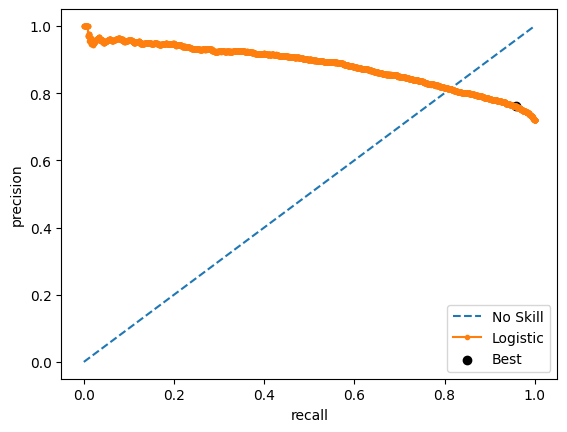

fold1 | grp0-4 | q1 Start...
Best Threshold=0.413076, F-Score=0.860335


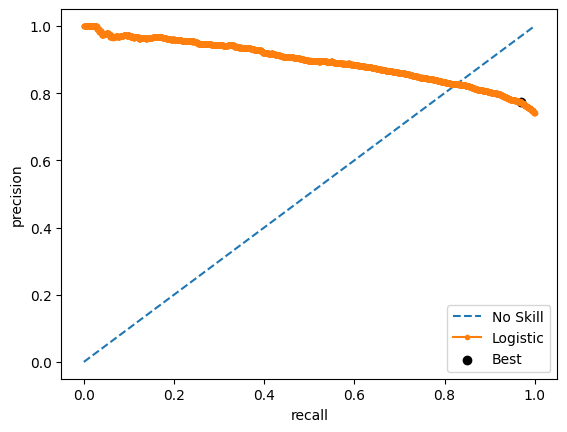

fold2 | grp0-4 | q1 Start...
Best Threshold=0.490222, F-Score=0.850874


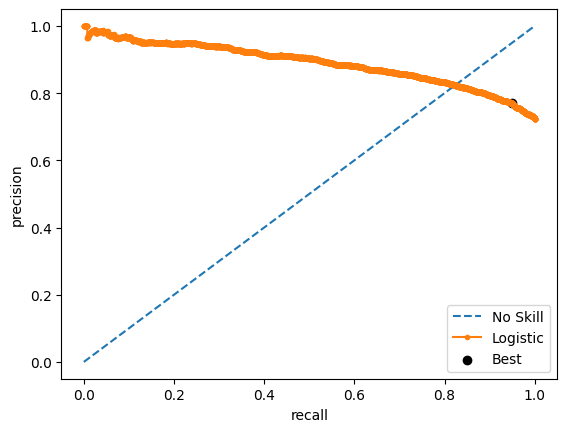

fold3 | grp0-4 | q1 Start...
Best Threshold=0.420804, F-Score=0.851417


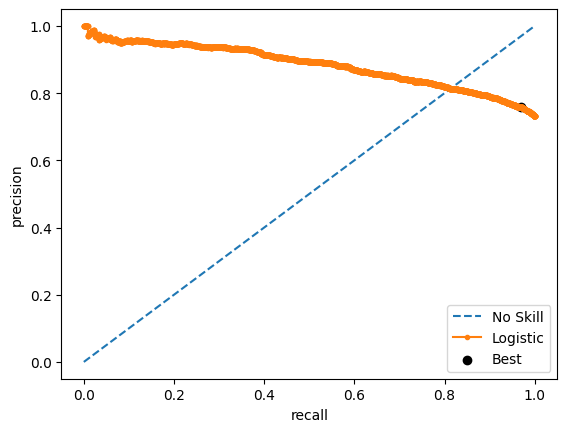

fold4 | grp0-4 | q1 Start...
Best Threshold=0.486851, F-Score=0.851490


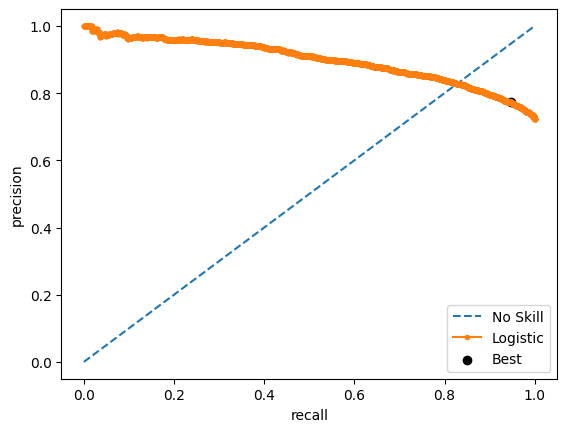

  6%|▌         | 1/18 [03:08<53:24, 188.53s/it]

0.9213699195475082
0-4 model f1_score: 0.9213699195475082
0.9863622216563394
0-4 model acc_score: 0.9863622216563394
fold0 | grp0-4 | q2 Start...
Best Threshold=0.310461, F-Score=0.988084


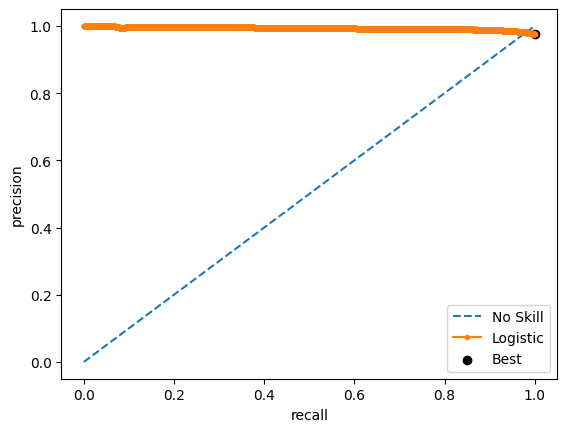

fold1 | grp0-4 | q2 Start...
Best Threshold=0.526176, F-Score=0.990035


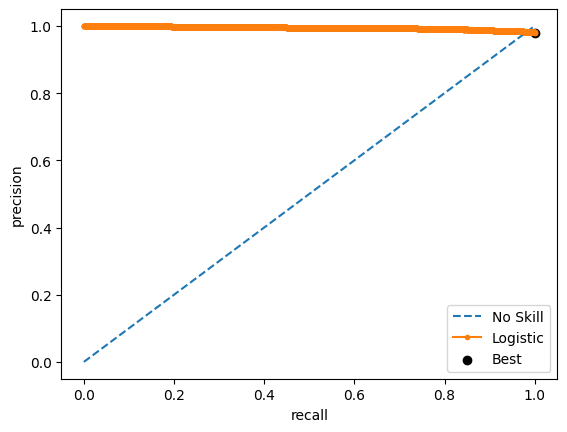

fold2 | grp0-4 | q2 Start...
Best Threshold=0.465145, F-Score=0.989812


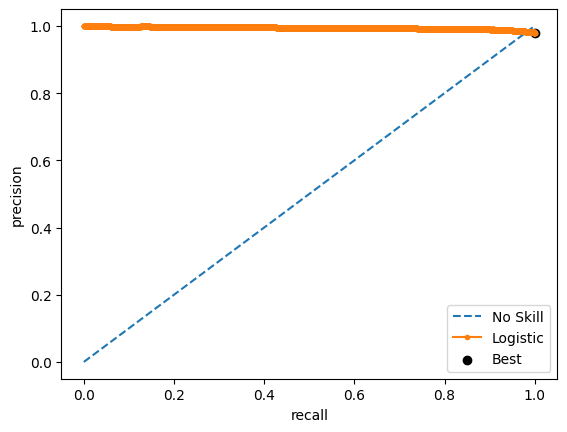

fold3 | grp0-4 | q2 Start...
Best Threshold=0.713014, F-Score=0.989810


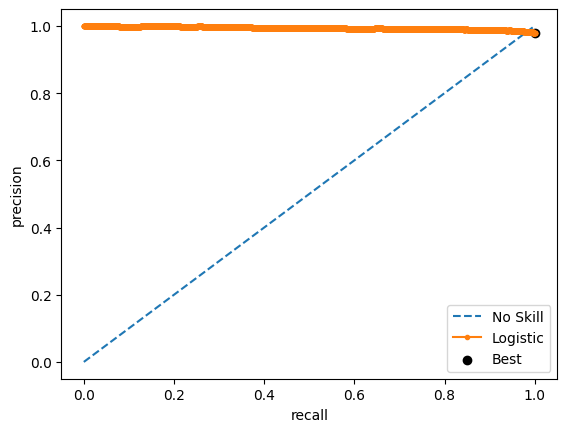

fold4 | grp0-4 | q2 Start...
Best Threshold=0.594911, F-Score=0.989487


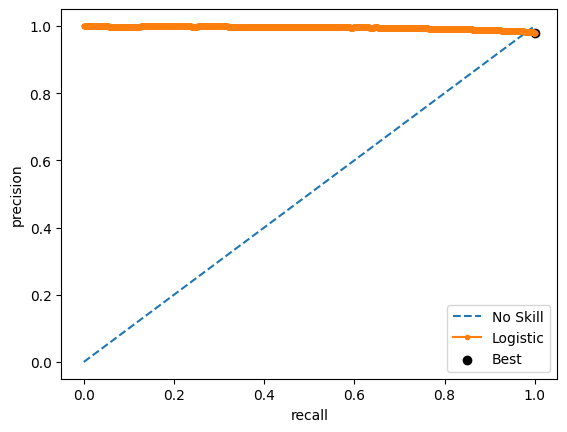

 11%|█         | 2/18 [05:30<43:01, 161.35s/it]

0.9943368574026196
0-4 model f1_score: 0.9943368574026196
0.9988234350979449
0-4 model acc_score: 0.9988234350979449
fold0 | grp0-4 | q3 Start...
Best Threshold=0.662434, F-Score=0.966725


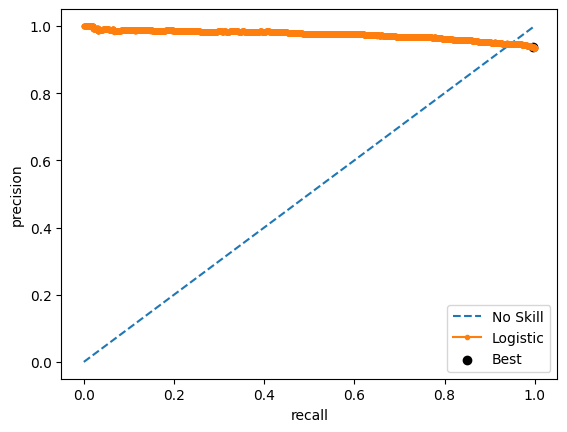

fold1 | grp0-4 | q3 Start...
Best Threshold=0.236784, F-Score=0.965986


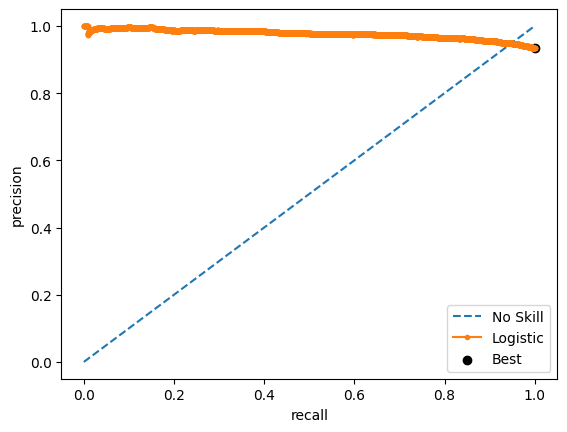

fold2 | grp0-4 | q3 Start...
Best Threshold=0.346131, F-Score=0.967904


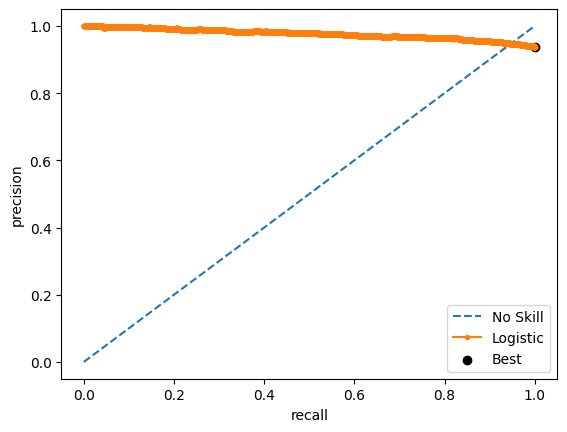

fold3 | grp0-4 | q3 Start...
Best Threshold=0.257485, F-Score=0.965646


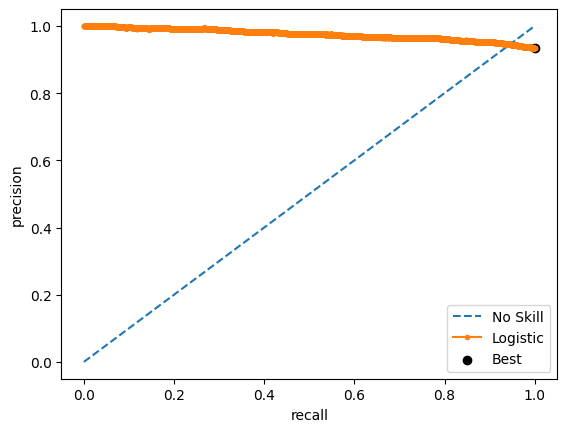

fold4 | grp0-4 | q3 Start...
Best Threshold=0.464389, F-Score=0.964584


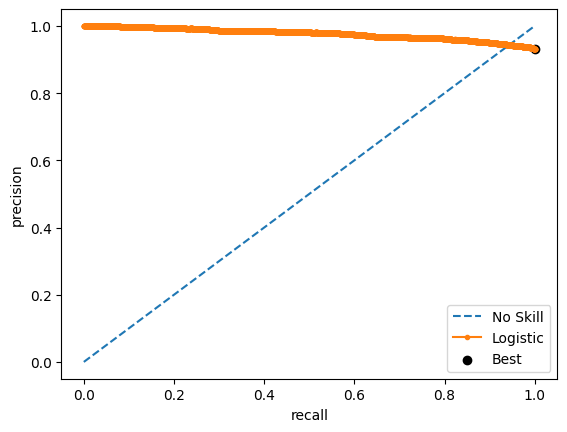

 17%|█▋        | 3/18 [08:11<40:15, 161.06s/it]

0.9819880281980088
0-4 model f1_score: 0.9819880281980088
0.9963382659461091
0-4 model acc_score: 0.9963382659461091
fold0 | grp5-12 | q4 Start...
Best Threshold=0.507152, F-Score=0.898554


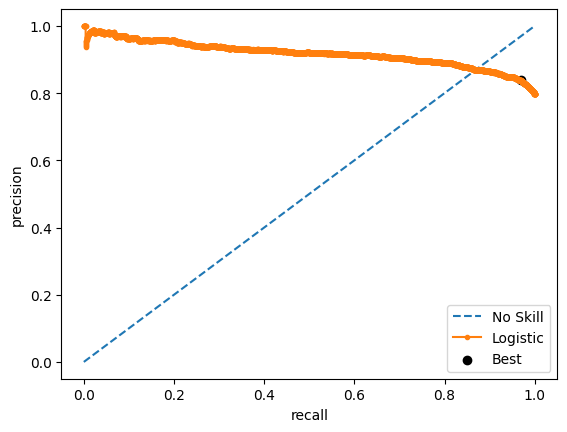

fold1 | grp5-12 | q4 Start...
Best Threshold=0.373245, F-Score=0.894756


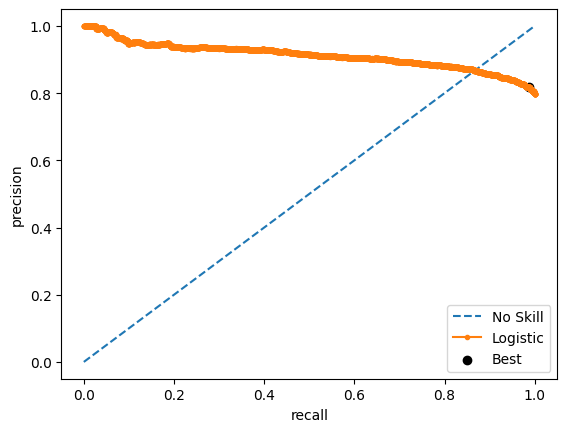

fold2 | grp5-12 | q4 Start...
Best Threshold=0.426893, F-Score=0.899915


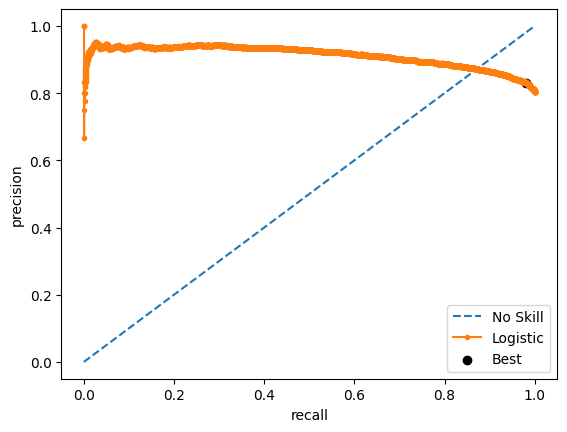

fold3 | grp5-12 | q4 Start...
Best Threshold=0.485372, F-Score=0.897493


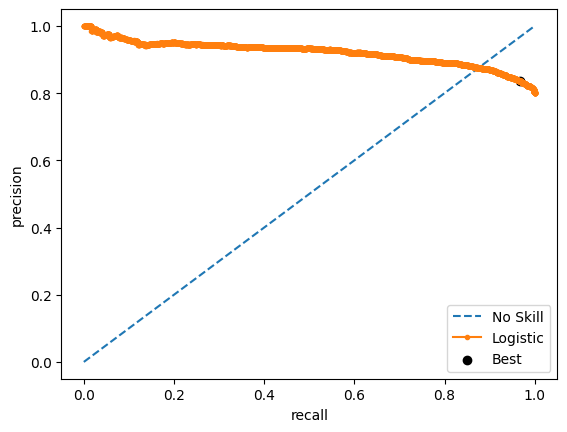

fold4 | grp5-12 | q4 Start...
Best Threshold=0.497397, F-Score=0.898458


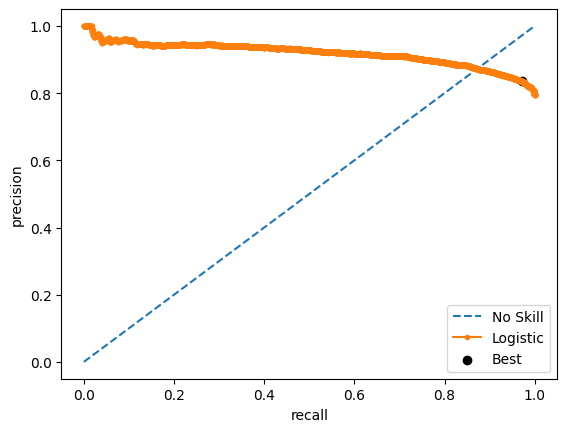

 22%|██▏       | 4/18 [11:47<42:37, 182.65s/it]

0.945903051379072
5-12 model f1_score: 0.945903051379072
0.9900734704656273
5-12 model acc_score: 0.9900734704656273
fold0 | grp5-12 | q5 Start...
Best Threshold=0.393837, F-Score=0.732727


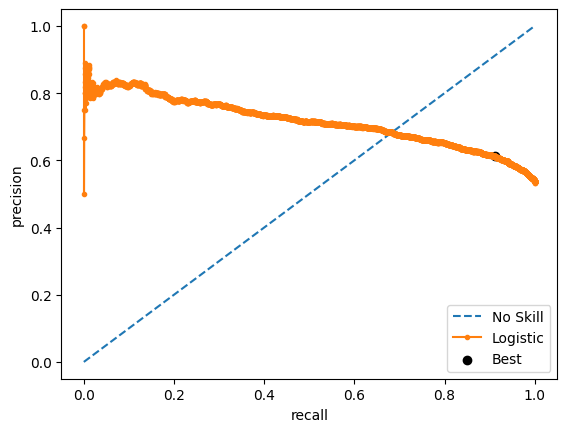

fold1 | grp5-12 | q5 Start...
Best Threshold=nan, F-Score=nan


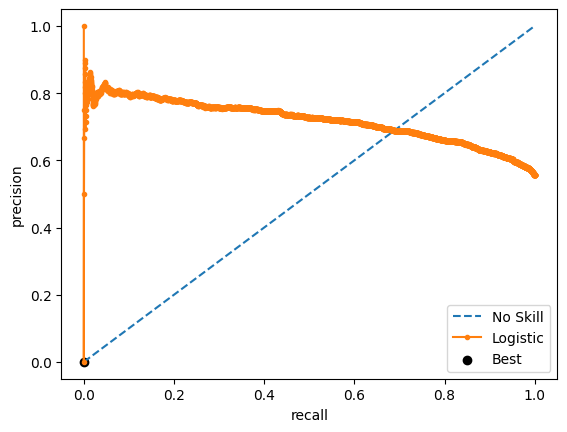

fold2 | grp5-12 | q5 Start...
Best Threshold=0.344736, F-Score=0.742140


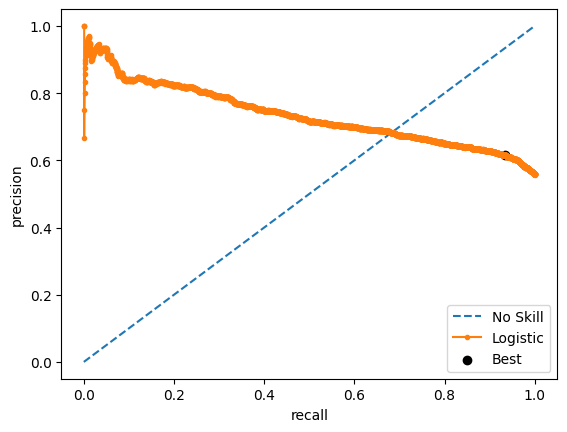

fold3 | grp5-12 | q5 Start...
Best Threshold=nan, F-Score=nan


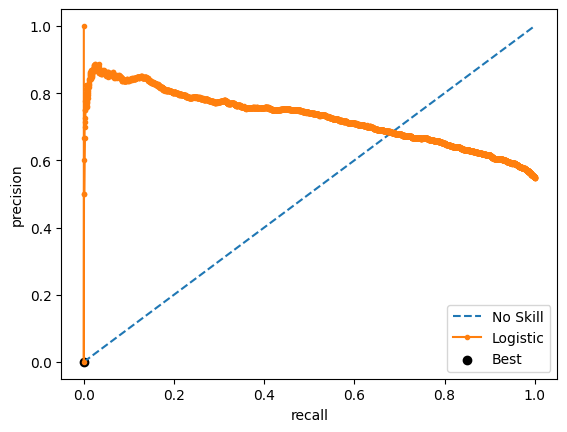

fold4 | grp5-12 | q5 Start...
Best Threshold=0.358303, F-Score=0.738257


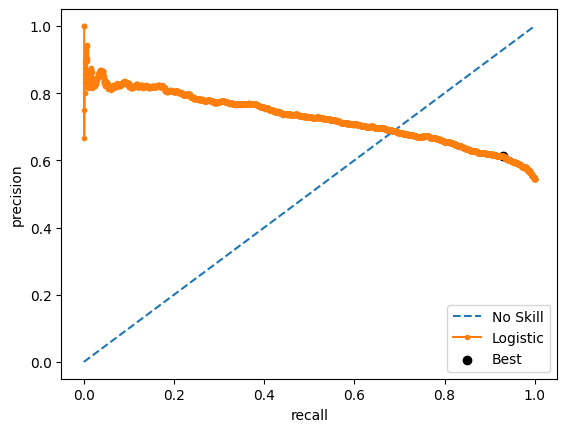

 28%|██▊       | 5/18 [16:14<46:10, 213.08s/it]

0.8508090872441654
5-12 model f1_score: 0.8508090872441654
0.9811089418932556
5-12 model acc_score: 0.9811089418932556
fold0 | grp5-12 | q6 Start...
Best Threshold=0.290364, F-Score=0.878260


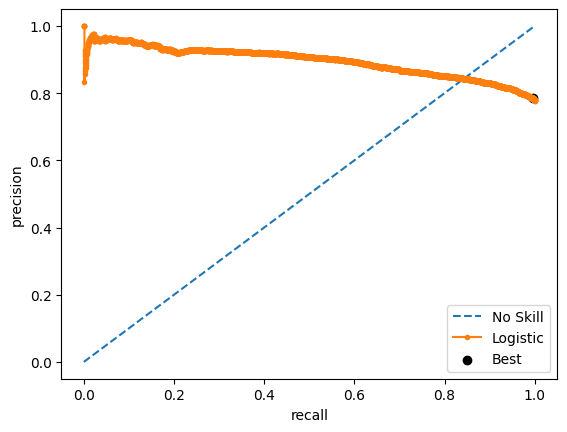

fold1 | grp5-12 | q6 Start...
Best Threshold=0.401112, F-Score=0.875764


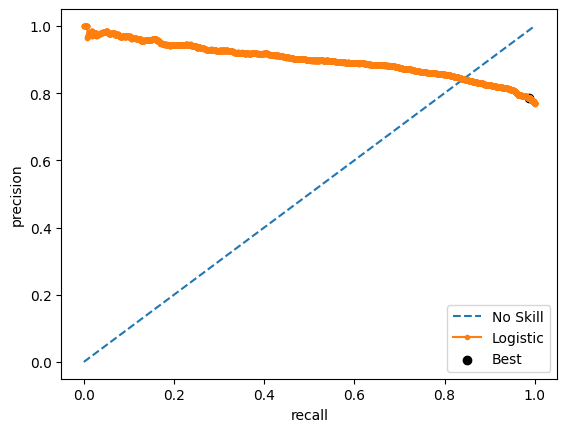

fold2 | grp5-12 | q6 Start...
Best Threshold=0.466441, F-Score=0.878862


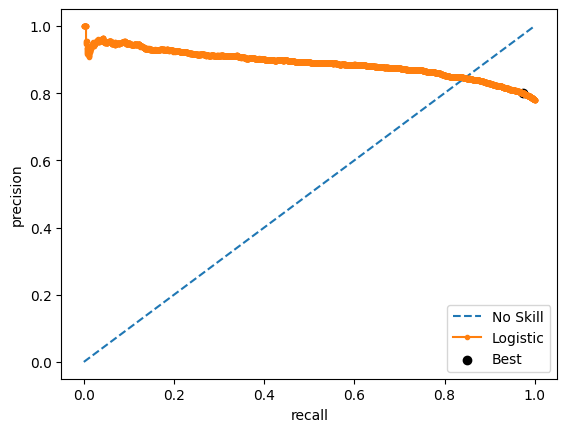

fold3 | grp5-12 | q6 Start...
Best Threshold=0.456187, F-Score=0.885880


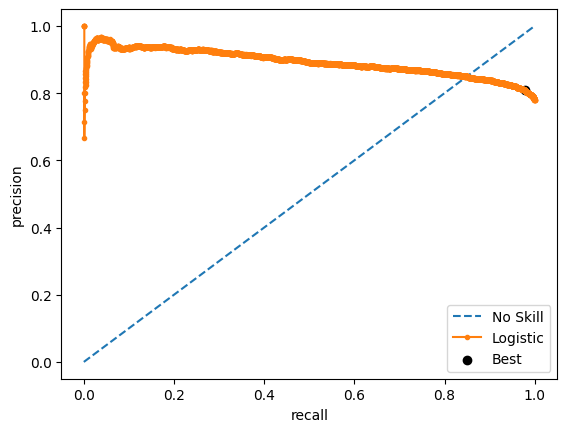

fold4 | grp5-12 | q6 Start...
Best Threshold=0.467280, F-Score=0.882586


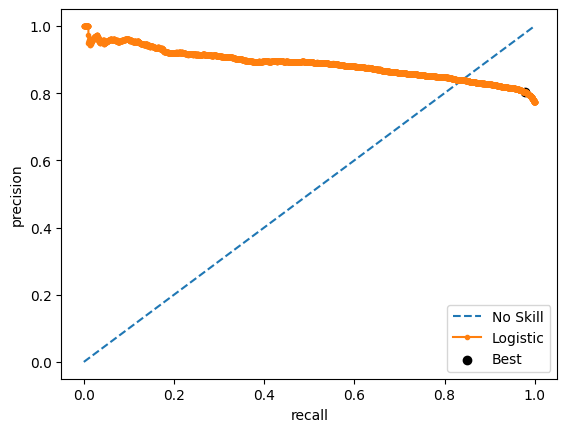

 33%|███▎      | 6/18 [20:08<44:04, 220.35s/it]

0.9363224737447395
5-12 model f1_score: 0.9363224737447395
0.988302728498807
5-12 model acc_score: 0.988302728498807
fold0 | grp5-12 | q7 Start...
Best Threshold=0.362248, F-Score=0.843101


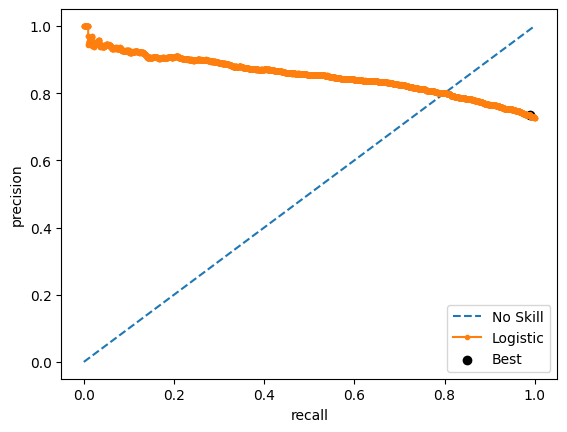

fold1 | grp5-12 | q7 Start...
Best Threshold=0.429543, F-Score=0.847853


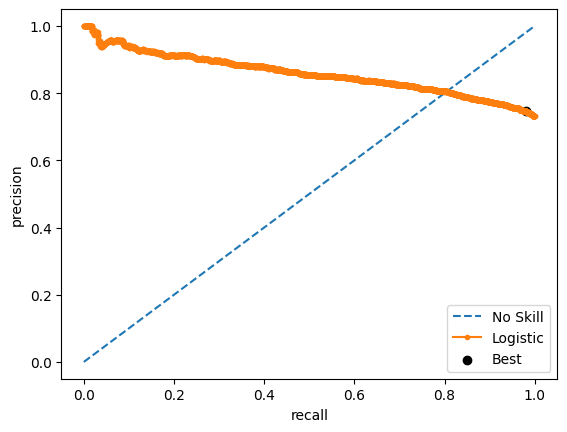

fold2 | grp5-12 | q7 Start...
Best Threshold=0.390703, F-Score=0.861418


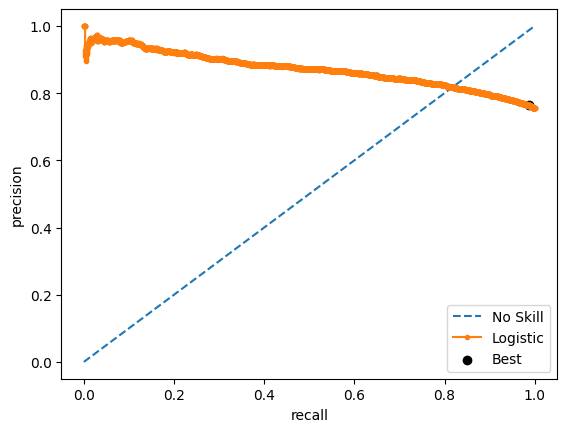

fold3 | grp5-12 | q7 Start...
Best Threshold=0.433527, F-Score=0.847082


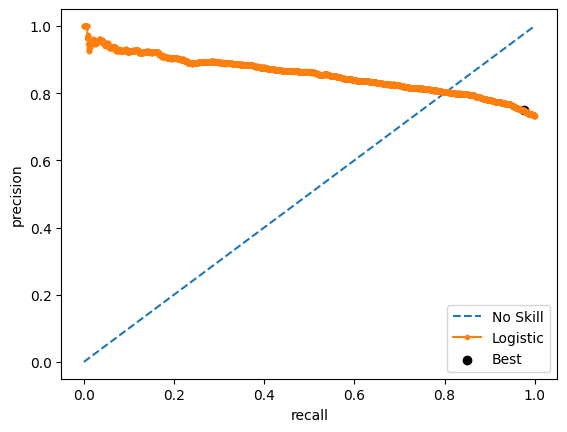

fold4 | grp5-12 | q7 Start...
Best Threshold=0.430603, F-Score=0.849969


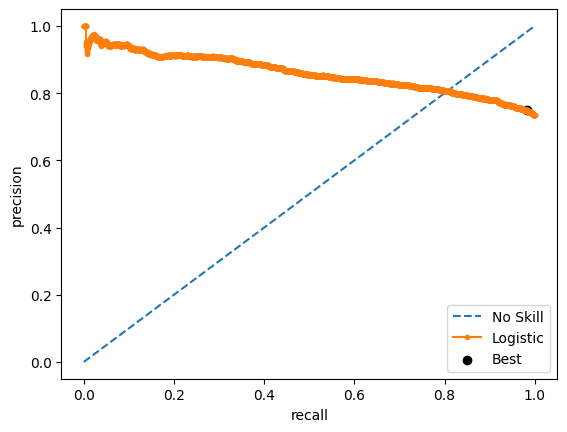

 39%|███▉      | 7/18 [24:14<41:53, 228.48s/it]

0.9206190016385174
5-12 model f1_score: 0.9206190016385174
0.9856831621537504
5-12 model acc_score: 0.9856831621537504
fold0 | grp5-12 | q8 Start...
Best Threshold=0.465219, F-Score=0.769914


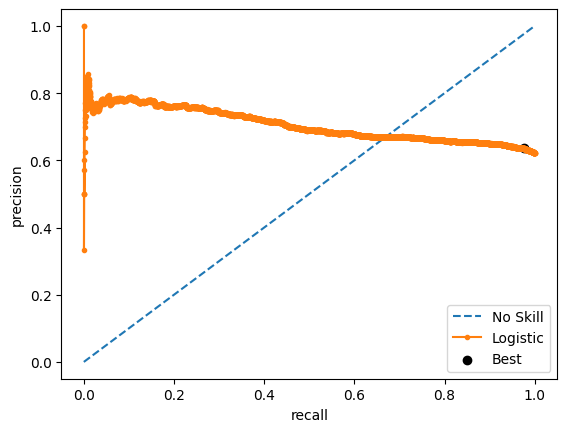

fold1 | grp5-12 | q8 Start...
Best Threshold=0.437697, F-Score=0.758019


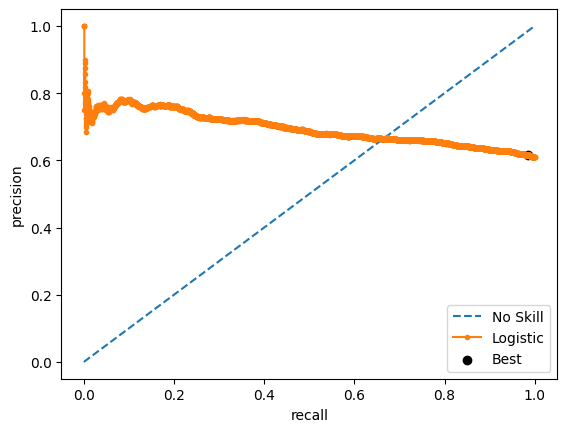

fold2 | grp5-12 | q8 Start...
Best Threshold=0.408579, F-Score=0.764768


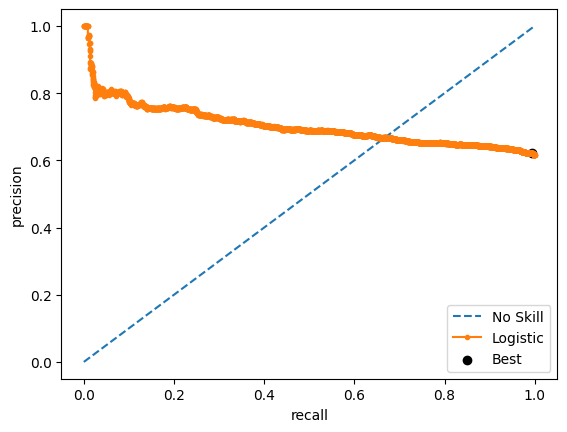

fold3 | grp5-12 | q8 Start...
Best Threshold=nan, F-Score=nan


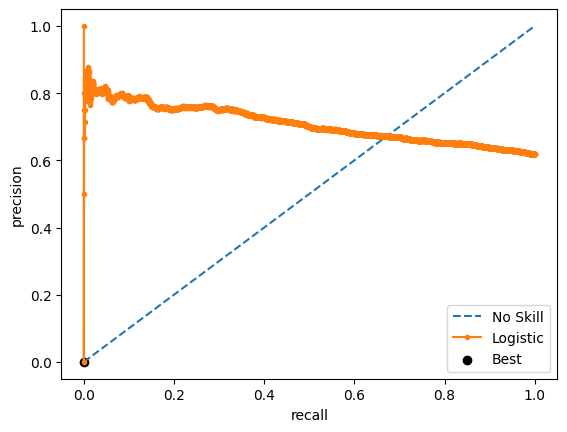

fold4 | grp5-12 | q8 Start...
Best Threshold=0.400738, F-Score=0.768149


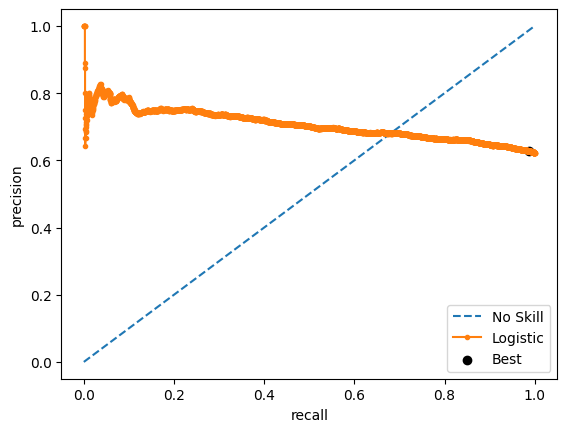

 44%|████▍     | 8/18 [27:07<35:09, 210.94s/it]

0.8750934924484743
5-12 model f1_score: 0.8750934924484743
0.9792698224070773
5-12 model acc_score: 0.9792698224070773
fold0 | grp5-12 | q9 Start...
Best Threshold=0.414341, F-Score=0.853564


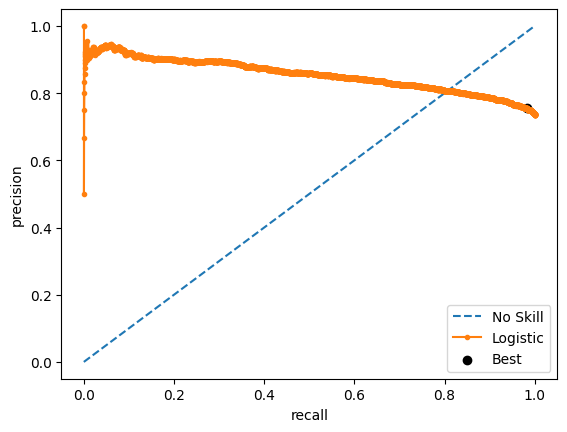

fold1 | grp5-12 | q9 Start...
Best Threshold=nan, F-Score=nan


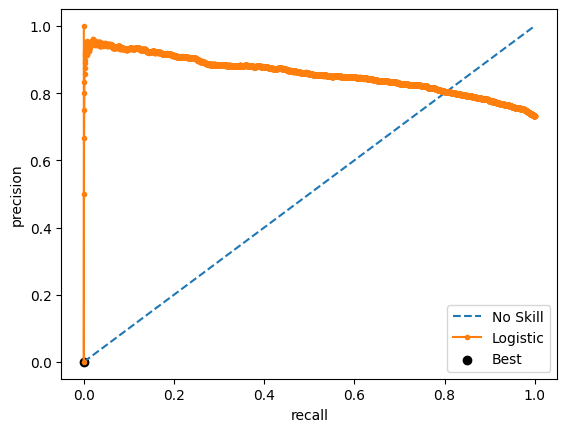

fold2 | grp5-12 | q9 Start...
Best Threshold=0.383994, F-Score=0.858880


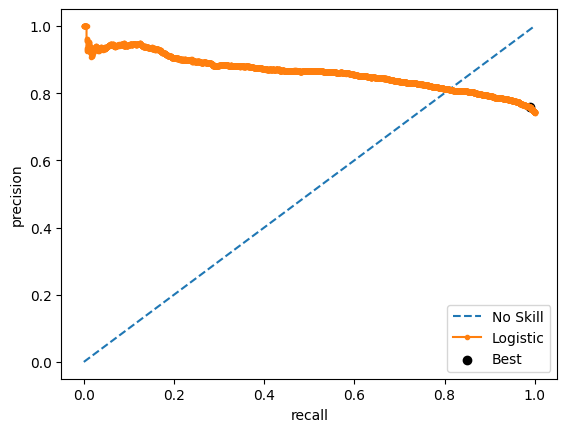

fold3 | grp5-12 | q9 Start...
Best Threshold=0.472117, F-Score=0.851264


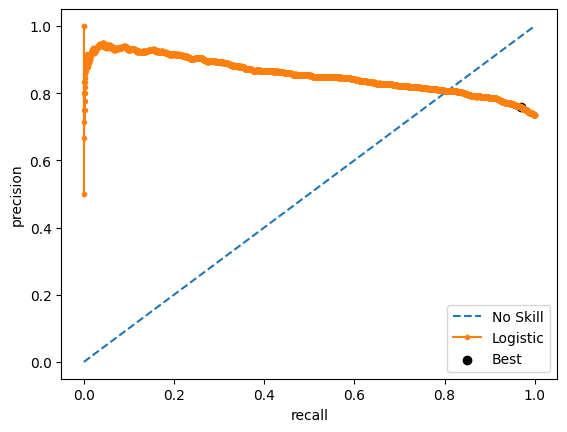

fold4 | grp5-12 | q9 Start...
Best Threshold=0.473434, F-Score=0.855153


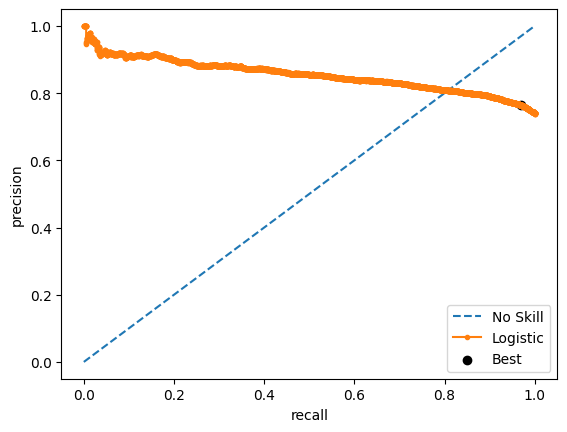

 50%|█████     | 9/18 [30:47<32:05, 213.92s/it]

0.922047926673827
5-12 model f1_score: 0.922047926673827
0.9862891284459911
5-12 model acc_score: 0.9862891284459911
fold0 | grp5-12 | q10 Start...
Best Threshold=0.342685, F-Score=0.706577


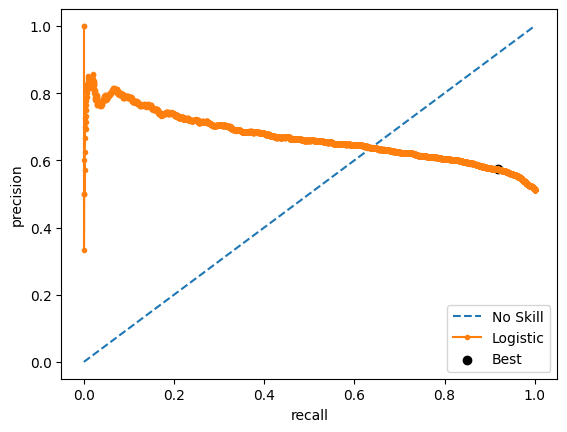

fold1 | grp5-12 | q10 Start...
Best Threshold=0.343034, F-Score=0.699301


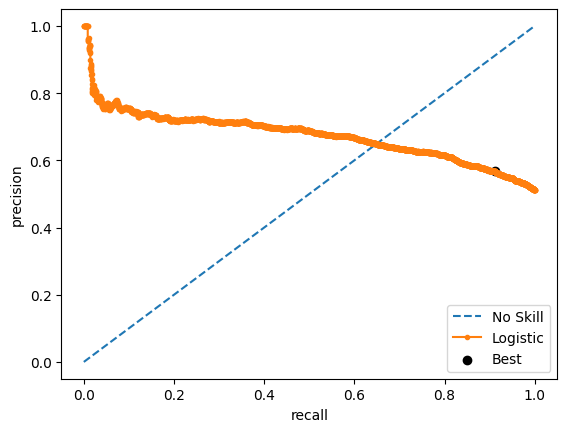

fold2 | grp5-12 | q10 Start...
Best Threshold=0.378243, F-Score=0.706984


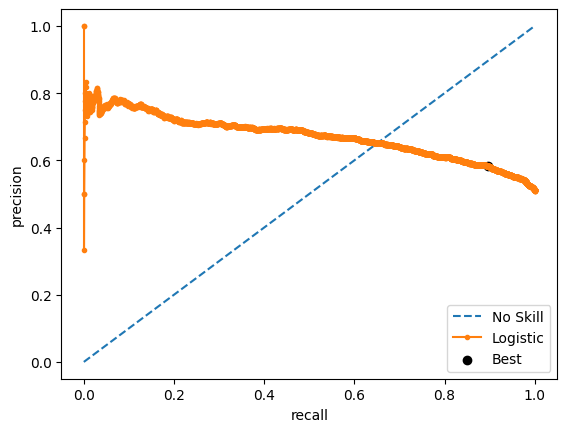

fold3 | grp5-12 | q10 Start...
Best Threshold=0.335921, F-Score=0.691918


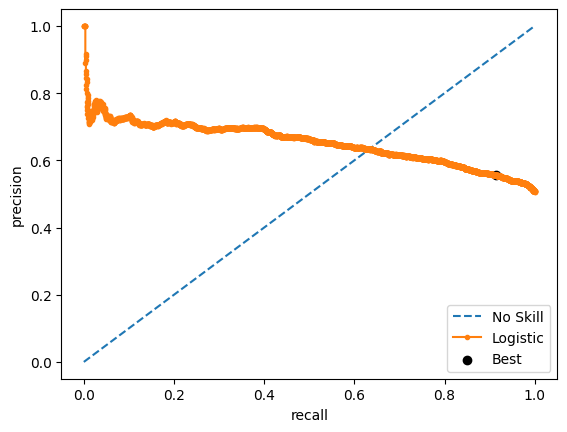

fold4 | grp5-12 | q10 Start...
Best Threshold=0.327520, F-Score=0.682048


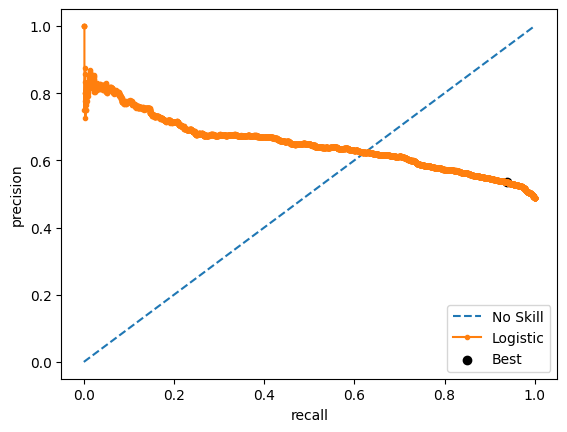

 56%|█████▌    | 10/18 [34:12<28:09, 211.17s/it]

0.8420007646269824
5-12 model f1_score: 0.8420007646269824
0.9775320902771883
5-12 model acc_score: 0.9775320902771883
fold0 | grp5-12 | q11 Start...
Best Threshold=nan, F-Score=nan


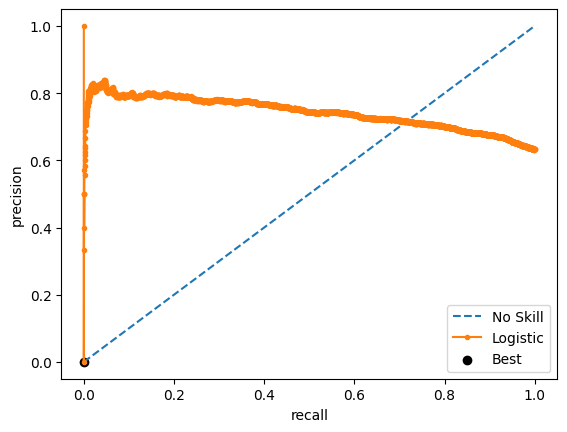

fold1 | grp5-12 | q11 Start...
Best Threshold=0.385617, F-Score=0.788281


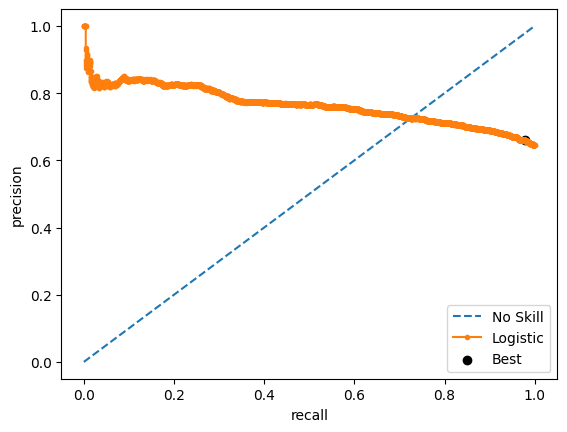

fold2 | grp5-12 | q11 Start...
Best Threshold=0.414036, F-Score=0.792907


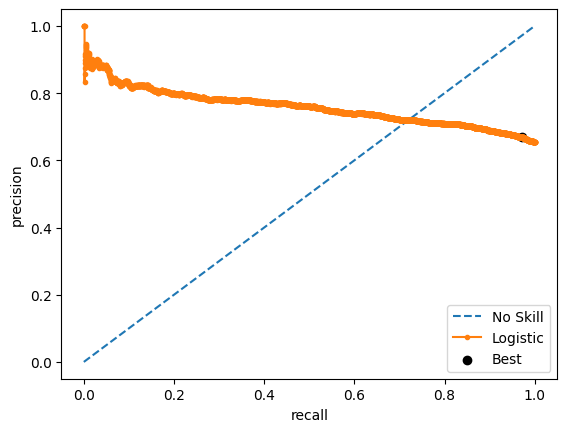

fold3 | grp5-12 | q11 Start...
Best Threshold=0.359746, F-Score=0.784520


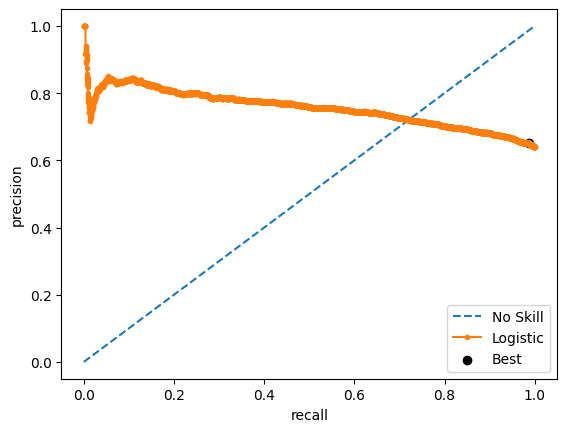

fold4 | grp5-12 | q11 Start...
Best Threshold=0.394598, F-Score=0.788699


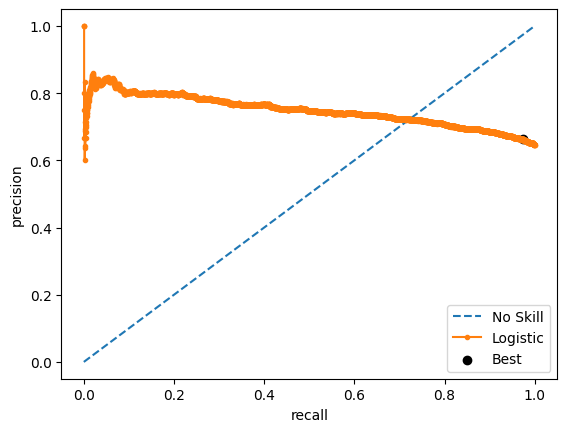

 61%|██████    | 11/18 [37:36<24:22, 208.87s/it]

0.887283765391768
5-12 model f1_score: 0.887283765391768
0.9812551283139519
5-12 model acc_score: 0.9812551283139519
fold0 | grp5-12 | q12 Start...
Best Threshold=0.254286, F-Score=0.925812


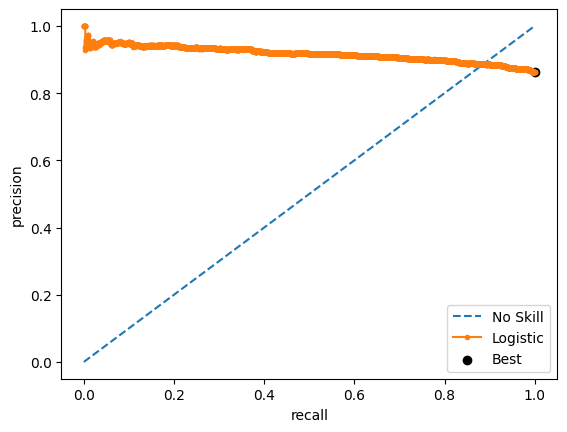

fold1 | grp5-12 | q12 Start...
Best Threshold=0.365457, F-Score=0.930988


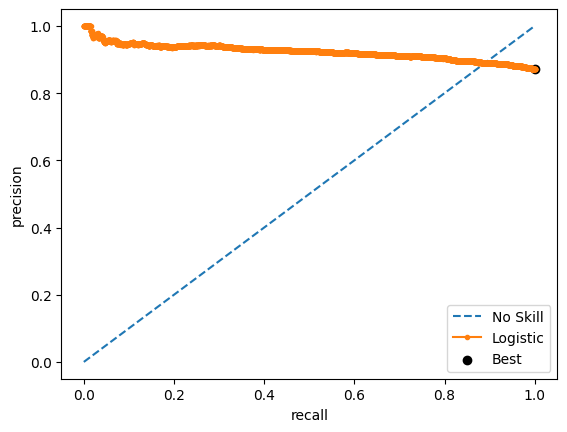

fold2 | grp5-12 | q12 Start...
Best Threshold=0.434625, F-Score=0.924746


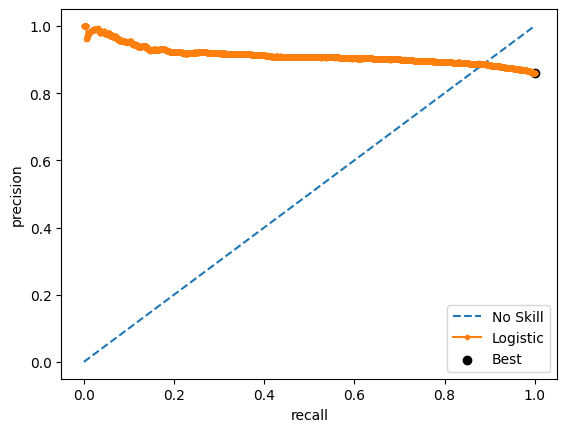

fold3 | grp5-12 | q12 Start...
Best Threshold=0.298263, F-Score=0.927368


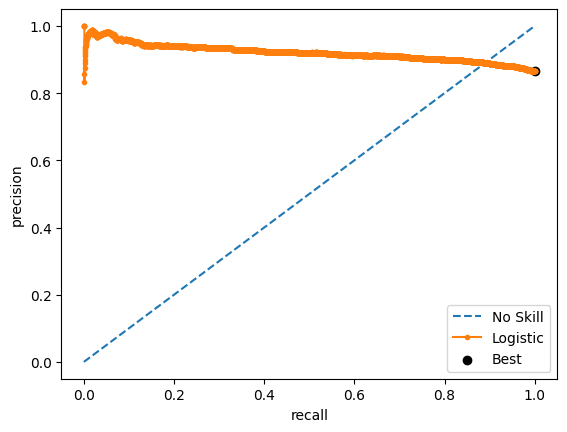

fold4 | grp5-12 | q12 Start...
Best Threshold=nan, F-Score=nan


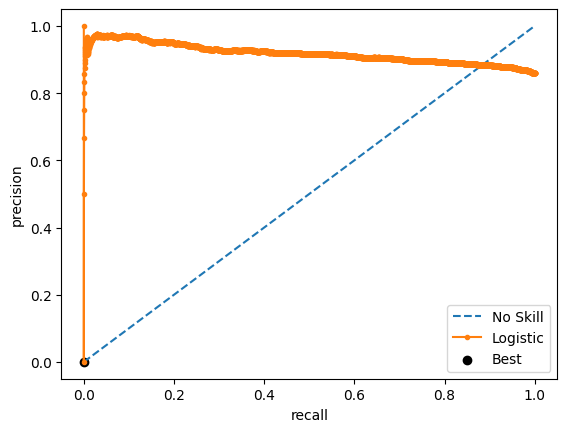

 67%|██████▋   | 12/18 [41:15<21:12, 212.06s/it]

0.9611990537714061
5-12 model f1_score: 0.9611990537714061
0.992391232587311
5-12 model acc_score: 0.992391232587311
fold0 | grp5-12 | q13 Start...
Best Threshold=0.250700, F-Score=0.508278


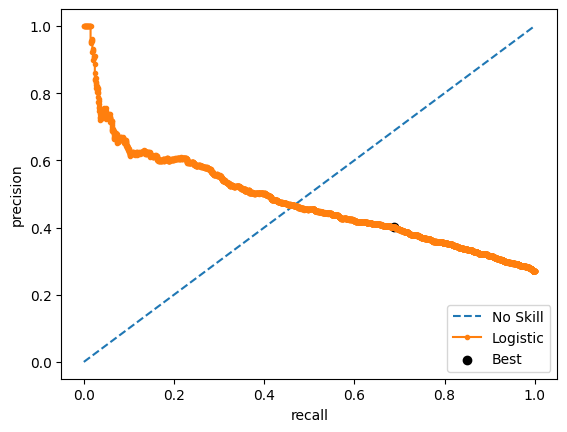

fold1 | grp5-12 | q13 Start...
Best Threshold=0.229366, F-Score=0.529504


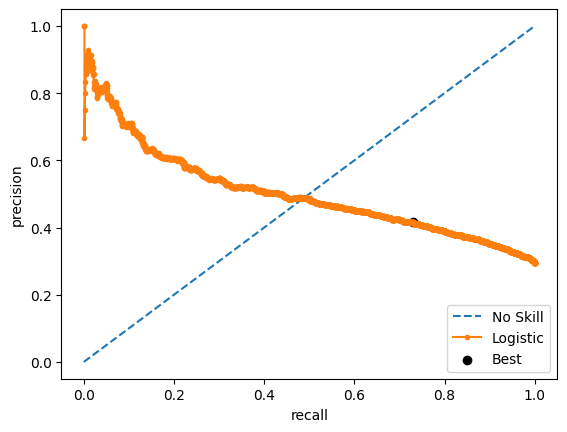

fold2 | grp5-12 | q13 Start...
Best Threshold=0.236186, F-Score=0.501641


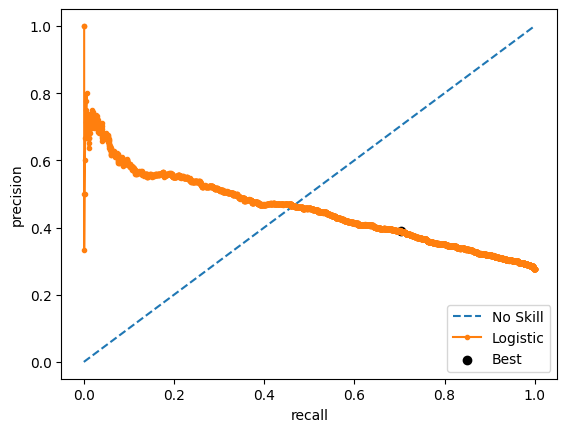

fold3 | grp5-12 | q13 Start...
Best Threshold=0.307773, F-Score=0.493922


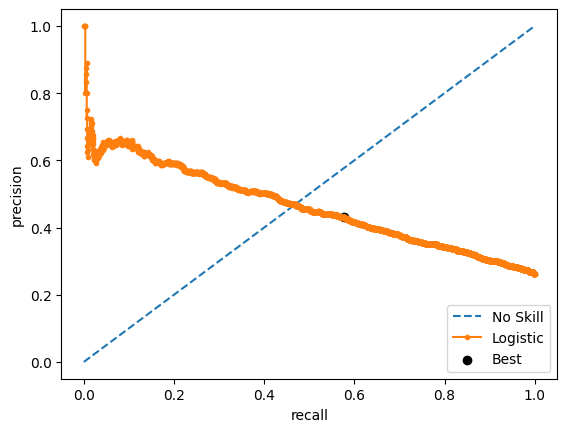

fold4 | grp5-12 | q13 Start...
Best Threshold=0.273438, F-Score=0.504142


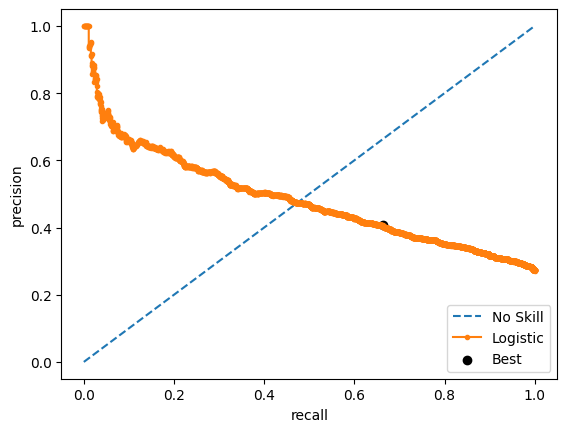

 72%|███████▏  | 13/18 [45:38<18:56, 227.24s/it]

0.7460518248756606
5-12 model f1_score: 0.7460518248756606
0.9798946514632789
5-12 model acc_score: 0.9798946514632789
fold0 | grp13-22 | q14 Start...
Best Threshold=0.399453, F-Score=0.840449


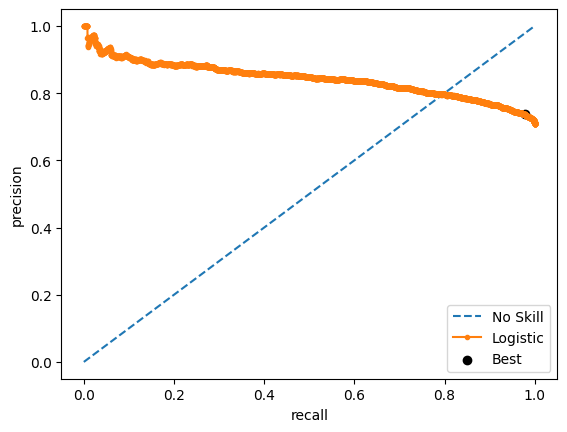

fold1 | grp13-22 | q14 Start...
Best Threshold=0.400247, F-Score=0.841406


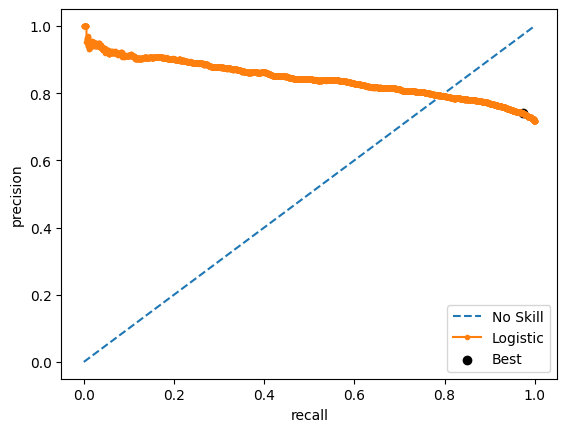

fold2 | grp13-22 | q14 Start...
Best Threshold=0.355549, F-Score=0.846553


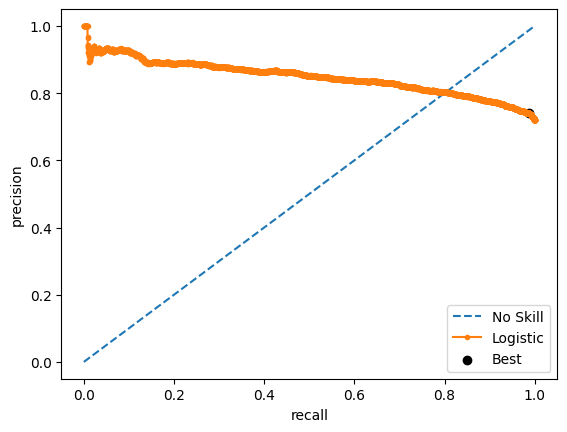

fold3 | grp13-22 | q14 Start...
Best Threshold=0.432897, F-Score=0.831311


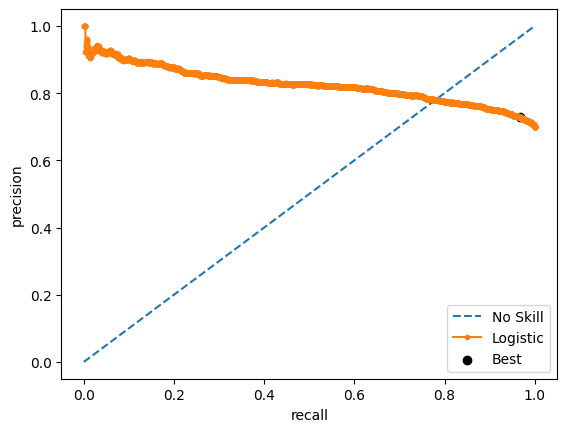

fold4 | grp13-22 | q14 Start...
Best Threshold=0.323482, F-Score=0.830883


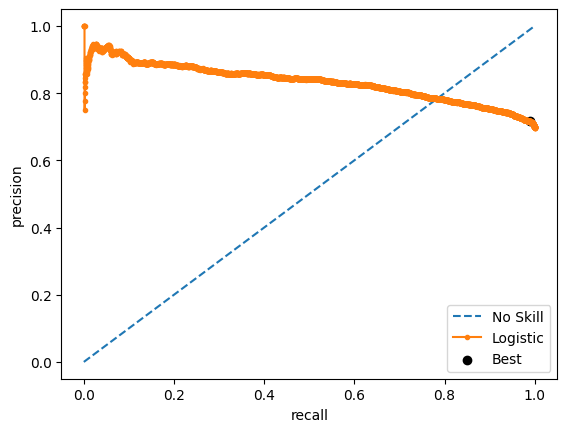

 78%|███████▊  | 14/18 [49:46<15:34, 233.57s/it]

0.9144243795826926
13-22 model f1_score: 0.9144243795826926
0.9849852398872007
13-22 model acc_score: 0.9849852398872007
fold0 | grp13-22 | q15 Start...
Best Threshold=0.369314, F-Score=0.694729


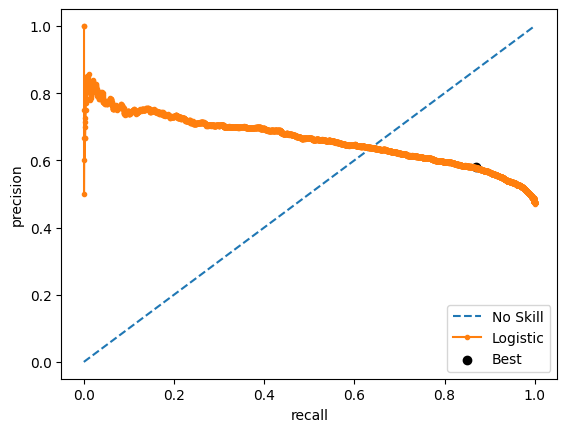

fold1 | grp13-22 | q15 Start...
Best Threshold=0.321801, F-Score=0.698349


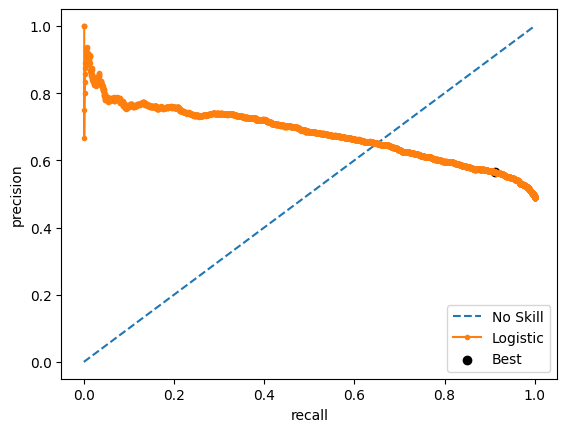

fold2 | grp13-22 | q15 Start...
Best Threshold=0.354473, F-Score=0.704706


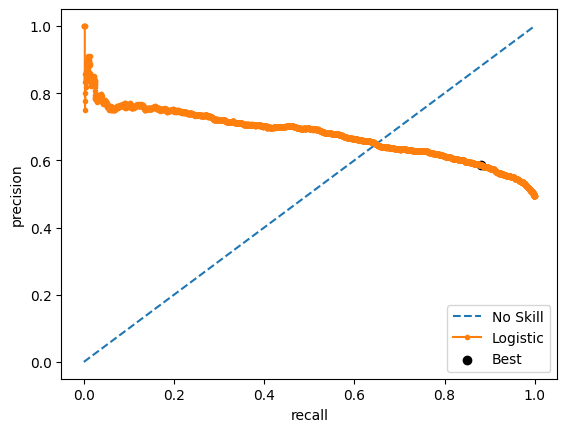

fold3 | grp13-22 | q15 Start...
Best Threshold=0.333458, F-Score=0.688334


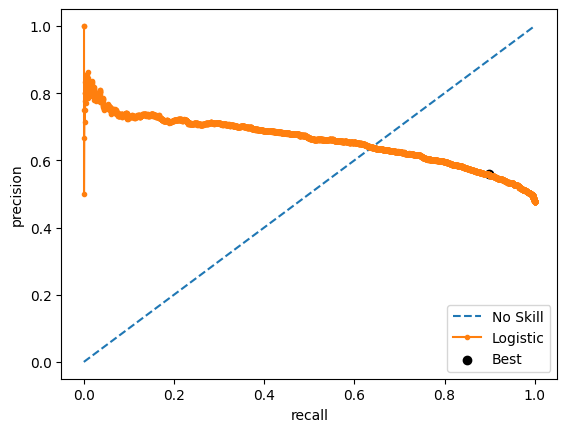

fold4 | grp13-22 | q15 Start...
Best Threshold=0.343254, F-Score=0.699361


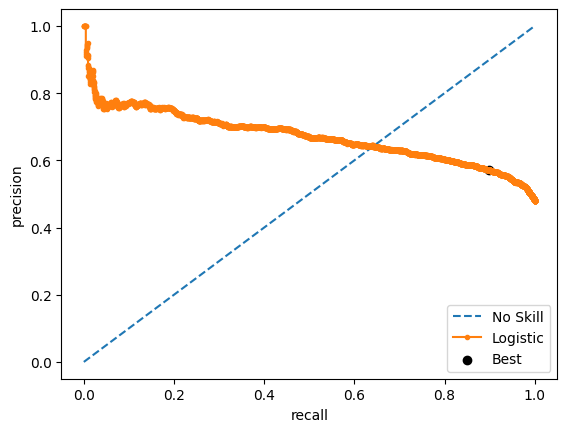

 83%|████████▎ | 15/18 [54:21<12:18, 246.02s/it]

0.8424239674619638
13-22 model f1_score: 0.8424239674619638
0.9791825821237586
13-22 model acc_score: 0.9791825821237586
fold0 | grp13-22 | q16 Start...
Best Threshold=0.465353, F-Score=0.842118


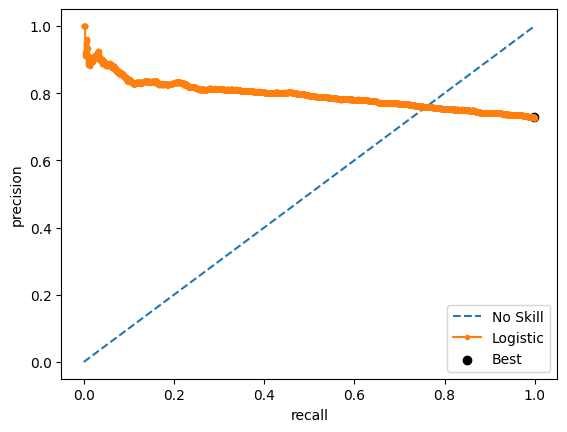

fold1 | grp13-22 | q16 Start...
Best Threshold=0.458224, F-Score=0.861084


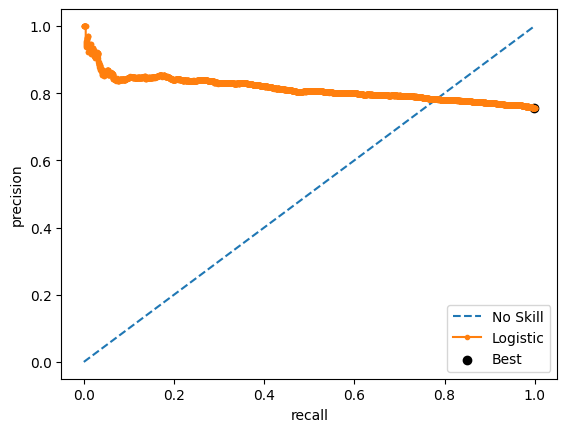

fold2 | grp13-22 | q16 Start...
Best Threshold=nan, F-Score=nan


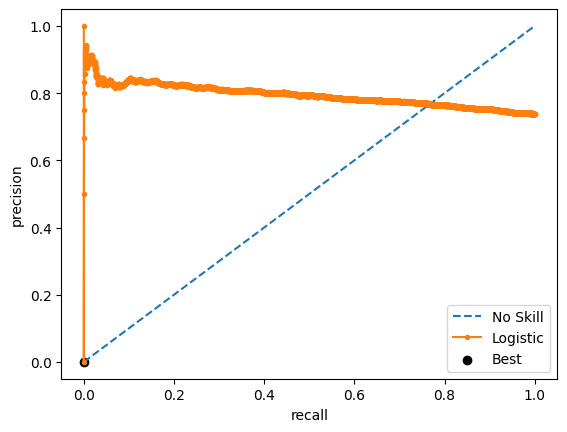

fold3 | grp13-22 | q16 Start...
Best Threshold=0.473682, F-Score=0.843024


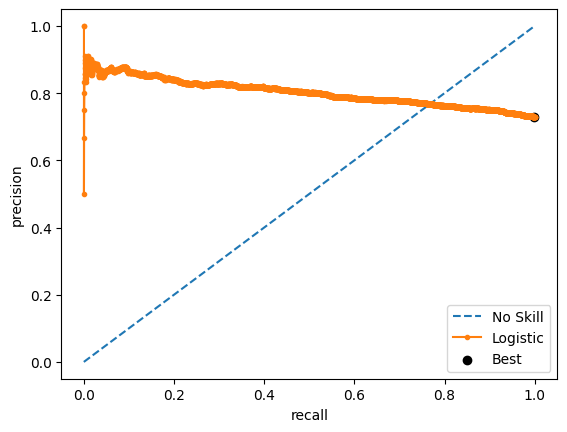

fold4 | grp13-22 | q16 Start...
Best Threshold=0.413964, F-Score=0.841510


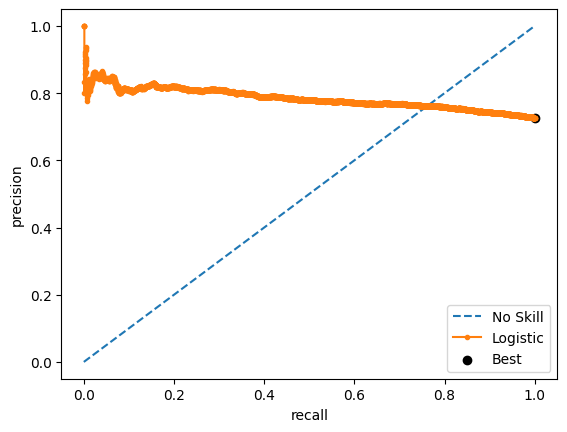

 89%|████████▉ | 16/18 [58:05<07:58, 239.38s/it]

0.919530467152698
13-22 model f1_score: 0.919530467152698
0.9852870441105736
13-22 model acc_score: 0.9852870441105736
fold0 | grp13-22 | q17 Start...
Best Threshold=0.444978, F-Score=0.803512


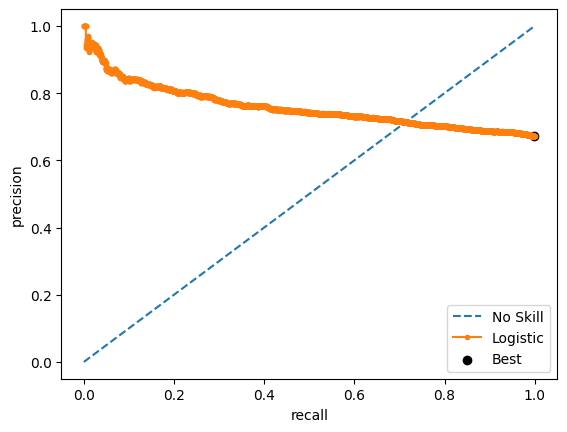

fold1 | grp13-22 | q17 Start...
Best Threshold=0.385683, F-Score=0.818763


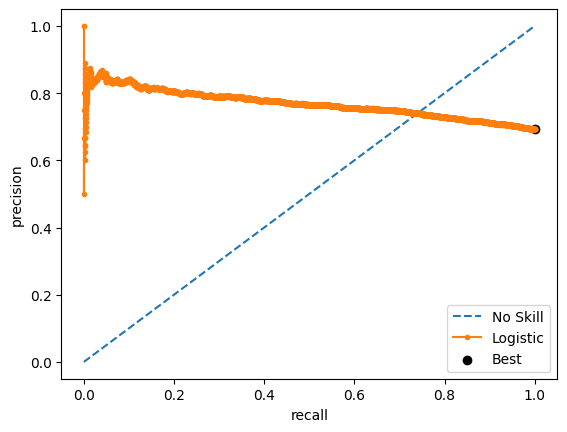

fold2 | grp13-22 | q17 Start...
Best Threshold=0.481530, F-Score=0.820506


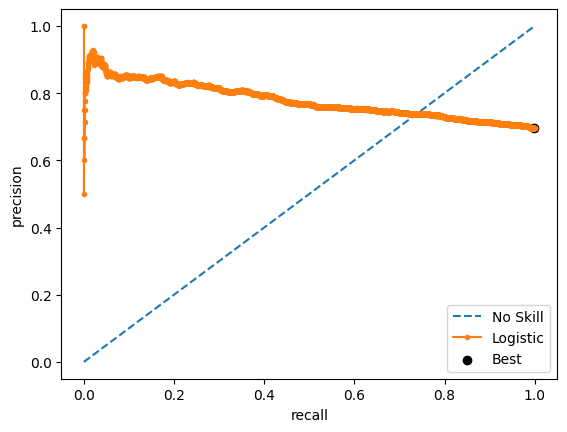

fold3 | grp13-22 | q17 Start...
Best Threshold=0.461732, F-Score=0.818216


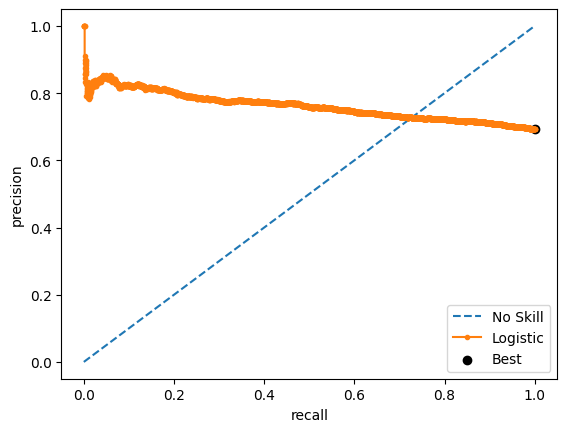

fold4 | grp13-22 | q17 Start...
Best Threshold=0.496069, F-Score=0.815853


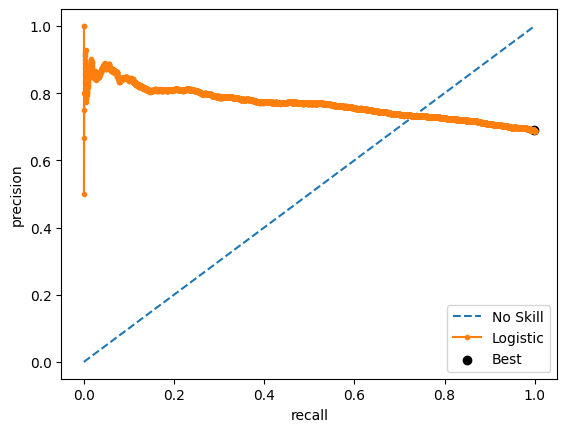

 94%|█████████▍| 17/18 [1:01:12<03:43, 223.76s/it]

0.9027937225896585
13-22 model f1_score: 0.9027937225896585
0.9826509728470513
13-22 model acc_score: 0.9826509728470513
fold0 | grp13-22 | q18 Start...
Best Threshold=0.548827, F-Score=0.973521


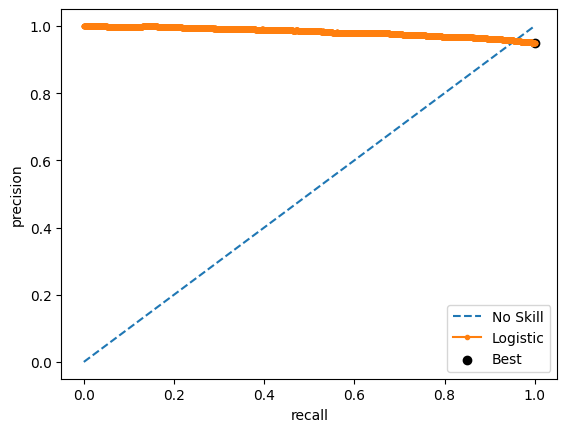

fold1 | grp13-22 | q18 Start...
Best Threshold=0.387819, F-Score=0.974543


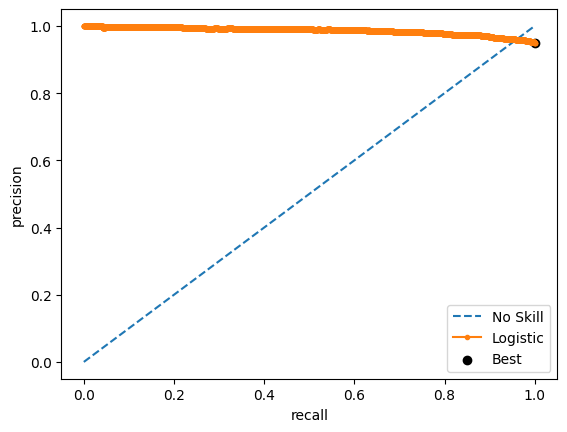

fold2 | grp13-22 | q18 Start...
Best Threshold=0.392106, F-Score=0.974867


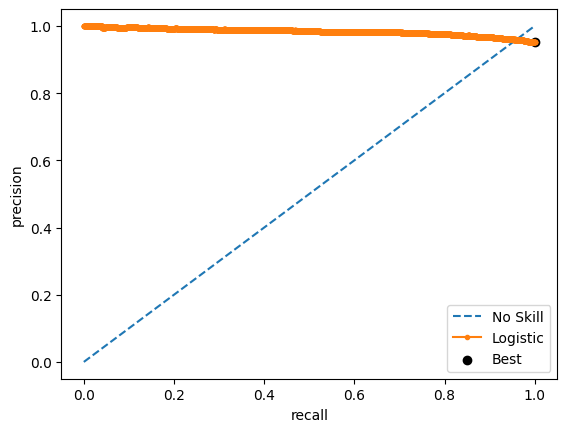

fold3 | grp13-22 | q18 Start...
Best Threshold=0.426496, F-Score=0.975758


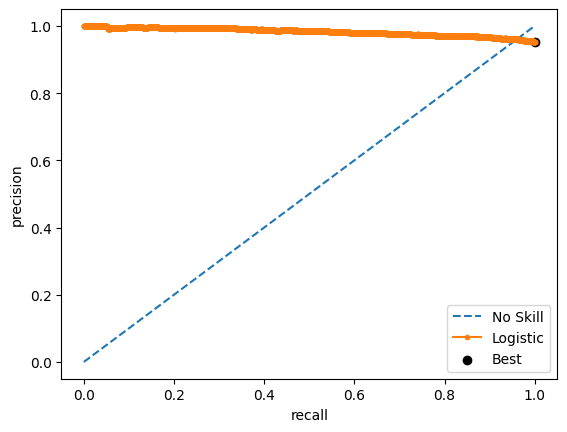

fold4 | grp13-22 | q18 Start...
Best Threshold=0.595516, F-Score=0.975302


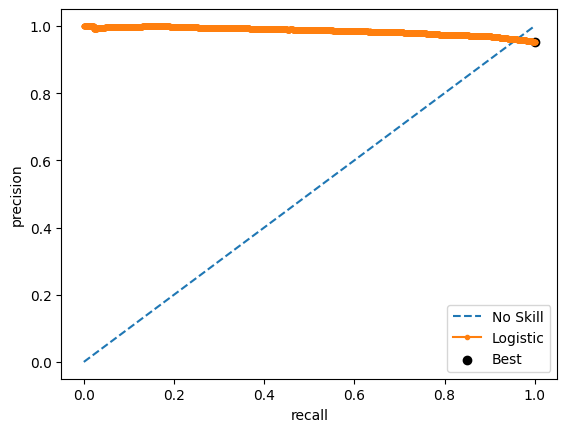

100%|██████████| 18/18 [1:05:05<00:00, 216.97s/it]

0.9866198581537777
13-22 model f1_score: 0.9866198581537777
0.9972578256891982
13-22 model acc_score: 0.9972578256891982
model total f1_score: 0.908378757882419
model total acc_score: 0.9862604413258009


In [32]:
# feature_importance_df = pd.DataFrame()
best_thresholds_grp = {}
#importance_dict = {}
f1s = []
accs = []
for q in tqdm(range(1, 19)):
    if q <= 3:
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1
    elif q <= 13:
        grp = '5-12'
        df = df2
        FEATURES = FEATURES2
    elif q <= 22:
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3

    #data_dir = '/kaggle/input/features/'
    #f_read = open(data_dir + f'importance_dict_1_18.pkl', 'rb')
    #importance_dict = pickle.load(f_read)
    #f_read.close()
    
    #FEATURES = importance_dict[str(q)] + ['question_mark_count']
        
    models = {}
    pred_oof = pd.DataFrame(data=np.zeros((len(df1.index.unique()),18)), index = df1.index.unique())
    val_oof = pd.DataFrame(data=np.zeros((len(df1.index.unique()),18)), index = df1.index.unique())
    best_thresholds = []
    n_folds = 5
    gkf = GroupKFold(n_splits = n_folds)
    
    for fold, (train_idx, valid_idx) in enumerate(gkf.split(X = df[FEATURES], groups = df.index)):
        print(f'fold{fold} | grp{grp} | q{q} Start...')
        X_train = df.iloc[train_idx]
        train_users = X_train.index.values
        y_train = train_labels.loc[train_labels.q == q].set_index('session').loc[train_users]
        
        X_valid = df.iloc[valid_idx]
        valid_users = X_valid.index.values
        y_valid = train_labels.loc[train_labels.q == q].set_index('session').loc[valid_users]
        
        #train_labels['correct']
        #weight = compute_class_weight(class_weight = 'balanced', classes=np.unique(train_labels['correct']), y = train_labels['correct'])
        #class_weight = {i:weight[i] for i in range(len(weight))}
        
        #classes = np.unique(train_labels['correct'])
        #weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_labels['correct'])
        #class_weights = dict(zip(classes, weights))
        
        #class_weight = CreateBalancedSampleWeights(y_train['correct'], largest_class_weight_coef=1)

        train_pool = Pool(X_train.astype('float32'), y_train['correct'])
        valid_pool = Pool(X_valid.astype('float32'), y_valid['correct'])
            
        cat = CatBoostClassifier(iterations = 600, random_seed = SEED, task_type = 'GPU') #, class_weights = class_weights
        cat = cat.fit(train_pool, eval_set = valid_pool, early_stopping_rounds = 75, verbose = 0)
        #joblib.dump(model, f'catboost_fold{fold}_grp{grp}_q{q}')
        #pickle.dump(model, f'catboost_fold{fold}_grp{grp}_q{q}')
        cat.save_model(f'cats/catboost_fold{fold}_grp{grp}_q{q}') # , format="cbm"
        #model.save(f'catboost_fold{fold}_grp{grp}_q{q}')
        cat_pred = cat.predict_proba(X_valid)[:, 1]
        
        xgb = XGBClassifier(n_estimators= 600, random_state = SEED, tree_method='gpu_hist') #, class_weights = class_weights
        xgb = xgb.fit(X_train.astype('float32'), y_train['correct'], eval_set = [(X_valid.astype('float32'), y_valid['correct'])], early_stopping_rounds = 75, verbose = 0)
        #joblib.dump(model, f'catboost_fold{fold}_grp{grp}_q{q}')
        #pickle.dump(model, f'catboost_fold{fold}_grp{grp}_q{q}')
        xgb.save_model(f'xgbs/xgbboost_fold{fold}_grp{grp}_q{q}') # , format="cbm"
        #model.save(f'catboost_fold{fold}_grp{grp}_q{q}')
        xgb_pred = xgb.predict_proba(X_valid)[:, 1]
        
        y_pred = cat_pred * 0.93 + xgb_pred * 0.07
        
#         fold_importance_df = pd.DataFrame()
#         fold_importance_df['feature'] = FEATURES
#         fold_importance_df['importance'] = METAMODEL.feature_importances_
#         fold_importance_df['fold'] = fold + 1
#         feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis = 0)
        
        val_oof.loc[valid_users, q-1] = y_valid['correct']
        pred_oof.loc[valid_users, q-1] = y_pred

        precision, recall, threshold = precision_recall_curve(y_valid['correct'], y_pred)
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.argmax(fscore)
        best_threshold = threshold[ix]
        best_thresholds.append(best_threshold)
        
        if fscore[ix] > 0.0:
            best_threshold = threshold[ix]
            best_thresholds.append(best_threshold)
        else:
            best_threshold = np.nan
        
        print('Best Threshold=%f, F-Score=%f' % (best_threshold, fscore[ix]))

        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
        plt.plot(recall, precision, marker='.', label='Logistic')
        plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
        plt.xlabel('recall')
        plt.ylabel('precision')
        plt.legend()
        plt.show()

    pred_list = []
    best_thresholds_mean = np.mean(best_thresholds)
    best_thresholds_grp[f'{grp}_{q}'] = best_thresholds_mean
    
    pred = (pred_oof.values.reshape((-1)) > best_thresholds_mean).astype(int)
    pred_list.append(pred)

    f1 = f1_score(val_oof.values.reshape((-1)), pred, average = 'macro')
    f1s.append(f1)
    acc = accuracy_score(val_oof.values.reshape((-1)), pred)
    accs.append(acc)
    print(f1)
    print(f'{grp} model f1_score:',np.mean(f1))
    print(acc)
    print(f'{grp} model acc_score:',np.mean(acc))
    
print('model total f1_score:', np.mean(f1s))
print('model total acc_score:', np.mean(accs))    
    
# f_save = open('importance_dict.pkl', 'wb')
# pickle.dump(importance_dict, f_save)
# f_save.close()

f_save = open('best_thresholds_grp.pkl', 'wb')
pickle.dump(best_thresholds_grp, f_save)
f_save.close()

In [33]:
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))
    
download_file('/kaggle/working/cats', 'cats')
download_file('/kaggle/working/xgbs', 'xgbs')

/kaggle/working/cats.zip

/kaggle/working/xgbs.zip

# INFERENCE

In [81]:
data_dir = '/kaggle/working/'
# importance dict
f_read = open(data_dir + 'importance_dict.pkl', 'rb')
importance_dict = pickle.load(f_read)
f_read.close()

# best thresholds dict
f_read = open(data_dir + 'best_thresholds_grp.pkl', 'rb')
best_thresholds_grp = pickle.load(f_read)
f_read.close()

In [126]:
import jo_wilder_310
try:
    jo_wilder_310.make_env.__called__ = False
    env.__called__ = False
    type(env)._state = type(type(env)._state).__dict__['INIT']
except:
    pass

env = jo_wilder_310.make_env()
iter_test = env.iter_test() 

In [127]:
limits = {'0-4': (1, 4), '5-12': (4, 14), '13-22': (14, 19)}
#limits = {'0-4': (1, 5), '5-12': (5, 13), '13-22': (13, 19)}

# best_thresholds_grp1 = best_thresholds_grp[best_thresholds_grp.columns.str.contains('0-4')]
# best_thresholds_grp2 = best_thresholds_grp[best_thresholds_grp.columns.str.contains('5-12')]
# best_thresholds_grp3 = best_thresholds_grp[best_thresholds_grp.columns.str.contains('13-22')]

for (test, sample_submission) in iter_test:
    sample_submission['questions'] = sample_submission['session_id'].str.split('_q').apply(lambda x: int(x[1]))
    #print(sample_submission)
    sample_submission = sample_submission.sort_values(by='questions', ascending=True).reset_index()
    sample_submission = sample_submission[['session_id', 'correct']] # Edit2 : Sort questions
    #print(sample_submission)

    grp = test.level_group.values[0]
    session_ids = test.session_id.unique()
    for session_id in session_ids:   # Processing by session_id
        test_session = test[test['session_id'] == session_id]
        test_session = test_session.sort_values(by='elapsed_time')  # Edit1 : Sort by elapsed_time
        columns = [
        pl.col('page').cast(pl.Float32),
        pl.col('text').cast(pl.Utf8),
        (
            (pl.col('elapsed_time') - pl.col('elapsed_time').shift(1)).fill_null(0).clip(0, 1e9).alias('elapsed_time_diff')
        ),
        (
            (pl.col('screen_coor_x') - pl.col('screen_coor_x').shift(1)).abs()
        ),
        (
            (pl.col('screen_coor_y') - pl.col('screen_coor_y').shift(1)).abs()
        ),
        (
            (pl.col('room_coor_x') - pl.col('room_coor_x').shift(1)).abs().over(['session_id', 'level_group'])
        ),
        (
            (pl.col('room_coor_y') - pl.col('room_coor_y').shift(1)).abs().over(['session_id', 'level_group'])
        ),
        pl.col('fqid').fill_null('fqid_None'),
        pl.col('text_fqid').fill_null('text_fqid_None')
        ]

        df = pl.from_pandas(test_session).drop(['fullscreen', 'hq', 'music']).with_columns(columns)

        df = df.with_columns(
            pl.col('text').apply(lambda x: x.lower()).alias('text_lower')
        ).drop(['text'])

        df = df.with_columns(((pl.col('elapsed_time').cumsum().over(pl.col('session_id'))).alias('elapsed_time_cumsum')))
        df = df.with_columns(((pl.col('elapsed_time_cumsum') // 1000).alias('elapsed_time_cumsum_seconds'))).drop(['elapsed_time_cumsum'])

        df = df.with_columns(
            pl.col('text_lower').apply(count_stopwords).alias('stop_words_count')
        )

        df = feature_engineering(df, grp, use_extra = True)

        df = time_feature(df)
        
        df = df.reset_index()
        df = df.set_index('session_id')
        df.index = df.index.astype(int)
        
        display(df)
    
        a, b = limits[grp]
        FOLDS = 5
        for q in range(a, b):
            FEATURES = importance_dict[str(q)]
            preds = []
            for fold in range(0, FOLDS):
                #loaded_model = joblib.load(f'METAMODEL_fold{fold}_grp{grp}_q{q}')
                #loaded_model = joblib.load(f'catboost_fold{fold}_grp{grp}_q{q}')
                #model.load_model('MetaModel_fold{fold}_grp{grp}_q{q}')
                model.load_model(f'catboost_fold{fold}_grp{grp}_q{q}')
                pred = model.predict_proba(df[FEATURES].astype('float32'))[:, 1]
                preds.append(pred)

            mask = sample_submission.session_id.str.contains(f'q{q}')
            #best_threshold = np.mean([next(best_thresholds_grp[key] for key in best_thresholds_grp.keys() if key == f'{grp}_{q}')])
            best_threshold = [best_thresholds_grp[key] for key in best_thresholds_grp.keys() if key == f'{grp}_{q}'][0]
            print(best_threshold)
            #sample_submission.loc[mask, 'correct'] = int(q.item() > best_threshold)
            try:    
                sample_submission.loc[mask, 'correct'] = int(np.mean(np.array(preds), axis = 0) > best_threshold)
            except Exception as e:
                print(e)

        env.predict(sample_submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


index  session_count  session_count_minutes5  \
session_id                                                        
20090109393214576      0            140                      19   

                   event_name_nunique  name_nunique  fqid_nunique  \
session_id                                                          
20090109393214576                  11             4            25   

                   room_fqid_nunique  text_fqid_nunique  \
session_id                                                
20090109393214576                  6                 14   

                   event_name_nunique_minutes5  name_nunique_minutes5  \
session_id                                                              
20090109393214576                            4                      2   

                   fqid_nunique_minutes5  room_fqid_nunique_minutes5  \
session_id                                                             
20090109393214576                      5                           1   

                   text_fqid_nunique_minutes5  stop_words_count_sum  \
session_id                                                            
20090109393214576                           5                   150   

                   dialogs_that_count  dialogs_this_count  dialogs_it_count  \
session_id                                                                    
20090109393214576                   7                   4                14   

                   dialogs_you_count  dialogs_find_count  \
session_id                                                 
20090109393214576                 11                   2   

                   dialogs_notebook_count  dialogs_help_count  \
session_id                                                      
20090109393214576                       3                   2   

                   dialogs_need_count  dialogs_jo_count  dialogs_flag_count  \
session_id                                                                    
20090109393214576                   3                 3                   0   

                   dialogs_that_mean  dialogs_this_mean  dialogs_it_mean  \
session_id                                                                 
20090109393214576             2333.0             1703.5      1501.428571   

                   dialogs_you_mean  dialogs_find_mean  dialogs_notebook_mean  \
session_id                                                                      
20090109393214576       1716.090909             1401.0            1533.333333   

                   dialogs_help_mean  dialogs_need_mean  dialogs_jo_mean  \
session_id                                                                 
20090109393214576             1017.0        2016.333333           2244.0   

                   dialogs_flag_mean  dialogs_that_std  dialogs_this_std  \
session_id                                                                 
20090109393214576                NaN       1169.218828        544.106914   

                   dialogs_it_std  dialogs_you_std  dialogs_find_std  \
session_id                                                             
20090109393214576     1008.772042       965.893002         142.83557   

                   dialogs_notebook_std  dialogs_help_std  dialogs_need_std  \
session_id                                                                    
20090109393214576            817.071804        401.636652        807.129069   

                   dialogs_jo_std  dialogs_flag_std  dialogs_that_sum  \
session_id                                                              
20090109393214576      255.642328               NaN             16331   

                   dialogs_this_sum  dialogs_it_sum  dialogs_you_sum  \
session_id                                                             
20090109393214576              6814           21020            18877   

                   dialogs_find_sum  dialogs_notebook_sum  dialogs_help_sum  \
session_id               

0.2312644317990067
0.1248589695578852
0.13442796345617364


index  session_count  session_count_minutes5  \
session_id                                                        
20090109393214576      0            536                       0   

                   event_name_nunique  name_nunique  fqid_nunique  \
session_id                                                          
20090109393214576                  11             4            44   

                   room_fqid_nunique  text_fqid_nunique  \
session_id                                                
20090109393214576                 12                 24   

                   event_name_nunique_minutes5  name_nunique_minutes5  \
session_id                                                              
20090109393214576                          NaN                    NaN   

                   fqid_nunique_minutes5  room_fqid_nunique_minutes5  \
session_id                                                             
20090109393214576                    NaN                         NaN   

                   text_fqid_nunique_minutes5  stop_words_count_sum  \
session_id                                                            
20090109393214576                         NaN                   373   

                   dialogs_that_count  dialogs_this_count  dialogs_it_count  \
session_id                                                                    
20090109393214576                   9                  14                22   

                   dialogs_you_count  dialogs_find_count  \
session_id                                                 
20090109393214576                 54                   6   

                   dialogs_notebook_count  dialogs_help_count  \
session_id                                                      
20090109393214576                       0                  14   

                   dialogs_need_count  dialogs_jo_count  dialogs_flag_count  \
session_id                                                                    
20090109393214576                   5                 3                   0   

                   dialogs_that_mean  dialogs_this_mean  dialogs_it_mean  \
session_id                                                                 
20090109393214576        3182.333333        3515.571429      1746.681818   

                   dialogs_you_mean  dialogs_find_mean  dialogs_notebook_mean  \
session_id                                                                      
20090109393214576       10174.62963             2313.0                    NaN   

                   dialogs_help_mean  dialogs_need_mean  dialogs_jo_mean  \
session_id                                                                 
20090109393214576        1723.857143             2648.2           1188.0   

                   dialogs_flag_mean  dialogs_that_std  dialogs_this_std  \
session_id                                                                 
20090109393214576                NaN       1886.900898       5560.782716   

                   dialogs_it_std  dialogs_you_std  dialogs_find_std  \
session_id                                                             
20090109393214576      1680.14051     60807.313951       2208.681326   

                   dialogs_notebook_std  dialogs_help_std  dialogs_need_std  \
session_id                                                                    
20090109393214576                   NaN       1472.962784       2207.244255   

                   dialogs_jo_std  dialogs_flag_std  dialogs_that_sum  \
session_id                                                              
20090109393214576       672.84545               NaN             28641   

                   dialogs_this_sum  dialogs_it_sum  dialogs_you_sum  \
session_id                                                             
20090109393214576             49218           38427           549430   

                   dialogs_find_sum  dialogs_notebook_sum  dialogs_help_sum  \
session_id               

0.19984233991463643
0.3209311594688249
0.1932963120059153
0.19849679607004456
0.29962666629118606
0.23330548518352945
0.43264159650384093
0.2633162577217864
0.31047488776908194
0.43886235760791215


index  session_count  session_count_minutes5  \
session_id                                                        
20090109393214576      0            586                       0   

                   event_name_nunique  name_nunique  fqid_nunique  \
session_id                                                          
20090109393214576                  11             4            53   

                   room_fqid_nunique  text_fqid_nunique  \
session_id                                                
20090109393214576                 12                 36   

                   event_name_nunique_minutes5  name_nunique_minutes5  \
session_id                                                              
20090109393214576                          NaN                    NaN   

                   fqid_nunique_minutes5  room_fqid_nunique_minutes5  \
session_id                                                             
20090109393214576                    NaN                         NaN   

                   text_fqid_nunique_minutes5  stop_words_count_sum  \
session_id                                                            
20090109393214576                         NaN                   543   

                   dialogs_that_count  dialogs_this_count  dialogs_it_count  \
session_id                                                                    
20090109393214576                  12                  11                40   

                   dialogs_you_count  dialogs_find_count  \
session_id                                                 
20090109393214576                 59                   9   

                   dialogs_notebook_count  dialogs_help_count  \
session_id                                                      
20090109393214576                       0                  19   

                   dialogs_need_count  dialogs_jo_count  dialogs_flag_count  \
session_id                                                                    
20090109393214576                   9                 9                  25   

                   dialogs_that_mean  dialogs_this_mean  dialogs_it_mean  \
session_id                                                                 
20090109393214576        1628.666667        1203.545455         1471.725   

                   dialogs_you_mean  dialogs_find_mean  dialogs_notebook_mean  \
session_id                                                                      
20090109393214576       1506.050847        1223.222222                    NaN   

                   dialogs_help_mean  dialogs_need_mean  dialogs_jo_mean  \
session_id                                                                 
20090109393214576        1050.263158        1550.111111      1470.666667   

                   dialogs_flag_mean  dialogs_that_std  dialogs_this_std  \
session_id                                                                 
20090109393214576            1838.08        881.478235        442.841589   

                   dialogs_it_std  dialogs_you_std  dialogs_find_std  \
session_id                                                             
20090109393214576     1232.540424      1251.542957         496.42441   

                   dialogs_notebook_std  dialogs_help_std  dialogs_need_std  \
session_id                                                                    
20090109393214576                   NaN        346.049425        529.873439   

                   dialogs_jo_std  dialogs_flag_std  dialogs_that_sum  \
session_id                                                              
20090109393214576     1040.981628       2014.279543             19544   

                   dialogs_this_sum  dialogs_it_sum  dialogs_you_sum  \
session_id                                                             
20090109393214576             13239           58869            88857   

                   dialogs_find_sum  dialogs_notebook_sum  dialogs_help_sum  \
session_id               

0.35050746147191064
0.3427958095852218
0.27051149103153505
0.2822085268029372
0.11746556490319511


index  session_count  session_count_minutes5  \
session_id                                                        
20090312143683264      0            163                      18   

                   event_name_nunique  name_nunique  fqid_nunique  \
session_id                                                          
20090312143683264                  11             4            28   

                   room_fqid_nunique  text_fqid_nunique  \
session_id                                                
20090312143683264                  7                 16   

                   event_name_nunique_minutes5  name_nunique_minutes5  \
session_id                                                              
20090312143683264                            3                      2   

                   fqid_nunique_minutes5  room_fqid_nunique_minutes5  \
session_id                                                             
20090312143683264                      4                           1   

                   text_fqid_nunique_minutes5  stop_words_count_sum  \
session_id                                                            
20090312143683264                           4                   159   

                   dialogs_that_count  dialogs_this_count  dialogs_it_count  \
session_id                                                                    
20090312143683264                   5                   6                13   

                   dialogs_you_count  dialogs_find_count  \
session_id                                                 
20090312143683264                 11                   2   

                   dialogs_notebook_count  dialogs_help_count  \
session_id                                                      
20090312143683264                       3                   2   

                   dialogs_need_count  dialogs_jo_count  dialogs_flag_count  \
session_id                                                                    
20090312143683264                   3                 2                   0   

                   dialogs_that_mean  dialogs_this_mean  dialogs_it_mean  \
session_id                                                                 
20090312143683264             2422.6        1933.666667      1457.538462   

                   dialogs_you_mean  dialogs_find_mean  dialogs_notebook_mean  \
session_id                                                                      
20090312143683264            1415.0             1283.5                 1875.0   

                   dialogs_help_mean  dialogs_need_mean  dialogs_jo_mean  \
session_id                                                                 
20090312143683264              289.5             1759.0            831.5   

                   dialogs_flag_mean  dialogs_that_std  dialogs_this_std  \
session_id                                                                 
20090312143683264                NaN        753.217631       1200.620784   

                   dialogs_it_std  dialogs_you_std  dialogs_find_std  \
session_id                                                             
20090312143683264     1002.934163       906.976516        283.549819   

                   dialogs_notebook_std  dialogs_help_std  dialogs_need_std  \
session_id                                                                    
20090312143683264           1109.081151        106.773124         466.74297   

                   dialogs_jo_std  dialogs_flag_std  dialogs_that_sum  \
session_id                                                              
20090312143683264      239.709199               NaN             12113   

                   dialogs_this_sum  dialogs_it_sum  dialogs_you_sum  \
session_id                                                             
20090312143683264             11602           18948            15565   

                   dialogs_find_sum  dialogs_notebook_sum  dialogs_help_sum  \
session_id               

0.2312644317990067
0.1248589695578852
0.13442796345617364


index  session_count  session_count_minutes5  \
session_id                                                        
20090312143683264      0            611                       0   

                   event_name_nunique  name_nunique  fqid_nunique  \
session_id                                                          
20090312143683264                  11             4            57   

                   room_fqid_nunique  text_fqid_nunique  \
session_id                                                
20090312143683264                 13                 29   

                   event_name_nunique_minutes5  name_nunique_minutes5  \
session_id                                                              
20090312143683264                          NaN                    NaN   

                   fqid_nunique_minutes5  room_fqid_nunique_minutes5  \
session_id                                                             
20090312143683264                    NaN                         NaN   

                   text_fqid_nunique_minutes5  stop_words_count_sum  \
session_id                                                            
20090312143683264                         NaN                   365   

                   dialogs_that_count  dialogs_this_count  dialogs_it_count  \
session_id                                                                    
20090312143683264                   8                  15                19   

                   dialogs_you_count  dialogs_find_count  \
session_id                                                 
20090312143683264                 41                   6   

                   dialogs_notebook_count  dialogs_help_count  \
session_id                                                      
20090312143683264                       0                  12   

                   dialogs_need_count  dialogs_jo_count  dialogs_flag_count  \
session_id                                                                    
20090312143683264                   7                 4                   0   

                   dialogs_that_mean  dialogs_this_mean  dialogs_it_mean  \
session_id                                                                 
20090312143683264           2013.375        2163.733333      1742.736842   

                   dialogs_you_mean  dialogs_find_mean  dialogs_notebook_mean  \
session_id                                                                      
20090312143683264        1947.02439        2259.166667                    NaN   

                   dialogs_help_mean  dialogs_need_mean  dialogs_jo_mean  \
session_id                                                                 
20090312143683264        1570.666667        2278.142857           2108.0   

                   dialogs_flag_mean  dialogs_that_std  dialogs_this_std  \
session_id                                                                 
20090312143683264                NaN        581.077801        966.184208   

                   dialogs_it_std  dialogs_you_std  dialogs_find_std  \
session_id                                                             
20090312143683264      457.269413      1037.344072        551.316032   

                   dialogs_notebook_std  dialogs_help_std  dialogs_need_std  \
session_id                                                                    
20090312143683264                   NaN       1071.255282        429.741173   

                   dialogs_jo_std  dialogs_flag_std  dialogs_that_sum  \
session_id                                                              
20090312143683264     1808.520021               NaN             16107   

                   dialogs_this_sum  dialogs_it_sum  dialogs_you_sum  \
session_id                                                             
20090312143683264             32456           33112            79828   

                   dialogs_find_sum  dialogs_notebook_sum  dialogs_help_sum  \
session_id               

0.19984233991463643
0.3209311594688249
0.1932963120059153
0.19849679607004456
0.29962666629118606
0.23330548518352945
0.43264159650384093
0.2633162577217864
0.31047488776908194
0.43886235760791215


index  session_count  session_count_minutes5  \
session_id                                                        
20090312143683264      0            727                       0   

                   event_name_nunique  name_nunique  fqid_nunique  \
session_id                                                          
20090312143683264                  11             6            56   

                   room_fqid_nunique  text_fqid_nunique  \
session_id                                                
20090312143683264                 15                 39   

                   event_name_nunique_minutes5  name_nunique_minutes5  \
session_id                                                              
20090312143683264                          NaN                    NaN   

                   fqid_nunique_minutes5  room_fqid_nunique_minutes5  \
session_id                                                             
20090312143683264                    NaN                         NaN   

                   text_fqid_nunique_minutes5  stop_words_count_sum  \
session_id                                                            
20090312143683264                         NaN                   455   

                   dialogs_that_count  dialogs_this_count  dialogs_it_count  \
session_id                                                                    
20090312143683264                   9                  10                41   

                   dialogs_you_count  dialogs_find_count  \
session_id                                                 
20090312143683264                 49                   9   

                   dialogs_notebook_count  dialogs_help_count  \
session_id                                                      
20090312143683264                       0                  12   

                   dialogs_need_count  dialogs_jo_count  dialogs_flag_count  \
session_id                                                                    
20090312143683264                   9                12                  21   

                   dialogs_that_mean  dialogs_this_mean  dialogs_it_mean  \
session_id                                                                 
20090312143683264        1706.333333             1407.2      1876.585366   

                   dialogs_you_mean  dialogs_find_mean  dialogs_notebook_mean  \
session_id                                                                      
20090312143683264       1751.204082        1517.444444                    NaN   

                   dialogs_help_mean  dialogs_need_mean  dialogs_jo_mean  \
session_id                                                                 
20090312143683264        1701.083333             2185.0      1653.666667   

                   dialogs_flag_mean  dialogs_that_std  dialogs_this_std  \
session_id                                                                 
20090312143683264        1247.190476       1331.496808        646.089227   

                   dialogs_it_std  dialogs_you_std  dialogs_find_std  \
session_id                                                             
20090312143683264     1687.829493      1112.606961        778.724295   

                   dialogs_notebook_std  dialogs_help_std  dialogs_need_std  \
session_id                                                                    
20090312143683264                   NaN        856.256276         823.85466   

                   dialogs_jo_std  dialogs_flag_std  dialogs_that_sum  \
session_id                                                              
20090312143683264      778.567838        796.831138             15357   

                   dialogs_this_sum  dialogs_it_sum  dialogs_you_sum  \
session_id                                                             
20090312143683264             14072           76940            85809   

                   dialogs_find_sum  dialogs_notebook_sum  dialogs_help_sum  \
session_id               

0.35050746147191064
0.3427958095852218
0.27051149103153505
0.2822085268029372
0.11746556490319511


index  session_count  session_count_minutes5  \
session_id                                                        
20090312331414616      0            130                      21   

                   event_name_nunique  name_nunique  fqid_nunique  \
session_id                                                          
20090312331414616                  11             4            24   

                   room_fqid_nunique  text_fqid_nunique  \
session_id                                                
20090312331414616                  6                 14   

                   event_name_nunique_minutes5  name_nunique_minutes5  \
session_id                                                              
20090312331414616                            6                      3   

                   fqid_nunique_minutes5  room_fqid_nunique_minutes5  \
session_id                                                             
20090312331414616                      6                           1   

                   text_fqid_nunique_minutes5  stop_words_count_sum  \
session_id                                                            
20090312331414616                           6                   142   

                   dialogs_that_count  dialogs_this_count  dialogs_it_count  \
session_id                                                                    
20090312331414616                   5                   5                13   

                   dialogs_you_count  dialogs_find_count  \
session_id                                                 
20090312331414616                 11                   2   

                   dialogs_notebook_count  dialogs_help_count  \
session_id                                                      
20090312331414616                       3                   2   

                   dialogs_need_count  dialogs_jo_count  dialogs_flag_count  \
session_id                                                                    
20090312331414616                   3                 2                   0   

                   dialogs_that_mean  dialogs_this_mean  dialogs_it_mean  \
session_id                                                                 
20090312331414616             1939.0             2221.2      1626.769231   

                   dialogs_you_mean  dialogs_find_mean  dialogs_notebook_mean  \
session_id                                                                      
20090312331414616        837.363636             1074.0             849.333333   

                   dialogs_help_mean  dialogs_need_mean  dialogs_jo_mean  \
session_id                                                                 
20090312331414616              674.5        1422.333333            915.5   

                   dialogs_flag_mean  dialogs_that_std  dialogs_this_std  \
session_id                                                                 
20090312331414616                NaN       1849.751064       1857.341703   

                   dialogs_it_std  dialogs_you_std  dialogs_find_std  \
session_id                                                             
20090312331414616     1290.781685       344.085534        459.619408   

                   dialogs_notebook_std  dialogs_help_std  dialogs_need_std  \
session_id                                                                    
20090312331414616            180.694032         34.648232        413.197693   

                   dialogs_jo_std  dialogs_flag_std  dialogs_that_sum  \
session_id                                                              
20090312331414616        0.707107               NaN              9695   

                   dialogs_this_sum  dialogs_it_sum  dialogs_you_sum  \
session_id                                                             
20090312331414616             11106           21148             9211   

                   dialogs_find_sum  dialogs_notebook_sum  dialogs_help_sum  \
session_id               

0.2312644317990067
0.1248589695578852
0.13442796345617364


index  session_count  session_count_minutes5  \
session_id                                                        
20090312331414616      0            318                       0   

                   event_name_nunique  name_nunique  fqid_nunique  \
session_id                                                          
20090312331414616                  11             4            47   

                   room_fqid_nunique  text_fqid_nunique  \
session_id                                                
20090312331414616                 11                 22   

                   event_name_nunique_minutes5  name_nunique_minutes5  \
session_id                                                              
20090312331414616                          NaN                    NaN   

                   fqid_nunique_minutes5  room_fqid_nunique_minutes5  \
session_id                                                             
20090312331414616                    NaN                         NaN   

                   text_fqid_nunique_minutes5  stop_words_count_sum  \
session_id                                                            
20090312331414616                         NaN                   315   

                   dialogs_that_count  dialogs_this_count  dialogs_it_count  \
session_id                                                                    
20090312331414616                   7                  13                18   

                   dialogs_you_count  dialogs_find_count  \
session_id                                                 
20090312331414616                 39                   7   

                   dialogs_notebook_count  dialogs_help_count  \
session_id                                                      
20090312331414616                       0                  10   

                   dialogs_need_count  dialogs_jo_count  dialogs_flag_count  \
session_id                                                                    
20090312331414616                   6                 3                   0   

                   dialogs_that_mean  dialogs_this_mean  dialogs_it_mean  \
session_id                                                                 
20090312331414616        1180.142857        1493.307692           1215.0   

                   dialogs_you_mean  dialogs_find_mean  dialogs_notebook_mean  \
session_id                                                                      
20090312331414616       1126.153846        1245.571429                    NaN   

                   dialogs_help_mean  dialogs_need_mean  dialogs_jo_mean  \
session_id                                                                 
20090312331414616             1069.2             1320.5      1131.666667   

                   dialogs_flag_mean  dialogs_that_std  dialogs_this_std  \
session_id                                                                 
20090312331414616                NaN        387.646501       1128.433973   

                   dialogs_it_std  dialogs_you_std  dialogs_find_std  \
session_id                                                             
20090312331414616      1055.45708       579.351159         629.34486   

                   dialogs_notebook_std  dialogs_help_std  dialogs_need_std  \
session_id                                                                    
20090312331414616                   NaN        486.880729        322.475891   

                   dialogs_jo_std  dialogs_flag_std  dialogs_that_sum  \
session_id                                                              
20090312331414616       87.179891               NaN              8261   

                   dialogs_this_sum  dialogs_it_sum  dialogs_you_sum  \
session_id                                                             
20090312331414616             19413           21870            43920   

                   dialogs_find_sum  dialogs_notebook_sum  dialogs_help_sum  \
session_id               

0.19984233991463643
0.3209311594688249
0.1932963120059153
0.19849679607004456
0.29962666629118606
0.23330548518352945
0.43264159650384093
0.2633162577217864
0.31047488776908194
0.43886235760791215


index  session_count  session_count_minutes5  \
session_id                                                        
20090312331414616      0            517                       0   

                   event_name_nunique  name_nunique  fqid_nunique  \
session_id                                                          
20090312331414616                  11             4            63   

                   room_fqid_nunique  text_fqid_nunique  \
session_id                                                
20090312331414616                 13                 35   

                   event_name_nunique_minutes5  name_nunique_minutes5  \
session_id                                                              
20090312331414616                          NaN                    NaN   

                   fqid_nunique_minutes5  room_fqid_nunique_minutes5  \
session_id                                                             
20090312331414616                    NaN                         NaN   

                   text_fqid_nunique_minutes5  stop_words_count_sum  \
session_id                                                            
20090312331414616                         NaN                   436   

                   dialogs_that_count  dialogs_this_count  dialogs_it_count  \
session_id                                                                    
20090312331414616                   8                  10                41   

                   dialogs_you_count  dialogs_find_count  \
session_id                                                 
20090312331414616                 44                  10   

                   dialogs_notebook_count  dialogs_help_count  \
session_id                                                      
20090312331414616                       0                  10   

                   dialogs_need_count  dialogs_jo_count  dialogs_flag_count  \
session_id                                                                    
20090312331414616                   9                 9                  20   

                   dialogs_that_mean  dialogs_this_mean  dialogs_it_mean  \
session_id                                                                 
20090312331414616           1212.875             1013.5      1123.292683   

                   dialogs_you_mean  dialogs_find_mean  dialogs_notebook_mean  \
session_id                                                                      
20090312331414616       1188.295455              697.0                    NaN   

                   dialogs_help_mean  dialogs_need_mean  dialogs_jo_mean  \
session_id                                                                 
20090312331414616             1125.2        1073.333333      1150.222222   

                   dialogs_flag_mean  dialogs_that_std  dialogs_this_std  \
session_id                                                                 
20090312331414616             1087.2         854.15496        721.681871   

                   dialogs_it_std  dialogs_you_std  dialogs_find_std  \
session_id                                                             
20090312331414616      674.055274       749.231345        348.485931   

                   dialogs_notebook_std  dialogs_help_std  dialogs_need_std  \
session_id                                                                    
20090312331414616                   NaN        830.612732        729.873105   

                   dialogs_jo_std  dialogs_flag_std  dialogs_that_sum  \
session_id                                                              
20090312331414616      560.748557        763.864386              9703   

                   dialogs_this_sum  dialogs_it_sum  dialogs_you_sum  \
session_id                                                             
20090312331414616             10135           46055            52285   

                   dialogs_find_sum  dialogs_notebook_sum  dialogs_help_sum  \
session_id               

0.35050746147191064
0.3427958095852218
0.27051149103153505
0.2822085268029372
0.11746556490319511


In [128]:
sub = pd.read_csv('submission.csv')
print(sub.correct.value_counts())

1    43
0    11
Name: correct, dtype: int64
